In [55]:
from sklearn.linear_model import BayesianRidge, LinearRegression, Ridge, MultiTaskLasso, ElasticNet, Lasso, RidgeCV, LassoCV, ElasticNetCV, MultiTaskLassoCV, MultiTaskElasticNetCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, HistGradientBoostingRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
import numpy as np
import pandas as pd
from xgboost import XGBRegressor  
from lightgbm import LGBMRegressor
from sklearn.feature_selection import SelectKBest, mutual_info_regression, f_regression, SequentialFeatureSelector, RFE
from minepy import MINE
from sklearn.pipeline import Pipeline
import time
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns
from collections import Counter
from catboost import CatBoostRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import BayesianRidge, ARDRegression
from sklearn.ensemble import AdaBoostRegressor
from catboost import CatBoostRegressor
import numpy as np

data = pd.read_csv('Combined.csv')

X = data[[f'Feature_{i+1}' for i in range(50)]]
y = data[[f'Output_{i+1}' for i in range(5)]]  

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=.25, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print("Training set:", X_train.shape, y_train.shape)
print("Validation set:", X_val.shape, y_val.shape)
print("Test set:", X_test.shape, y_test.shape)
results = {
    'Inherently Multi-Output': {},
    'Single-Output (adapted to Multi-Output)': {}
}


Training set: (600, 50) (600, 5)
Validation set: (100, 50) (100, 5)
Test set: (100, 50) (100, 5)


In [56]:
def clean_params_with_model(grid):
    best_params = {key.split('__')[-1]: value for key, value in grid.best_params_.items()}
    # Extract the MultiOutputRegressor object from the pipeline
    multioutput_model = grid.best_estimator_['model']  # Access the 'model' step in the pipeline
    
    # If it's a MultiOutputRegressor, retrieve its underlying estimator
    if isinstance(multioutput_model, MultiOutputRegressor):
        underlying_model = multioutput_model.estimator
        # Update the 'model' key with the full MultiOutputRegressor and its tuned estimator
        best_params['model'] = MultiOutputRegressor(estimator=underlying_model)
    else:
        # For non-MultiOutputRegressor models, store the model as is
        best_params['model'] = multioutput_model
    return best_params

# Combine training and validation sets
scaler = StandardScaler()
X_train_val = pd.concat([X_train, X_val])
y_train_val = pd.concat([y_train, y_val])
X_train_val_scaled = pd.DataFrame(scaler.fit_transform(X_train_val), columns=X_train_val.columns)

# Define a 5-fold cross-validator
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Define models and their parameter grids
model_param_grid = {
    'Linear Regression': {
        'model': [LinearRegression()]
    },
    'Polynomial Regression': {
        'model': [Pipeline([
            ('poly', PolynomialFeatures()), 
            ('linear', LinearRegression())
        ])],
        'model__poly__degree': [2, 3],  
        'model__poly__interaction_only': [False, True] 
    },
    'Ridge Regression': {
        'model': [Ridge()],
        'model__alpha': np.logspace(-3, 2, 5)
    },
    'ElasticNet Regression': {
        'model': [ElasticNet(max_iter=10000)],
        'model__alpha': np.logspace(-3, 2, 5),
        'model__l1_ratio': [0.1, 0.5, 0.9]
    },
    'Random Forest Regressor': {
        'model': [RandomForestRegressor(random_state=42)],
        'model__n_estimators': [50, 100, 200],
        'model__max_depth': [5, 10, None],
        'model__min_samples_split': [2, 5, 10]
    },
    'Extra Trees Regressor': {
        'model': [ExtraTreesRegressor(random_state=42)],
        'model__n_estimators': [50, 100, 200],
        'model__max_depth': [5, 10, None]
    },
    'MLP Regressor': {
        'model': [MLPRegressor(random_state=42, max_iter=10000, early_stopping=True)],
        'model__hidden_layer_sizes': [(50,), (100,), (50, 50)],
        'model__alpha': [0.001, 0.01, 0.1, .5, 1.0],
        'model__learning_rate_init': [0.0001, 0.001, 0.01],
        'model__solver': ['adam'],
        'model__activation': ['relu'],
        'model__learning_rate': ['constant', 'adaptive'],
    }
}

# Initialize results dictionary
results = {'Inherently Multi-Output': {}}

for name, param_grid in model_param_grid.items():
    print(f"Tuning and evaluating: {name}")
    pipeline = Pipeline([('model', param_grid['model'][0])])  # Start with the model from the grid
    
    grid = GridSearchCV(pipeline, param_grid, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)
    
    start_time = time.time()
    grid.fit(X_train_val_scaled, y_train_val)
    end_time = time.time()
    training_time = end_time - start_time
    
    best_params = clean_params_with_model(grid)

    # Cross-validation results
    best_neg_mse = grid.best_score_
    best_mse = -best_neg_mse  # Convert to positive
    best_rmse = np.sqrt(best_mse)
    #best_r2 = cross_val_score(grid.best_estimator_, X_train_val, y_train_val, cv=cv, scoring='r2').mean()

    train_predictions = grid.best_estimator_.predict(X_train_val_scaled)
    train_mse = mean_squared_error(y_train_val, train_predictions)
    train_rmse = np.sqrt(train_mse)
    
    # Save standardized results
    results['Inherently Multi-Output'][name] = {
        'Best Parameters': best_params,
        'Cross-Validation Mean MSE': best_mse,
        'Cross-Validation Mean R^2': 0, #best_r2
        'Cross-Validation Mean RMSE': best_rmse,
        'Training RMSE': train_rmse,
        'Training Time (seconds)': training_time
    }


Tuning and evaluating: Linear Regression
Tuning and evaluating: Polynomial Regression
Tuning and evaluating: Ridge Regression
Tuning and evaluating: ElasticNet Regression
Tuning and evaluating: Random Forest Regressor


/Users/kanishk/opt/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Tuning and evaluating: Extra Trees Regressor
Tuning and evaluating: MLP Regressor


In [57]:
# Define models and their parameter grids
model_param_grid_non_inherent = {
    'SVR (MultiOutput)': {
        'model__estimator__kernel': ['linear', 'rbf'],
        'model__estimator__C': np.logspace(-3, 2, 5),
        'base_model': SVR()  # Base estimator for MultiOutputRegressor
    },
    'KNeighbors Regressor (MultiOutput)': {
        'model__estimator__n_neighbors': [3, 5, 10],
        'model__estimator__weights': ['uniform', 'distance'],
        'base_model': KNeighborsRegressor()
    },
    'Hist Gradient Boosting Regressor (MultiOutput)': {
        'model__estimator__max_iter': [100, 200],
        'model__estimator__learning_rate': np.logspace(-3, 0, 4),
        'base_model': HistGradientBoostingRegressor(random_state=42)
    },
    'AdaBoost Regressor (MultiOutput)': {
        'base_model': AdaBoostRegressor(random_state=42),
        'model__estimator__n_estimators': [50, 100, 200],  # Number of trees
        'model__estimator__learning_rate': [0.01, 0.1, 1.0],  # Learning rate for the updates
        'model__estimator__loss': ['linear', 'square', 'exponential']  # Different loss functions for residuals
    },
    'CatBoost Regressor (MultiOutput)': {
        'base_model': CatBoostRegressor(verbose=0, random_state=42),
        'model__estimator__iterations': [50, 100],  # Reduced iterations
        'model__estimator__learning_rate': [0.01, 0.1],  # Reduced learning rate range
        'model__estimator__depth': [3, 5],  # Remove depth 10
        'model__estimator__l2_leaf_reg': [0.1, 1, 10],  # Reduce l2_leaf_reg
        'model__estimator__od_type': ['Iter'],  # Early stopping
        'model__estimator__od_wait': [20]  # Early stopping patience
    }
}

results['Single-Output (adapted to Multi-Output)'] = {}

for name, param_grid in model_param_grid_non_inherent.items():
    print(f"Tuning and evaluating: {name}")
    
    base_model = MultiOutputRegressor(param_grid.pop('base_model'))
    
    # Create pipeline
    pipeline = Pipeline([('scaler', StandardScaler()),('model', base_model)])
    
    # Initialize GridSearchCV
    grid = GridSearchCV(pipeline, param_grid, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)
    
    start_time = time.time()
    grid.fit(X_train_val_scaled, y_train_val)
    end_time = time.time()
    training_time = end_time - start_time

    # Clean parameters and add best model
    best_params = clean_params_with_model(grid)

    # Cross-validation results
    best_neg_mse = grid.best_score_
    best_mse = -best_neg_mse  # Convert to positive
    #best_r2 = cross_val_score(grid.best_estimator_, X_train_val, y_train_val, cv=cv, scoring='r2').mean()
    best_rmse = np.sqrt(best_mse)
    
    train_predictions = grid.best_estimator_.predict(X_train_val_scaled)
    train_mse = mean_squared_error(y_train_val, train_predictions)
    train_rmse = np.sqrt(train_mse)

    # Save standardized results
    results['Single-Output (adapted to Multi-Output)'][name] = {
        'Best Parameters': best_params,
        'Cross-Validation Mean MSE': best_mse,
        'Cross-Validation Mean R^2': 0, #best_r2
        'Cross-Validation Mean RMSE': best_rmse,
        'Training RMSE': train_rmse,
        'Training Time (seconds)': training_time
    }

Tuning and evaluating: SVR (MultiOutput)
Tuning and evaluating: KNeighbors Regressor (MultiOutput)
Tuning and evaluating: Hist Gradient Boosting Regressor (MultiOutput)
Tuning and evaluating: AdaBoost Regressor (MultiOutput)
Tuning and evaluating: CatBoost Regressor (MultiOutput)


/Users/kanishk/opt/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [71]:
results

{'Inherently Multi-Output': {'Linear Regression': {'Best Parameters': {'model': LinearRegression()},
   'Cross-Validation Mean MSE': 0.004857987153760261,
   'Cross-Validation Mean R^2': 0,
   'Cross-Validation Mean RMSE': 0.06969926221819181,
   'Training RMSE': 0.06424419536046765,
   'Training Time (seconds)': 0.08779215812683105},
  'Polynomial Regression': {'Best Parameters': {'model': Pipeline(steps=[('poly', PolynomialFeatures(degree=3)),
                    ('linear', LinearRegression())]),
    'degree': 3,
    'interaction_only': False},
   'Cross-Validation Mean MSE': 0.002535343737142627,
   'Cross-Validation Mean R^2': 0,
   'Cross-Validation Mean RMSE': 0.050352196944548774,
   'Training RMSE': 7.47753911968045e-16,
   'Training Time (seconds)': 18.15485382080078},
  'Ridge Regression': {'Best Parameters': {'model': Ridge(alpha=0.31622776601683794),
    'alpha': 0.31622776601683794},
   'Cross-Validation Mean MSE': 0.004850151518118549,
   'Cross-Validation Mean R^2': 0,
 

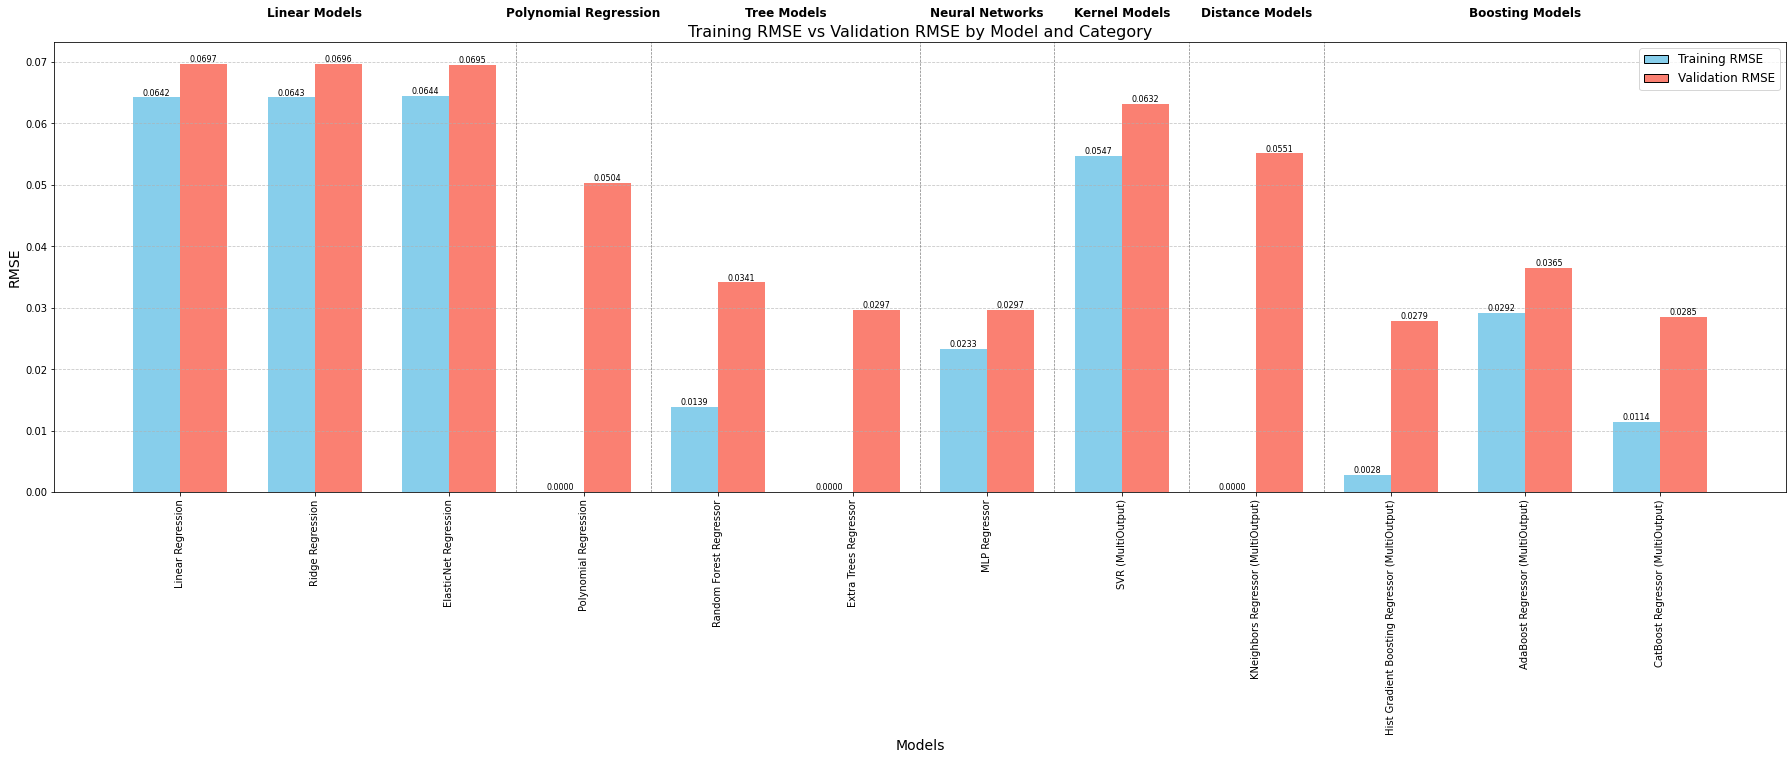

In [213]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Assuming `results` and `model_categories` are already defined as per your provided data.

model_categories = {
    'Linear Models': ['Linear Regression', 'Ridge Regression', 'ElasticNet Regression'],
    'Polynomial Regression': ['Polynomial Regression'],
    'Tree Models': ['Random Forest Regressor', 'Extra Trees Regressor'],
    'Neural Networks': ['MLP Regressor'],
    'Kernel Models': ['SVR (MultiOutput)'],
    'Distance Models': ['KNeighbors Regressor (MultiOutput)'],
    'Boosting Models': [
        'Hist Gradient Boosting Regressor (MultiOutput)',
        'AdaBoost Regressor (MultiOutput)',
        'CatBoost Regressor (MultiOutput)'
    ]
}

categories = list(model_categories.keys())

# Create a list of models ordered by categories
ordered_models = []
model_to_category = {}
for category in categories:
    for model in model_categories[category]:
        ordered_models.append(model)
        model_to_category[model] = category

n_models = len(ordered_models)

# Extract metrics for each model
train_rmse = []
cv_rmse = []
training_time = []
found_models = []

for model in ordered_models:
    # Search for the model in the results
    found = False
    for top_level_key in results:
        if model in results[top_level_key]:
            metrics = results[top_level_key][model]
            train_rmse.append(metrics['Training RMSE'])
            cv_rmse.append(metrics['Cross-Validation Mean RMSE'])
            training_time.append(metrics.get('Training Time (seconds)', np.nan))
            found_models.append(model)
            found = True
            break
    if not found:
        # If model not found in results, append NaN or a placeholder
        train_rmse.append(np.nan)
        cv_rmse.append(np.nan)
        training_time.append(np.nan)
        found_models.append(model)
        print(f"Warning: Metrics for model '{model}' not found in results.")

# Assign x positions to each model
x = np.arange(n_models)

# Plotting parameters
width = 0.35  # Width of the bars
fig, ax = plt.subplots(figsize=(25, 12))  # Adjusted figure size for better readability

# Colors for Training and Validation RMSE
color_train = 'skyblue'
color_cv = 'salmon'

# Plot Training RMSE
bars1 = ax.bar(x - width/2, train_rmse, width, label='Training RMSE', color=color_train)

# Plot Validation RMSE
bars2 = ax.bar(x + width/2, cv_rmse, width, label='Validation RMSE', color=color_cv)

# Add text labels on top of the bars with horizontal orientation
for bar in bars1 + bars2:
    height = bar.get_height()
    if not np.isnan(height):
        ax.text(
            bar.get_x() + bar.get_width()/2,  # X position: center of the bar
            height,                           # Y position: top of the bar
            f'{height:.4f}',                  # Text: RMSE value
            ha='center',                      # Horizontal alignment
            va='bottom',                      # Vertical alignment
            fontsize=8,                       # Font size
            rotation=0                        # Rotation set to 0 for horizontal text
        )

# Set model names as x-axis labels
ax.set_xticks(x)
ax.set_xticklabels(ordered_models, rotation=90, ha='center', fontsize=10)

# Add category labels above the x-axis labels, centered over their respective models
current_index = 0
for category in categories:
    n = len(model_categories[category])
    if n > 0:
        # Calculate the center position for the category label
        if n == 1:
            center = current_index
        else:
            center = current_index + (n - 1) / 2
        # Adjust the y-position to move category labels higher up
        ax.text(
            center, 
            ax.get_ylim()[1] * 1.05,  # Y position: slightly above the top of the bars
            category, 
            ha='center', 
            va='bottom',
            fontsize=12, 
            fontweight='bold', 
            rotation=0
        )
        current_index += n

# Draw vertical lines to separate categories
current_index = 0
for category in categories:
    n = len(model_categories[category])
    current_index += n
    if current_index < n_models:
        ax.axvline(current_index - 0.5, color='grey', linestyle='--', linewidth=0.7)

# Set labels and title
ax.set_xlabel('Models', fontsize=14)
ax.set_ylabel('RMSE', fontsize=14)
ax.set_title('Training RMSE vs Validation RMSE by Model and Category', fontsize=16)

# Create custom legend
legend_elements = [
    Patch(facecolor=color_train, edgecolor='k', label='Training RMSE'),
    Patch(facecolor=color_cv, edgecolor='k', label='Validation RMSE')
]
ax.legend(handles=legend_elements, fontsize=12)

# Add grid
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout to make room for category labels
plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.savefig('training_vs_validation_rmse_all_features.png', format='png', dpi=300, bbox_inches='tight')
# Show the plot
plt.show()


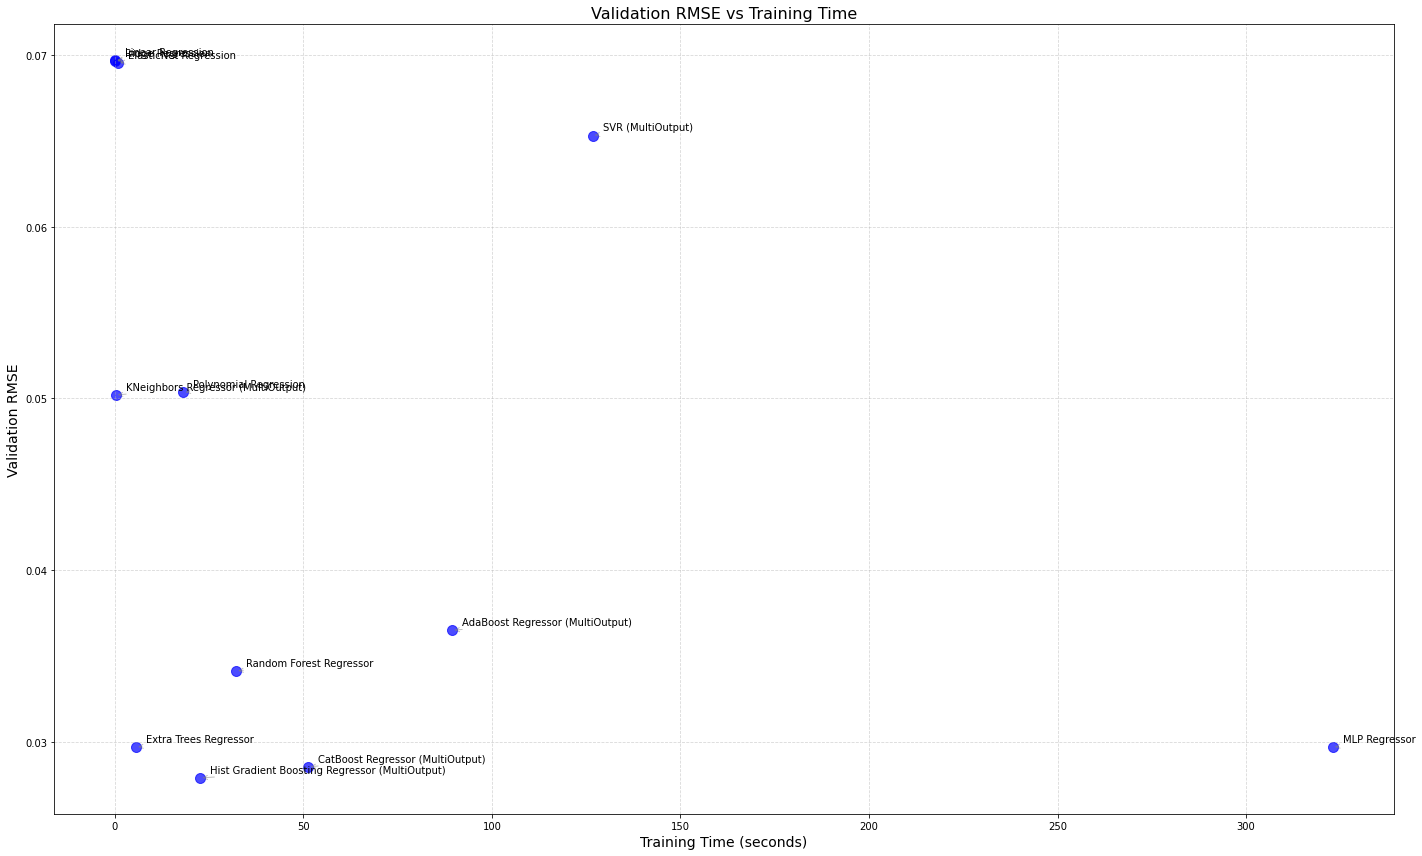

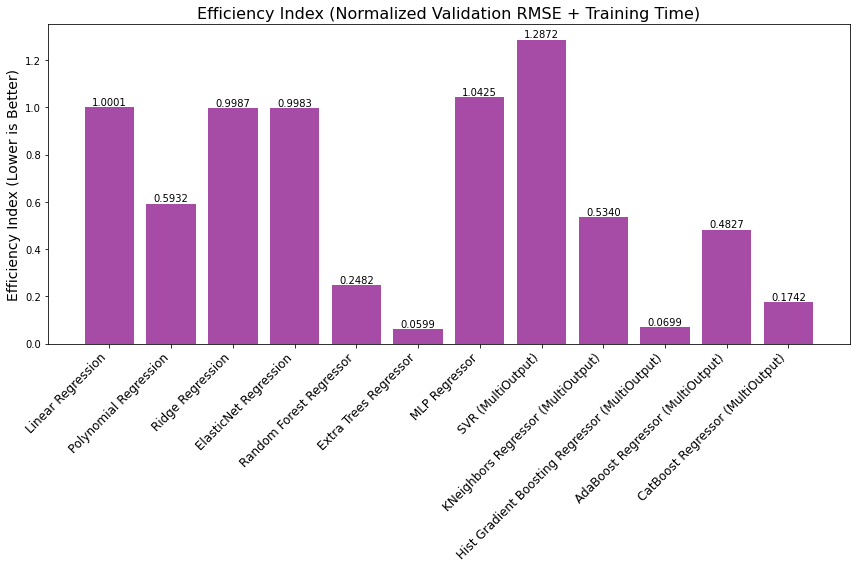

In [60]:
plt.figure(figsize=(20, 12))
plt.scatter(train_time, cv_rmse, color='blue', s=100, alpha=0.7)

for i, model in enumerate(models):
    plt.annotate(
        model,
        (train_time[i], cv_rmse[i]),
        textcoords="offset points",  # Text offset
        xytext=(10, 5),  # Offset distance (x, y)
        ha='left',
        arrowprops=dict(arrowstyle="->", color='gray', alpha=0.5)  # Optional arrow
    )

plt.title('Validation RMSE vs Training Time', fontsize=16)
plt.xlabel('Training Time (seconds)', fontsize=14)
plt.ylabel('Validation RMSE', fontsize=14)
plt.grid(alpha=0.5, linestyle='--')
plt.tight_layout()
plt.show()


#2
# Normalize Validation RMSE and Training Time with range check
min_rmse, max_rmse = min(cv_rmse), max(cv_rmse)
min_time, max_time = min(train_time), max(train_time)

normalized_rmse = [
    (rmse - min_rmse) / (max_rmse - min_rmse) if max_rmse > min_rmse else 0
    for rmse in cv_rmse
]
normalized_time = [
    (time - min_time) / (max_time - min_time) if max_time > min_time else 0
    for time in train_time
]

# Calculate Efficiency Index
efficiency_index = [rmse + time for rmse, time in zip(normalized_rmse, normalized_time)]

# Plot Efficiency Index
plt.figure(figsize=(12, 8))
bars = plt.bar(models, efficiency_index, color='purple', alpha=0.7)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.ylabel('Efficiency Index (Lower is Better)', fontsize=14)
plt.title('Efficiency Index (Normalized Validation RMSE + Training Time)', fontsize=16)

# Annotate bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.4f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

In [61]:
selected_features_dict = {
    '5 features': {
    },
    '10 features': {
    },
    '15 features': {
    }
}


In [62]:
def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data['Feature'] = X.columns
    vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif_data = vif_data.sort_values(by="VIF", ascending=False).reset_index(drop=True)
    return vif_data

vif_data = calculate_vif(X_train_val)
print("\nVIF for all features:")
print(vif_data)


# Split VIF data into Feature 1-25 and Feature 26-50 using explicit range matching
vif_below_25 = vif_data[vif_data['Feature'].apply(lambda x: int(x.split('_')[1]) <= 25)]
vif_above_25 = vif_data[vif_data['Feature'].apply(lambda x: int(x.split('_')[1]) > 25)]

# Count features with VIF > 10 in each group
count_below_25 = vif_below_25[vif_below_25['VIF'] > 10].shape[0]
count_above_25 = vif_above_25[vif_above_25['VIF'] > 10].shape[0]

print(f"Number of features with VIF > 10 in Feature 1-25: {count_below_25}")
print(f"Number of features with VIF > 10 in Feature 26-50: {count_above_25}")


VIF for all features:
       Feature         VIF
0    Feature_4  531.903751
1   Feature_15  433.581446
2   Feature_25  369.333030
3   Feature_19  355.595193
4   Feature_12  200.944620
5   Feature_16  121.625513
6   Feature_22  100.934075
7   Feature_18  100.405558
8    Feature_2   84.925959
9    Feature_3   32.458433
10  Feature_17   31.643804
11  Feature_21   29.439326
12  Feature_20   27.160039
13  Feature_14   26.455310
14   Feature_6   24.121991
15   Feature_5   23.491801
16   Feature_9   21.501870
17  Feature_13   21.352112
18   Feature_7   20.886566
19   Feature_8   20.323863
20  Feature_10   19.484278
21  Feature_24   16.436210
22   Feature_1   14.019076
23  Feature_11   13.821099
24  Feature_23   12.789587
25  Feature_31   10.088391
26  Feature_49    9.146453
27  Feature_26    9.063038
28  Feature_38    8.911633
29  Feature_33    8.885456
30  Feature_39    8.596486
31  Feature_28    8.476532
32  Feature_32    8.277811
33  Feature_46    8.244332
34  Feature_47    8.179121
35  F

In [64]:
import dcor

# Ensure X_train_val_scaled is a pandas DataFrame
y_train_val_np = y_train_val.values if isinstance(y_train_val, pd.DataFrame) else y_train_val

# Filter for Average MI
model_name = "Avg MI"
mi_scores_per_output = np.zeros((y_train_val_np.shape[1], X_train_val_scaled.shape[1]))

for i in range(y_train_val_np.shape[1]):
    mi_scores_per_output[i, :] = mutual_info_regression(X_train_val_scaled, y_train_val_np[:, i])

mi_scores_avg = np.mean(mi_scores_per_output, axis=0)
sorted_indices = np.argsort(mi_scores_avg)[::-1]

selected_features_dict['5 features'][model_name] = [f'Feature_{i+1}' for i in sorted_indices[:5]]
selected_features_dict['10 features'][model_name] = [f'Feature_{i+1}' for i in sorted_indices[:10]]
selected_features_dict['15 features'][model_name] = [f'Feature_{i+1}' for i in sorted_indices[:15]]

# Filter for Average MIC
model_name = "Avg MIC"
mic_scores_per_output = np.zeros((y_train_val_np.shape[1], X_train_val_scaled.shape[1]))
mine = MINE()

for i in range(y_train_val_np.shape[1]):
    for j in range(X_train_val_scaled.shape[1]):
        mine.compute_score(X_train_val_scaled.iloc[:, j], y_train_val_np[:, i])
        mic_scores_per_output[i, j] = mine.mic()

mic_scores_avg = np.mean(mic_scores_per_output, axis=0)
sorted_indices = np.argsort(mic_scores_avg)[::-1]

selected_features_dict['5 features'][model_name] = [f'Feature_{i+1}' for i in sorted_indices[:5]]
selected_features_dict['10 features'][model_name] = [f'Feature_{i+1}' for i in sorted_indices[:10]]
selected_features_dict['15 features'][model_name] = [f'Feature_{i+1}' for i in sorted_indices[:15]]

# Filter for Average Correlation
model_name = "Avg Correlation"
correlation_scores_per_output = np.zeros((y_train_val_np.shape[1], X_train_val_scaled.shape[1]))

for output in range(y_train_val_np.shape[1]):
    corr_scores = [
        np.corrcoef(X_train_val_scaled.iloc[:, i], y_train_val_np[:, output])[0, 1]
        for i in range(X_train_val_scaled.shape[1])
    ]
    correlation_scores_per_output[output, :] = np.nan_to_num(corr_scores)

correlation_scores_avg = np.mean(np.abs(correlation_scores_per_output), axis=0)
sorted_indices = np.argsort(correlation_scores_avg)[::-1]

selected_features_dict['5 features'][model_name] = [f'Feature_{i+1}' for i in sorted_indices[:5]]
selected_features_dict['10 features'][model_name] = [f'Feature_{i+1}' for i in sorted_indices[:10]]
selected_features_dict['15 features'][model_name] = [f'Feature_{i+1}' for i in sorted_indices[:15]]

# Filter for Average ANOVA F-value
model_name = "Avg ANOVA F-value"
f_scores_per_output = np.zeros((y_train_val_np.shape[1], X_train_val_scaled.shape[1]))

for output in range(y_train_val_np.shape[1]):
    f_stat, _ = f_regression(X_train_val_scaled, y_train_val_np[:, output])
    f_scores_per_output[output, :] = f_stat

f_scores_avg = np.mean(f_scores_per_output, axis=0)
sorted_indices = np.argsort(f_scores_avg)[::-1]

selected_features_dict['5 features'][model_name] = [f'Feature_{i+1}' for i in sorted_indices[:5]]
selected_features_dict['10 features'][model_name] = [f'Feature_{i+1}' for i in sorted_indices[:10]]
selected_features_dict['15 features'][model_name] = [f'Feature_{i+1}' for i in sorted_indices[:15]]

# Filter for Average Distance Correlation
model_name = "Avg Distance Correlation"
dcor_scores_per_output = np.zeros((y_train_val_np.shape[1], X_train_val_scaled.shape[1]))

for output in range(y_train_val_np.shape[1]):
    dcor_scores = [
        dcor.distance_correlation(X_train_val_scaled.iloc[:, i], y_train_val_np[:, output])
        for i in range(X_train_val_scaled.shape[1])
    ]
    dcor_scores_per_output[output, :] = dcor_scores

dcor_scores_avg = np.mean(dcor_scores_per_output, axis=0)
sorted_indices = np.argsort(dcor_scores_avg)[::-1]

# Select top features
selected_features_dict['5 features'][model_name] = [f'Feature_{i+1}' for i in sorted_indices[:5]]
selected_features_dict['10 features'][model_name] = [f'Feature_{i+1}' for i in sorted_indices[:10]]
selected_features_dict['15 features'][model_name] = [f'Feature_{i+1}' for i in sorted_indices[:15]]

/Users/kanishk/opt/anaconda3/lib/python3.9/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)
OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.



VIF for all features:
       Feature         VIF
0    Feature_4  167.653940
1   Feature_15  157.184582
2   Feature_25  153.335490
3   Feature_19  141.294080
4   Feature_12   78.641846
5   Feature_22   54.993071
6   Feature_18   51.318104
7   Feature_16   48.392623
8    Feature_2   47.562583
9    Feature_7   16.861612
10  Feature_17   10.612797
11  Feature_11    6.542223
12   Feature_6    6.521484
13  Feature_21    5.888673
14   Feature_9    5.744592
15   Feature_3    5.734591
16  Feature_14    5.700567
17  Feature_13    5.339858
18  Feature_20    4.841857
19  Feature_23    4.809383
20   Feature_8    4.712241
21   Feature_1    4.417642
22  Feature_24    4.299875
23  Feature_36    4.155770
24  Feature_48    3.703300
25  Feature_31    3.464973
26  Feature_26    3.333339
27  Feature_27    3.145881
28  Feature_49    3.130971
29  Feature_38    3.062360
30  Feature_41    3.041318
31  Feature_42    3.034389
32   Feature_5    3.006772
33  Feature_43    2.931877
34  Feature_34    2.901118
35  F

In [65]:
#Wrapper
models_sfs = {
    model_name: params['Best Parameters']['model'] 
    for category in results.values() 
    for model_name, params in category.items()
}

print(models_sfs)


for model_name, model in models_sfs.items():
#     sfs = SequentialFeatureSelector(model, n_features_to_select=5, direction='forward', scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
#     sfs.fit(X_train, y_train)
#     selected_features_5 = [f'Feature_{i+1}' for i in range(X_train.shape[1]) if sfs.get_support()[i]]
#     selected_features_dict['5 features'][model_name] = selected_features_5
#     print(f"Completed {model_name} with 5 features")

#     sfs = SequentialFeatureSelector(model, n_features_to_select=10, direction='forward', scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
#     sfs.fit(X_train, y_train)
#     selected_features_10 = [f'Feature_{i+1}' for i in range(X_train.shape[1]) if sfs.get_support()[i]]
#     selected_features_dict['10 features'][model_name] = selected_features_10
#     print(f"Completed {model_name} with 10 features")

    sfs = SequentialFeatureSelector(model, n_features_to_select=15, direction='forward', scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
    sfs.fit(X_train, y_train)
    selected_features_15 = [f'Feature_{i+1}' for i in range(X_train.shape[1]) if sfs.get_support()[i]]
    selected_features_dict['15 features'][model_name] = selected_features_15
    print(f"Completed {model_name} with 15 features")


{'Linear Regression': LinearRegression(), 'Polynomial Regression': Pipeline(steps=[('poly', PolynomialFeatures(degree=3)),
                ('linear', LinearRegression())]), 'Ridge Regression': Ridge(alpha=0.31622776601683794), 'ElasticNet Regression': ElasticNet(alpha=0.001, l1_ratio=0.1, max_iter=10000), 'Random Forest Regressor': RandomForestRegressor(max_depth=10, n_estimators=200, random_state=42), 'Extra Trees Regressor': ExtraTreesRegressor(n_estimators=200, random_state=42), 'MLP Regressor': MLPRegressor(alpha=0.1, early_stopping=True, hidden_layer_sizes=(50, 50),
             learning_rate_init=0.01, max_iter=10000, random_state=42), 'SVR (MultiOutput)': MultiOutputRegressor(estimator=SVR(C=5.623413251903491)), 'KNeighbors Regressor (MultiOutput)': MultiOutputRegressor(estimator=KNeighborsRegressor(n_neighbors=3,
                                                   weights='distance')), 'Hist Gradient Boosting Regressor (MultiOutput)': MultiOutputRegressor(estimator=HistGradientB

In [68]:
selected_features_dict = {'5 features': {},
 '10 features': {},
 '15 features': {
  'Linear Regression': ['Feature_1',
   'Feature_4',
   'Feature_5',
   'Feature_10',
   'Feature_13',
   'Feature_17',
   'Feature_18',
   'Feature_19',
   'Feature_20',
   'Feature_22',
   'Feature_25',
   'Feature_29',
   'Feature_32',
   'Feature_37',
   'Feature_41'],
  'Polynomial Regression': ['Feature_1',
   'Feature_2',
   'Feature_3',
   'Feature_11',
   'Feature_17',
   'Feature_18',
   'Feature_19',
   'Feature_20',
   'Feature_21',
   'Feature_22',
   'Feature_24',
   'Feature_30',
   'Feature_32',
   'Feature_39',
   'Feature_41'],
  'Ridge Regression': ['Feature_1',
   'Feature_3',
   'Feature_7',
   'Feature_10',
   'Feature_12',
   'Feature_13',
   'Feature_17',
   'Feature_18',
   'Feature_19',
   'Feature_20',
   'Feature_21',
   'Feature_25',
   'Feature_27',
   'Feature_32',
   'Feature_41'],
  'ElasticNet Regression': ['Feature_1',
   'Feature_3',
   'Feature_7',
   'Feature_10',
   'Feature_11',
   'Feature_12',
   'Feature_13',
   'Feature_17',
   'Feature_18',
   'Feature_19',
   'Feature_20',
   'Feature_21',
   'Feature_27',
   'Feature_32',
   'Feature_41'],
  'Random Forest Regressor': ['Feature_5',
   'Feature_9',
   'Feature_11',
   'Feature_12',
   'Feature_17',
   'Feature_18',
   'Feature_19',
   'Feature_20',
   'Feature_21',
   'Feature_27',
   'Feature_32',
   'Feature_39',
   'Feature_43',
   'Feature_44',
   'Feature_45'],
  'Extra Trees Regressor': ['Feature_2',
   'Feature_11',
   'Feature_12',
   'Feature_14',
   'Feature_17',
   'Feature_18',
   'Feature_19',
   'Feature_20',
   'Feature_21',
   'Feature_22',
   'Feature_28',
   'Feature_32',
   'Feature_44',
   'Feature_45',
   'Feature_49'],
  'MLP Regressor': ['Feature_4',
   'Feature_12',
   'Feature_13',
   'Feature_16',
   'Feature_17',
   'Feature_18',
   'Feature_19',
   'Feature_20',
   'Feature_22',
   'Feature_25',
   'Feature_27',
   'Feature_32',
   'Feature_35',
   'Feature_38',
   'Feature_46'],
  'SVR (MultiOutput)': ['Feature_4',
   'Feature_5',
   'Feature_10',
   'Feature_13',
   'Feature_17',
   'Feature_18',
   'Feature_19',
   'Feature_20',
   'Feature_27',
   'Feature_32',
   'Feature_35',
   'Feature_36',
   'Feature_37',
   'Feature_40',
   'Feature_42'],
  'KNeighbors Regressor (MultiOutput)': ['Feature_11',
   'Feature_12',
   'Feature_13',
   'Feature_15',
   'Feature_18',
   'Feature_19',
   'Feature_20',
   'Feature_33',
   'Feature_35',
   'Feature_36',
   'Feature_37',
   'Feature_40',
   'Feature_42',
   'Feature_44',
   'Feature_49'],
  'Hist Gradient Boosting Regressor (MultiOutput)': ['Feature_11',
   'Feature_12',
   'Feature_17',
   'Feature_18',
   'Feature_19',
   'Feature_21',
   'Feature_25',
   'Feature_27',
   'Feature_32',
   'Feature_36',
   'Feature_39',
   'Feature_40',
   'Feature_41',
   'Feature_45',
   'Feature_49'],
  'AdaBoost Regressor (MultiOutput)': ['Feature_3',
   'Feature_6',
   'Feature_8',
   'Feature_12',
   'Feature_17',
   'Feature_18',
   'Feature_19',
   'Feature_20',
   'Feature_21',
   'Feature_25',
   'Feature_32',
   'Feature_37',
   'Feature_39',
   'Feature_45',
   'Feature_49'],
  'CatBoost Regressor (MultiOutput)': ['Feature_11',
   'Feature_12',
   'Feature_17',
   'Feature_18',
   'Feature_19',
   'Feature_20',
   'Feature_21',
   'Feature_25',
   'Feature_27',
   'Feature_31',
   'Feature_32',
   'Feature_37',
   'Feature_41',
   'Feature_43',
   'Feature_45']}}

In [106]:
model_param_grid_non_inherent = {
    'SVR (MultiOutput)': {
        'model__estimator__kernel': ['linear', 'rbf'],
        'model__estimator__C': np.logspace(-3, 2, 5),
        'base_model': SVR()  # Base estimator for MultiOutputRegressor
    },
    'KNeighbors Regressor (MultiOutput)': {
        'model__estimator__n_neighbors': [3, 5, 10],
        'model__estimator__weights': ['uniform', 'distance'],
        'base_model': KNeighborsRegressor()
    },
    'Hist Gradient Boosting Regressor (MultiOutput)': {
        'model__estimator__max_iter': [100, 200],
        'model__estimator__learning_rate': np.logspace(-3, 0, 4),
        'base_model': HistGradientBoostingRegressor(random_state=42)
    },
    'AdaBoost Regressor (MultiOutput)': {
        'base_model': AdaBoostRegressor(random_state=42),
        'model__estimator__n_estimators': [50, 100, 200],  # Number of trees
        'model__estimator__learning_rate': [0.01, 0.1, 1.0],  # Learning rate for the updates
        'model__estimator__loss': ['linear', 'square', 'exponential']  # Different loss functions for residuals
    },
    'CatBoost Regressor (MultiOutput)': {
        'base_model': CatBoostRegressor(verbose=0, random_state=42),
        'model__estimator__iterations': [50, 100],  # Reduced iterations
        'model__estimator__learning_rate': [0.01, 0.1],  # Reduced learning rate range
        'model__estimator__depth': [3, 5],  # Remove depth 10
        'model__estimator__l2_leaf_reg': [0.1, 1, 10],  # Reduce l2_leaf_reg
        'model__estimator__od_type': ['Iter'],  # Early stopping
        'model__estimator__od_wait': [20]  # Early stopping patience
    }
}

In [107]:
results_15_features = {'Inherently Multi-Output': {}, 'Single-Output (adapted to Multi-Output)': {}}

for name, param_grid in model_param_grid.items():
    print(f"Tuning and evaluating: {name}")
    
    selected_features = selected_features_dict['15 features'].get(name, X_train_val.columns)  # Get selected features or use all
    X_train_val_selected = X_train_val[selected_features]
    X_train_val_scaled = pd.DataFrame(scaler.fit_transform(X_train_val_selected), columns=X_train_val_selected.columns)
    
    pipeline = Pipeline([('model', param_grid['model'][0])])  # Start with the model from the grid
    
    grid = GridSearchCV(pipeline, param_grid, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)
    
    start_time = time.time()
    grid.fit(X_train_val_scaled, y_train_val)
    end_time = time.time()
    training_time = end_time - start_time
    
    best_params = clean_params_with_model(grid)

    best_neg_mse = grid.best_score_
    best_mse = -best_neg_mse  # Convert to positive
    best_rmse = np.sqrt(best_mse)

    train_predictions = grid.best_estimator_.predict(X_train_val_scaled)
    train_mse = mean_squared_error(y_train_val, train_predictions)
    train_rmse = np.sqrt(train_mse)
    
    results_15_features['Inherently Multi-Output'][name] = {
        'Best Parameters': best_params,
        'Cross-Validation Mean MSE': best_mse,
        'Cross-Validation Mean RMSE': best_rmse,
        'Training RMSE': train_rmse,
        'Training Time (seconds)': training_time
    }

for name, param_grids in model_param_grid_non_inherent.items():
    print(f"Tuning and evaluating: {name}")
    
    selected_features = selected_features_dict['15 features'].get(name, X_train_val.columns)  # Get selected features or use all
    X_train_val_selected = X_train_val[selected_features]
    X_train_val_scaled = pd.DataFrame(scaler.fit_transform(X_train_val_selected), columns=X_train_val_selected.columns)
    
    base_model = MultiOutputRegressor(param_grids.pop('base_model'))
    pipeline = Pipeline([('scaler', StandardScaler()), ('model', base_model)])
    
    grid = GridSearchCV(pipeline, param_grids, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)
    
    start_time = time.time()
    grid.fit(X_train_val_scaled, y_train_val)
    end_time = time.time()
    training_time = end_time - start_time
    
    best_params = clean_params_with_model(grid)
    
    best_neg_mse = grid.best_score_
    best_mse = -best_neg_mse  # Convert to positive
    best_rmse = np.sqrt(best_mse)
    
    train_predictions = grid.best_estimator_.predict(X_train_val_scaled)
    train_mse = mean_squared_error(y_train_val, train_predictions)
    train_rmse = np.sqrt(train_mse)
    
    results_15_features['Single-Output (adapted to Multi-Output)'][name] = {
        'Best Parameters': best_params,
        'Cross-Validation Mean MSE': best_mse,
        'Cross-Validation Mean RMSE': best_rmse,
        'Training RMSE': train_rmse,
        'Training Time (seconds)': training_time
    }

Tuning and evaluating: Linear Regression
Tuning and evaluating: Polynomial Regression
Tuning and evaluating: Ridge Regression
Tuning and evaluating: ElasticNet Regression
Tuning and evaluating: Random Forest Regressor
Tuning and evaluating: Extra Trees Regressor
Tuning and evaluating: MLP Regressor
Tuning and evaluating: SVR (MultiOutput)
MultiOutputRegressor(estimator=SVR())
Tuning and evaluating: KNeighbors Regressor (MultiOutput)
MultiOutputRegressor(estimator=KNeighborsRegressor())
Tuning and evaluating: Hist Gradient Boosting Regressor (MultiOutput)
MultiOutputRegressor(estimator=HistGradientBoostingRegressor(random_state=42))
Tuning and evaluating: AdaBoost Regressor (MultiOutput)
MultiOutputRegressor(estimator=AdaBoostRegressor(random_state=42))
Tuning and evaluating: CatBoost Regressor (MultiOutput)
MultiOutputRegressor(estimator=<catboost.core.CatBoostRegressor object at 0x7fbed3b4a3d0>)


In [108]:
results_15_features

{'Inherently Multi-Output': {'Linear Regression': {'Best Parameters': {'model': LinearRegression()},
   'Cross-Validation Mean MSE': 0.004879276228872466,
   'Cross-Validation Mean RMSE': 0.06985181621742176,
   'Training RMSE': 0.06830082405350872,
   'Training Time (seconds)': 3.1598658561706543},
  'Polynomial Regression': {'Best Parameters': {'model': Pipeline(steps=[('poly', PolynomialFeatures(interaction_only=True)),
                    ('linear', LinearRegression())]),
    'degree': 2,
    'interaction_only': True},
   'Cross-Validation Mean MSE': 0.0025204825790871334,
   'Cross-Validation Mean RMSE': 0.05020440796471096,
   'Training RMSE': 0.038685043734616356,
   'Training Time (seconds)': 1.1644001007080078},
  'Ridge Regression': {'Best Parameters': {'model': Ridge(alpha=0.31622776601683794),
    'alpha': 0.31622776601683794},
   'Cross-Validation Mean MSE': 0.0051402052940047165,
   'Cross-Validation Mean RMSE': 0.07169522504326711,
   'Training RMSE': 0.06998051687086608

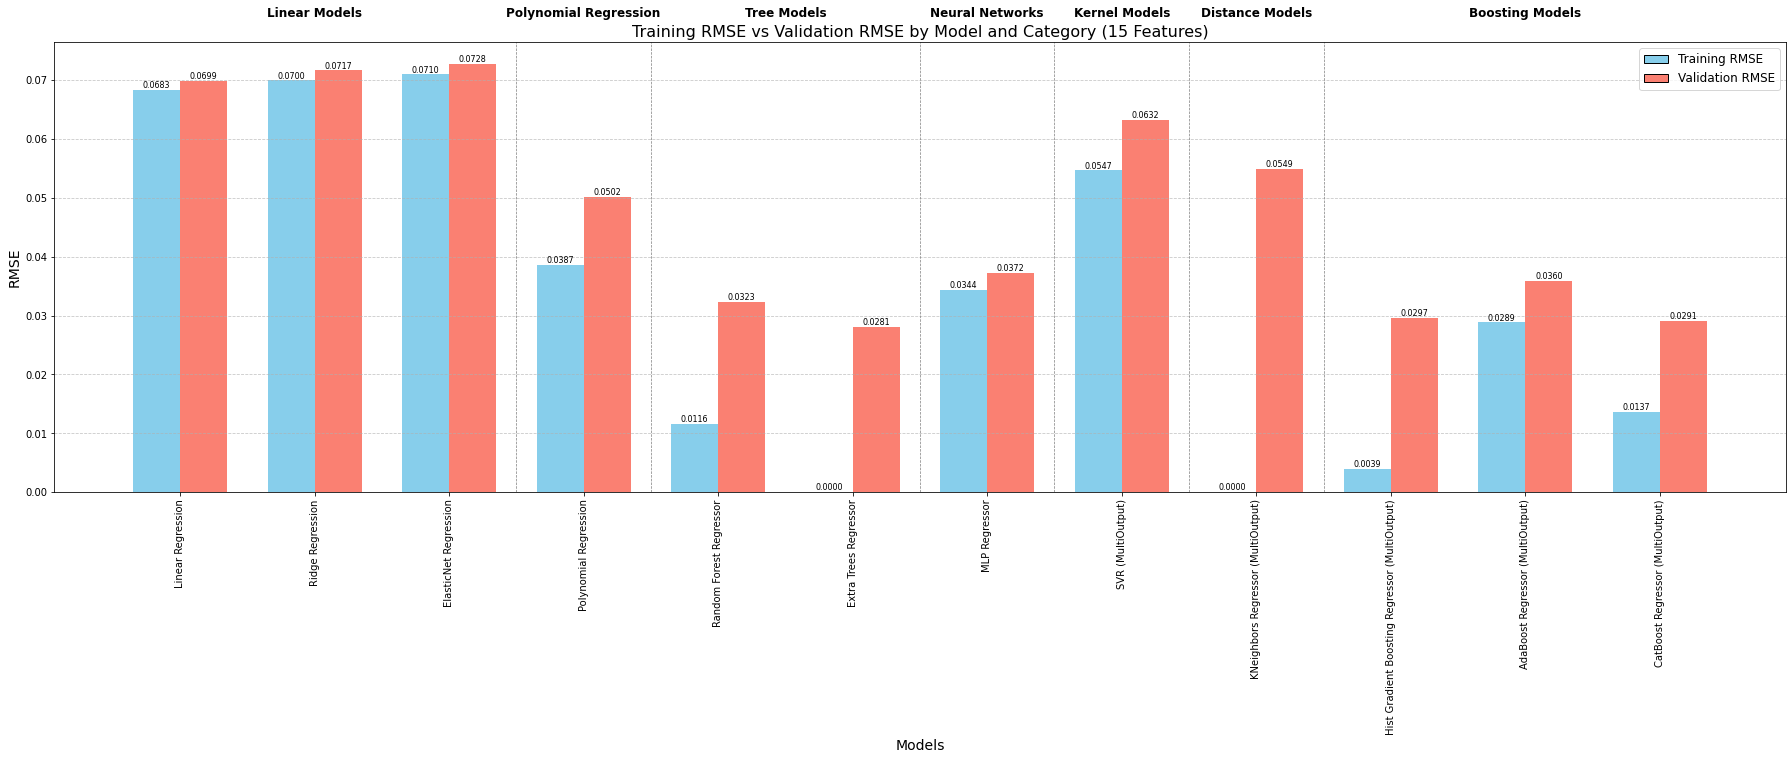

In [214]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Define model categories (same as your first plot)
model_categories = {
    'Linear Models': ['Linear Regression', 'Ridge Regression', 'ElasticNet Regression'],
    'Polynomial Regression': ['Polynomial Regression'],
    'Tree Models': ['Random Forest Regressor', 'Extra Trees Regressor'],
    'Neural Networks': ['MLP Regressor'],
    'Kernel Models': ['SVR (MultiOutput)'],
    'Distance Models': ['KNeighbors Regressor (MultiOutput)'],
    'Boosting Models': [
        'Hist Gradient Boosting Regressor (MultiOutput)',
        'AdaBoost Regressor (MultiOutput)',
        'CatBoost Regressor (MultiOutput)'
    ]
}

categories = list(model_categories.keys())

# Create a list of models ordered by categories
ordered_models = []
model_to_category = {}
for category in categories:
    for model in model_categories[category]:
        ordered_models.append(model)
        model_to_category[model] = category

n_models = len(ordered_models)

# Extract metrics for each model from results_15_features
train_rmse = []
cv_rmse = []
training_time = []
found_models = []

for model in ordered_models:
    # Search for the model in the results_15_features
    found = False
    for top_level_key in results_15_features:
        if model in results_15_features[top_level_key]:
            metrics = results_15_features[top_level_key][model]
            train_rmse.append(metrics['Training RMSE'])
            cv_rmse.append(metrics['Cross-Validation Mean RMSE'])
            training_time.append(metrics.get('Training Time (seconds)', np.nan))
            found_models.append(model)
            found = True
            break
    if not found:
        # If model not found in results_15_features, append NaN or a placeholder
        train_rmse.append(np.nan)
        cv_rmse.append(np.nan)
        training_time.append(np.nan)
        found_models.append(model)
        print(f"Warning: Metrics for model '{model}' not found in results_15_features.")

# Assign x positions to each model
x = np.arange(n_models)

# Plotting parameters
width = 0.35  # Width of the bars
fig, ax = plt.subplots(figsize=(25, 12))  # Adjusted figure size for better readability

# Colors for Training and Validation RMSE
color_train = 'skyblue'
color_cv = 'salmon'

# Plot Training RMSE
bars1 = ax.bar(x - width/2, train_rmse, width, label='Training RMSE', color=color_train)

# Plot Validation RMSE
bars2 = ax.bar(x + width/2, cv_rmse, width, label='Validation RMSE', color=color_cv)

# Add text labels on top of the bars with horizontal orientation
for bar in bars1 + bars2:
    height = bar.get_height()
    if not np.isnan(height):
        ax.text(
            bar.get_x() + bar.get_width()/2,  # X position: center of the bar
            height,                           # Y position: top of the bar
            f'{height:.4f}',                  # Text: RMSE value
            ha='center',                      # Horizontal alignment
            va='bottom',                      # Vertical alignment
            fontsize=8,                       # Font size
            rotation=0                        # Rotation set to 0 for horizontal text
        )

# Set model names as x-axis labels
ax.set_xticks(x)
ax.set_xticklabels(ordered_models, rotation=90, ha='center', fontsize=10)

# Add category labels above the x-axis labels, centered over their respective models
current_index = 0
for category in categories:
    n = len(model_categories[category])
    if n > 0:
        # Calculate the center position for the category label
        if n == 1:
            center = current_index
        else:
            center = current_index + (n - 1) / 2
        # Adjust the y-position to move category labels higher up
        ax.text(
            center, 
            ax.get_ylim()[1] * 1.05,  # Y position: slightly above the top of the bars
            category, 
            ha='center', 
            va='bottom',
            fontsize=12, 
            fontweight='bold', 
            rotation=0
        )
        current_index += n

# Draw vertical lines to separate categories
current_index = 0
for category in categories:
    n = len(model_categories[category])
    current_index += n
    if current_index < n_models:
        ax.axvline(current_index - 0.5, color='grey', linestyle='--', linewidth=0.7)

# Set labels and title
ax.set_xlabel('Models', fontsize=14)
ax.set_ylabel('RMSE', fontsize=14)
ax.set_title('Training RMSE vs Validation RMSE by Model and Category (15 Features)', fontsize=16)

# Create custom legend
legend_elements = [
    Patch(facecolor=color_train, edgecolor='k', label='Training RMSE'),
    Patch(facecolor=color_cv, edgecolor='k', label='Validation RMSE')
]
ax.legend(handles=legend_elements, fontsize=12)

# Add grid
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout to make room for category labels
plt.tight_layout(rect=[0, 0.05, 1, 0.95])

plt.savefig('training_vs_validation_rmse_15_features.png', format='png', dpi=300, bbox_inches='tight')
plt.show()


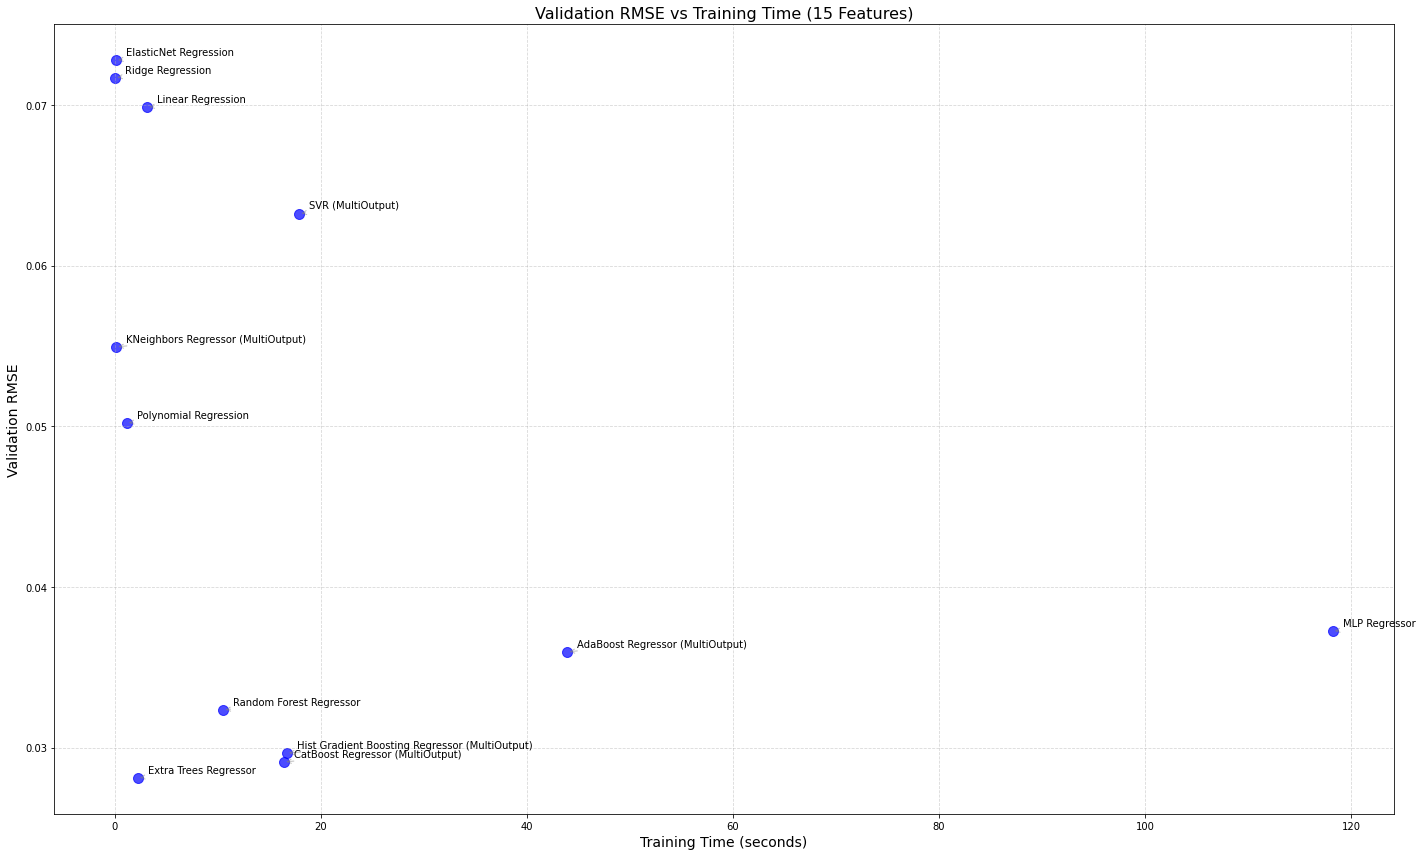

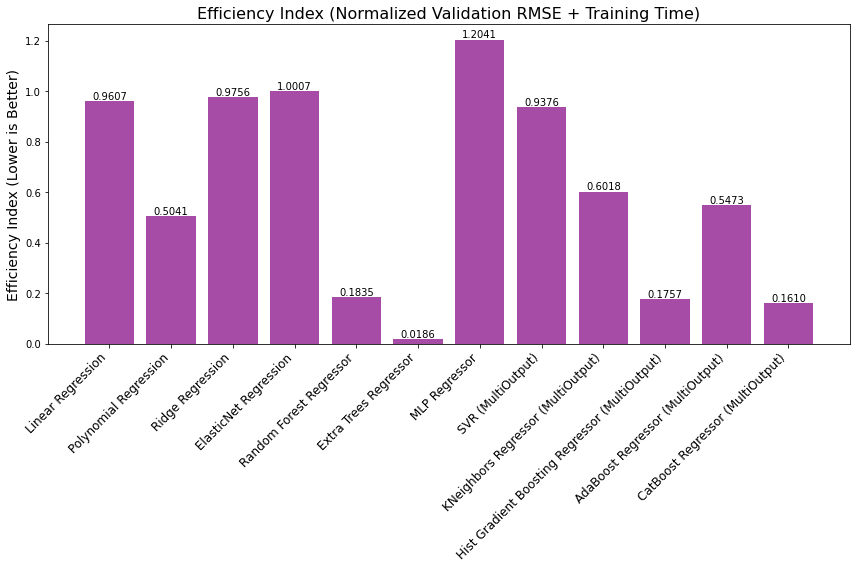

In [110]:
# 1. Plot Validation RMSE vs Training Time
plt.figure(figsize=(20, 12))
plt.scatter(train_time, cv_rmse, color='blue', s=100, alpha=0.7)

for i, model in enumerate(models):
    plt.annotate(
        model,
        (train_time[i], cv_rmse[i]),
        textcoords="offset points",  # Text offset
        xytext=(10, 5),  # Offset distance (x, y)
        ha='left',
        arrowprops=dict(arrowstyle="->", color='gray', alpha=0.5)  # Optional arrow
    )

plt.title('Validation RMSE vs Training Time (15 Features)', fontsize=16)
plt.xlabel('Training Time (seconds)', fontsize=14)
plt.ylabel('Validation RMSE', fontsize=14)
plt.grid(alpha=0.5, linestyle='--')
plt.tight_layout()
plt.show()

# 2. Calculate and plot Efficiency Index
# Normalize Validation RMSE and Training Time with range check
min_rmse, max_rmse = min(cv_rmse), max(cv_rmse)
min_time, max_time = min(train_time), max(train_time)

normalized_rmse = [
    (rmse - min_rmse) / (max_rmse - min_rmse) if max_rmse > min_rmse else 0
    for rmse in cv_rmse
]
normalized_time = [
    (time - min_time) / (max_time - min_time) if max_time > min_time else 0
    for time in train_time
]

# Calculate Efficiency Index
efficiency_index = [rmse + time for rmse, time in zip(normalized_rmse, normalized_time)]

# Plot Efficiency Index
plt.figure(figsize=(12, 8))
bars = plt.bar(models, efficiency_index, color='purple', alpha=0.7)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.ylabel('Efficiency Index (Lower is Better)', fontsize=14)
plt.title('Efficiency Index (Normalized Validation RMSE + Training Time)', fontsize=16)

# Annotate bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.4f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

In [111]:
models_sfs = {
    model_name: params['Best Parameters']['model'] 
    for category in results_15_features.values() 
    for model_name, params in category.items()
}

print("Models for SFS:", models_sfs)

for model_name, model in models_sfs.items():
    if model_name not in selected_features_dict['15 features']:
        print(f"No 15 features found for {model_name}, skipping...")
        continue
    
    selected_15_features = selected_features_dict['15 features'][model_name]
    
    X_train_15 = X_train[selected_15_features]
    
    print(f"Starting SFS for {model_name} with 15 features to select top 10...")
    sfs = SequentialFeatureSelector(
        model, 
        n_features_to_select=10, 
        direction='forward', 
        scoring='neg_mean_squared_error', 
        cv=5, 
        n_jobs=-1
    )
    
    sfs.fit(X_train_15, y_train)
    
    selected_features_10 = [feature for i, feature in enumerate(selected_15_features) if sfs.get_support()[i]]
    selected_features_dict['10 features'][model_name] = selected_features_10
    
    print(f"Completed {model_name} with 10 features: {selected_features_10}")


Models for SFS: {'Linear Regression': LinearRegression(), 'Polynomial Regression': Pipeline(steps=[('poly', PolynomialFeatures(interaction_only=True)),
                ('linear', LinearRegression())]), 'Ridge Regression': Ridge(alpha=0.31622776601683794), 'ElasticNet Regression': ElasticNet(alpha=0.001, max_iter=10000), 'Random Forest Regressor': RandomForestRegressor(n_estimators=200, random_state=42), 'Extra Trees Regressor': ExtraTreesRegressor(n_estimators=200, random_state=42), 'MLP Regressor': MLPRegressor(alpha=0.1, early_stopping=True, hidden_layer_sizes=(50, 50),
             learning_rate_init=0.01, max_iter=10000, random_state=42), 'SVR (MultiOutput)': MultiOutputRegressor(estimator=SVR(C=5.623413251903491)), 'KNeighbors Regressor (MultiOutput)': MultiOutputRegressor(estimator=KNeighborsRegressor(weights='distance')), 'Hist Gradient Boosting Regressor (MultiOutput)': MultiOutputRegressor(estimator=HistGradientBoostingRegressor(max_iter=200,
                                  

In [112]:
selected_features_dict

{'5 features': {},
 '10 features': {'Linear Regression': ['Feature_1',
   'Feature_5',
   'Feature_10',
   'Feature_13',
   'Feature_17',
   'Feature_18',
   'Feature_20',
   'Feature_22',
   'Feature_32',
   'Feature_37'],
  'Polynomial Regression': ['Feature_1',
   'Feature_2',
   'Feature_3',
   'Feature_11',
   'Feature_17',
   'Feature_18',
   'Feature_19',
   'Feature_20',
   'Feature_22',
   'Feature_41'],
  'Ridge Regression': ['Feature_1',
   'Feature_7',
   'Feature_10',
   'Feature_12',
   'Feature_13',
   'Feature_17',
   'Feature_18',
   'Feature_20',
   'Feature_21',
   'Feature_32'],
  'ElasticNet Regression': ['Feature_1',
   'Feature_3',
   'Feature_7',
   'Feature_12',
   'Feature_13',
   'Feature_17',
   'Feature_18',
   'Feature_20',
   'Feature_21',
   'Feature_32'],
  'Random Forest Regressor': ['Feature_11',
   'Feature_12',
   'Feature_17',
   'Feature_18',
   'Feature_19',
   'Feature_20',
   'Feature_21',
   'Feature_32',
   'Feature_44',
   'Feature_45'],
  '

In [114]:
model_param_grid_non_inherent = {
    'SVR (MultiOutput)': {
        'model__estimator__kernel': ['linear', 'rbf'],
        'model__estimator__C': np.logspace(-3, 2, 5),
        'base_model': SVR()  # Base estimator for MultiOutputRegressor
    },
    'KNeighbors Regressor (MultiOutput)': {
        'model__estimator__n_neighbors': [3, 5, 10],
        'model__estimator__weights': ['uniform', 'distance'],
        'base_model': KNeighborsRegressor()
    },
    'Hist Gradient Boosting Regressor (MultiOutput)': {
        'model__estimator__max_iter': [100, 200],
        'model__estimator__learning_rate': np.logspace(-3, 0, 4),
        'base_model': HistGradientBoostingRegressor(random_state=42)
    },
    'AdaBoost Regressor (MultiOutput)': {
        'base_model': AdaBoostRegressor(random_state=42),
        'model__estimator__n_estimators': [50, 100, 200],  # Number of trees
        'model__estimator__learning_rate': [0.01, 0.1, 1.0],  # Learning rate for the updates
        'model__estimator__loss': ['linear', 'square', 'exponential']  # Different loss functions for residuals
    },
    'CatBoost Regressor (MultiOutput)': {
        'base_model': CatBoostRegressor(verbose=0, random_state=42),
        'model__estimator__iterations': [50, 100],  # Reduced iterations
        'model__estimator__learning_rate': [0.01, 0.1],  # Reduced learning rate range
        'model__estimator__depth': [3, 5],  # Remove depth 10
        'model__estimator__l2_leaf_reg': [0.1, 1, 10],  # Reduce l2_leaf_reg
        'model__estimator__od_type': ['Iter'],  # Early stopping
        'model__estimator__od_wait': [20]  # Early stopping patience
    }
}
results_10_features = {'Inherently Multi-Output': {}, 'Single-Output (adapted to Multi-Output)': {}}

# Train inherently multi-output models
for name, param_grid in model_param_grid.items():
    print(f"Tuning and evaluating: {name}")
    
    # Get 10 selected features for the current model
    selected_features = selected_features_dict['10 features'].get(name, X_train_val.columns)  # Get 10 features or use all
    X_train_val_selected = X_train_val[selected_features]  # Select the 10 features
    X_train_val_scaled = pd.DataFrame(scaler.fit_transform(X_train_val_selected), columns=X_train_val_selected.columns)
    
    pipeline = Pipeline([('model', param_grid['model'][0])])  # Start with the model from the grid
    
    grid = GridSearchCV(pipeline, param_grid, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)
    
    start_time = time.time()
    grid.fit(X_train_val_scaled, y_train_val)
    end_time = time.time()
    training_time = end_time - start_time
    
    best_params = clean_params_with_model(grid)

    best_neg_mse = grid.best_score_
    best_mse = -best_neg_mse  # Convert to positive
    best_rmse = np.sqrt(best_mse)

    train_predictions = grid.best_estimator_.predict(X_train_val_scaled)
    train_mse = mean_squared_error(y_train_val, train_predictions)
    train_rmse = np.sqrt(train_mse)
    
    results_10_features['Inherently Multi-Output'][name] = {
        'Best Parameters': best_params,
        'Cross-Validation Mean MSE': best_mse,
        'Cross-Validation Mean RMSE': best_rmse,
        'Training RMSE': train_rmse,
        'Training Time (seconds)': training_time
    }

# Train single-output models adapted to multi-output
for name, param_grids in model_param_grid_non_inherent.items():
    print(f"Tuning and evaluating: {name}")
    
    # Get 10 selected features for the current model
    selected_features = selected_features_dict['10 features'].get(name, X_train_val.columns)  # Get 10 features or use all
    X_train_val_selected = X_train_val[selected_features]  # Select the 10 features
    X_train_val_scaled = pd.DataFrame(scaler.fit_transform(X_train_val_selected), columns=X_train_val_selected.columns)
    
    base_model = MultiOutputRegressor(param_grids.pop('base_model'))
    
    pipeline = Pipeline([('scaler', StandardScaler()), ('model', base_model)])
    
    grid = GridSearchCV(pipeline, param_grids, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)
    
    start_time = time.time()
    grid.fit(X_train_val_scaled, y_train_val)
    end_time = time.time()
    training_time = end_time - start_time
    
    best_params = clean_params_with_model(grid)
    
    best_neg_mse = grid.best_score_
    best_mse = -best_neg_mse  # Convert to positive
    best_rmse = np.sqrt(best_mse)
    
    train_predictions = grid.best_estimator_.predict(X_train_val_scaled)
    train_mse = mean_squared_error(y_train_val, train_predictions)
    train_rmse = np.sqrt(train_mse)
    
    results_10_features['Single-Output (adapted to Multi-Output)'][name] = {
        'Best Parameters': best_params,
        'Cross-Validation Mean MSE': best_mse,
        'Cross-Validation Mean RMSE': best_rmse,
        'Training RMSE': train_rmse,
        'Training Time (seconds)': training_time
    }



Tuning and evaluating: Linear Regression
Tuning and evaluating: Polynomial Regression
Tuning and evaluating: Ridge Regression
Tuning and evaluating: ElasticNet Regression
Tuning and evaluating: Random Forest Regressor
Tuning and evaluating: Extra Trees Regressor
Tuning and evaluating: MLP Regressor
Tuning and evaluating: SVR (MultiOutput)
Tuning and evaluating: KNeighbors Regressor (MultiOutput)
Tuning and evaluating: Hist Gradient Boosting Regressor (MultiOutput)
Tuning and evaluating: AdaBoost Regressor (MultiOutput)
Tuning and evaluating: CatBoost Regressor (MultiOutput)


In [115]:
results_10_features

{'Inherently Multi-Output': {'Linear Regression': {'Best Parameters': {'model': LinearRegression()},
   'Cross-Validation Mean MSE': 0.005293099191928745,
   'Cross-Validation Mean RMSE': 0.07275368851081535,
   'Training RMSE': 0.07151202413234337,
   'Training Time (seconds)': 3.3454999923706055},
  'Polynomial Regression': {'Best Parameters': {'model': Pipeline(steps=[('poly', PolynomialFeatures(degree=3, interaction_only=True)),
                    ('linear', LinearRegression())]),
    'degree': 3,
    'interaction_only': True},
   'Cross-Validation Mean MSE': 0.0019275353836568539,
   'Cross-Validation Mean RMSE': 0.043903705807788636,
   'Training RMSE': 0.02946538012315086,
   'Training Time (seconds)': 0.7941422462463379},
  'Ridge Regression': {'Best Parameters': {'model': Ridge(alpha=5.623413251903491),
    'alpha': 5.623413251903491},
   'Cross-Validation Mean MSE': 0.005437064834403123,
   'Cross-Validation Mean RMSE': 0.07373645526063158,
   'Training RMSE': 0.072532191121

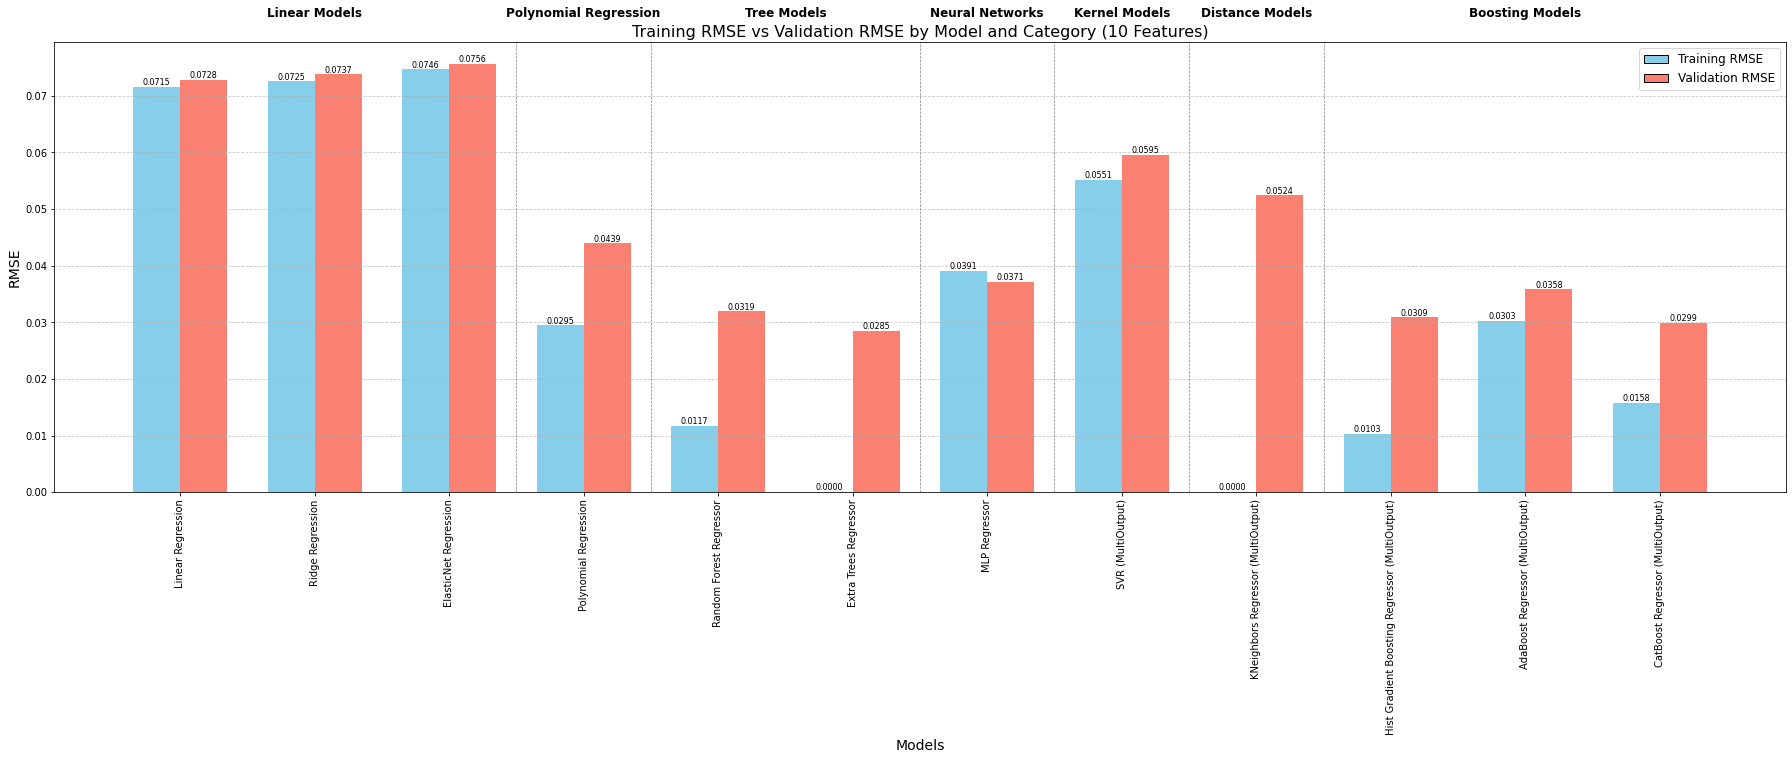

In [215]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Define model categories (same as previous plots)
model_categories = {
    'Linear Models': ['Linear Regression', 'Ridge Regression', 'ElasticNet Regression'],
    'Polynomial Regression': ['Polynomial Regression'],
    'Tree Models': ['Random Forest Regressor', 'Extra Trees Regressor'],
    'Neural Networks': ['MLP Regressor'],
    'Kernel Models': ['SVR (MultiOutput)'],
    'Distance Models': ['KNeighbors Regressor (MultiOutput)'],
    'Boosting Models': [
        'Hist Gradient Boosting Regressor (MultiOutput)',
        'AdaBoost Regressor (MultiOutput)',
        'CatBoost Regressor (MultiOutput)'
    ]
}

# Extract categories
categories = list(model_categories.keys())

# Create a list of models ordered by categories
ordered_models = []
model_to_category = {}
for category in categories:
    for model in model_categories[category]:
        ordered_models.append(model)
        model_to_category[model] = category

n_models = len(ordered_models)

# Extract metrics for each model from results_10_features
train_rmse = []
cv_rmse = []
training_time = []
found_models = []

for model in ordered_models:
    # Search for the model in the results_10_features
    found = False
    for top_level_key in results_10_features:
        if model in results_10_features[top_level_key]:
            metrics = results_10_features[top_level_key][model]
            train_rmse.append(metrics['Training RMSE'])
            cv_rmse.append(metrics['Cross-Validation Mean RMSE'])
            training_time.append(metrics.get('Training Time (seconds)', np.nan))
            found_models.append(model)
            found = True
            break
    if not found:
        # If model not found in results_10_features, append NaN or a placeholder
        train_rmse.append(np.nan)
        cv_rmse.append(np.nan)
        training_time.append(np.nan)
        found_models.append(model)
        print(f"Warning: Metrics for model '{model}' not found in results_10_features.")

# Assign x positions to each model
x = np.arange(n_models)

# Plotting parameters
width = 0.35  # Width of the bars
fig, ax = plt.subplots(figsize=(25, 12))  # Adjusted figure size for better readability

# Colors for Training and Validation RMSE
color_train = 'skyblue'
color_cv = 'salmon'

# Plot Training RMSE
bars1 = ax.bar(x - width/2, train_rmse, width, label='Training RMSE', color=color_train)

# Plot Validation RMSE
bars2 = ax.bar(x + width/2, cv_rmse, width, label='Validation RMSE', color=color_cv)

# Add text labels on top of the bars with horizontal orientation
for bar in bars1 + bars2:
    height = bar.get_height()
    if not np.isnan(height):
        ax.text(
            bar.get_x() + bar.get_width()/2,  # X position: center of the bar
            height,                           # Y position: top of the bar
            f'{height:.4f}',                  # Text: RMSE value
            ha='center',                      # Horizontal alignment
            va='bottom',                      # Vertical alignment
            fontsize=8,                       # Font size
            rotation=0                        # Rotation set to 0 for horizontal text
        )

# Set model names as x-axis labels
ax.set_xticks(x)
ax.set_xticklabels(ordered_models, rotation=90, ha='center', fontsize=10)

# Add category labels above the x-axis labels, centered over their respective models
current_index = 0
for category in categories:
    n = len(model_categories[category])
    if n > 0:
        # Calculate the center position for the category label
        if n == 1:
            center = current_index
        else:
            center = current_index + (n - 1) / 2
        # Adjust the y-position to move category labels higher up
        ax.text(
            center, 
            ax.get_ylim()[1] * 1.05,  # Y position: slightly above the top of the bars
            category, 
            ha='center', 
            va='bottom',
            fontsize=12, 
            fontweight='bold', 
            rotation=0
        )
        current_index += n

# Draw vertical lines to separate categories
current_index = 0
for category in categories:
    n = len(model_categories[category])
    current_index += n
    if current_index < n_models:
        ax.axvline(current_index - 0.5, color='grey', linestyle='--', linewidth=0.7)

# Set labels and title
ax.set_xlabel('Models', fontsize=14)
ax.set_ylabel('RMSE', fontsize=14)
ax.set_title('Training RMSE vs Validation RMSE by Model and Category (10 Features)', fontsize=16)

# Create custom legend
legend_elements = [
    Patch(facecolor=color_train, edgecolor='k', label='Training RMSE'),
    Patch(facecolor=color_cv, edgecolor='k', label='Validation RMSE')
]
ax.legend(handles=legend_elements, fontsize=12)

# Add grid
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout to make room for category labels
plt.tight_layout(rect=[0, 0.05, 1, 0.95])

plt.savefig('training_vs_validation_rmse_10_features.png', format='png', dpi=300, bbox_inches='tight')
plt.show()


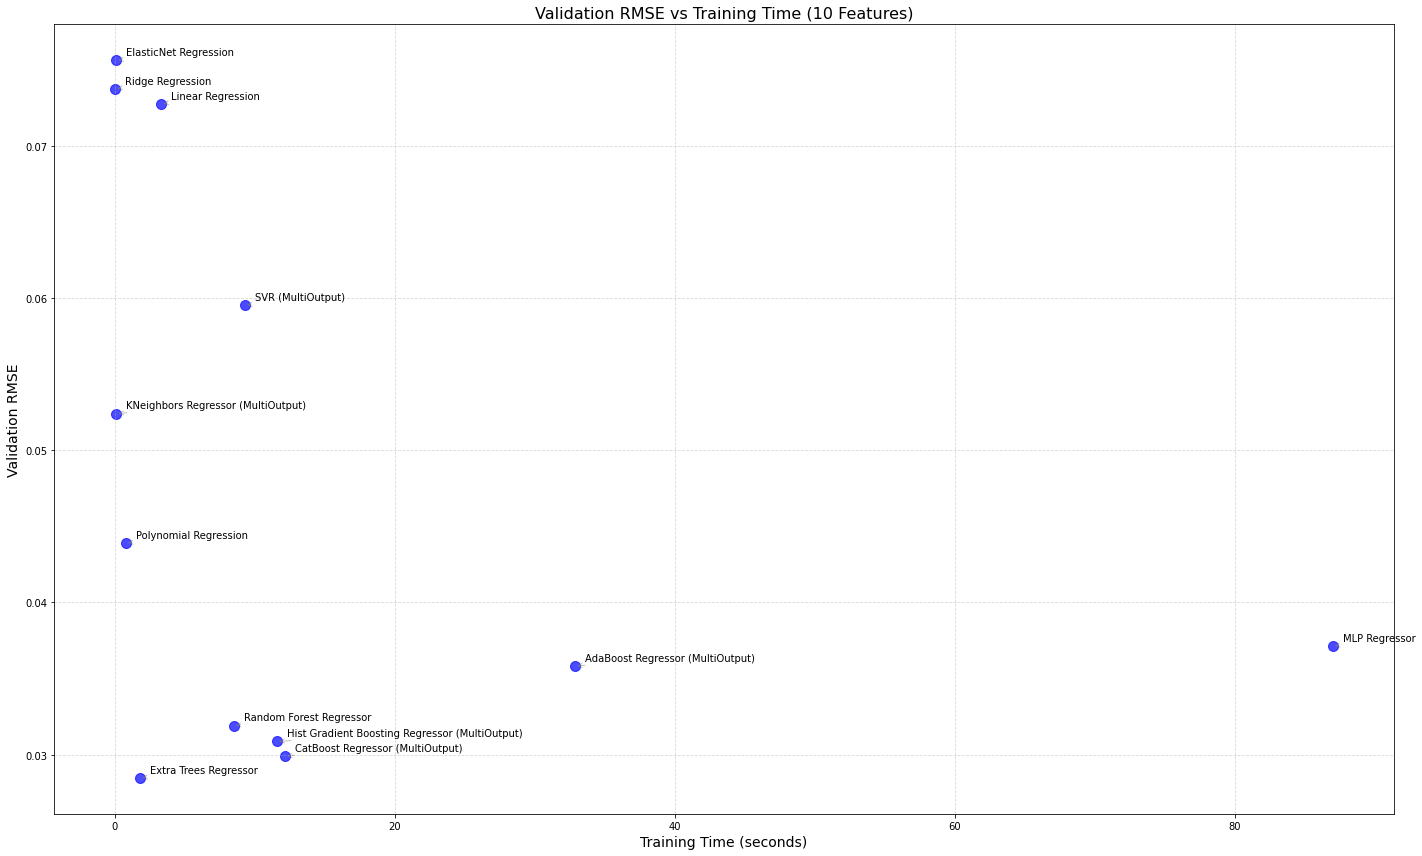

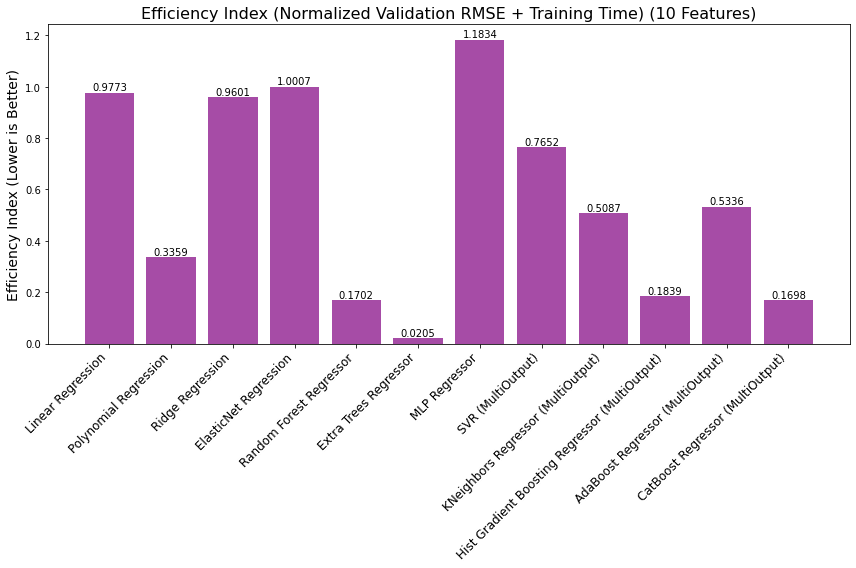

In [117]:
plt.figure(figsize=(20, 12))
plt.scatter(train_time, cv_rmse, color='blue', s=100, alpha=0.7)

for i, model in enumerate(models):
    plt.annotate(
        model,
        (train_time[i], cv_rmse[i]),
        textcoords="offset points",  # Text offset
        xytext=(10, 5),  # Offset distance (x, y)
        ha='left',
        arrowprops=dict(arrowstyle="->", color='gray', alpha=0.5)  # Optional arrow
    )

plt.title('Validation RMSE vs Training Time (10 Features)', fontsize=16)
plt.xlabel('Training Time (seconds)', fontsize=14)
plt.ylabel('Validation RMSE', fontsize=14)
plt.grid(alpha=0.5, linestyle='--')
plt.tight_layout()
plt.show()

# 2. Calculate and plot Efficiency Index for 10 features
# Normalize Validation RMSE and Training Time with range check
min_rmse, max_rmse = min(cv_rmse), max(cv_rmse)
min_time, max_time = min(train_time), max(train_time)

normalized_rmse = [
    (rmse - min_rmse) / (max_rmse - min_rmse) if max_rmse > min_rmse else 0
    for rmse in cv_rmse
]
normalized_time = [
    (time - min_time) / (max_time - min_time) if max_time > min_time else 0
    for time in train_time
]

# Calculate Efficiency Index
efficiency_index = [rmse + time for rmse, time in zip(normalized_rmse, normalized_time)]

# Plot Efficiency Index for 10 features
plt.figure(figsize=(12, 8))
bars = plt.bar(models, efficiency_index, color='purple', alpha=0.7)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.ylabel('Efficiency Index (Lower is Better)', fontsize=14)
plt.title('Efficiency Index (Normalized Validation RMSE + Training Time) (10 Features)', fontsize=16)

# Annotate bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.4f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

In [118]:
models_sfs = {
    model_name: params['Best Parameters']['model'] 
    for category in results_10_features.values() 
    for model_name, params in category.items()
}

print("Models for SFS:", models_sfs)

# Iterate through each model and select 5 features from the 10 features
for model_name, model in models_sfs.items():
    # Get the 10 selected features for this model
    if model_name not in selected_features_dict['10 features']:
        print(f"No 10 features found for {model_name}, skipping...")
        continue
    
    selected_10_features = selected_features_dict['10 features'][model_name]
    
    # Reduce X_train to only the 10 selected features
    X_train_10 = X_train[selected_10_features]
    
    # Run SFS to select the top 5 features from the 10 selected features
    print(f"Starting SFS for {model_name} with 10 features to select top 5...")
    sfs = SequentialFeatureSelector(
        model, 
        n_features_to_select=5, 
        direction='forward', 
        scoring='neg_mean_squared_error', 
        cv=5, 
        n_jobs=-1
    )
    
    sfs.fit(X_train_10, y_train)
    
    # Extract the 5 selected features from the original 10
    selected_features_5 = [feature for i, feature in enumerate(selected_10_features) if sfs.get_support()[i]]
    selected_features_dict['5 features'][model_name] = selected_features_5
    
    print(f"Completed {model_name} with 5 features: {selected_features_5}")


Models for SFS: {'Linear Regression': LinearRegression(), 'Polynomial Regression': Pipeline(steps=[('poly', PolynomialFeatures(degree=3, interaction_only=True)),
                ('linear', LinearRegression())]), 'Ridge Regression': Ridge(alpha=5.623413251903491), 'ElasticNet Regression': ElasticNet(alpha=0.001, max_iter=10000), 'Random Forest Regressor': RandomForestRegressor(n_estimators=200, random_state=42), 'Extra Trees Regressor': ExtraTreesRegressor(n_estimators=200, random_state=42), 'MLP Regressor': MLPRegressor(alpha=0.1, early_stopping=True, hidden_layer_sizes=(50, 50),
             learning_rate_init=0.01, max_iter=10000, random_state=42), 'SVR (MultiOutput)': MultiOutputRegressor(estimator=SVR(C=0.31622776601683794)), 'KNeighbors Regressor (MultiOutput)': MultiOutputRegressor(estimator=KNeighborsRegressor(weights='distance')), 'Hist Gradient Boosting Regressor (MultiOutput)': MultiOutputRegressor(estimator=HistGradientBoostingRegressor(random_state=42)), 'AdaBoost Regressor

In [119]:
selected_features_dict

{'5 features': {'Linear Regression': ['Feature_10',
   'Feature_17',
   'Feature_18',
   'Feature_20',
   'Feature_22'],
  'Polynomial Regression': ['Feature_1',
   'Feature_2',
   'Feature_17',
   'Feature_18',
   'Feature_19'],
  'Ridge Regression': ['Feature_1',
   'Feature_7',
   'Feature_12',
   'Feature_13',
   'Feature_18'],
  'ElasticNet Regression': ['Feature_1',
   'Feature_7',
   'Feature_13',
   'Feature_18',
   'Feature_32'],
  'Random Forest Regressor': ['Feature_12',
   'Feature_18',
   'Feature_19',
   'Feature_21',
   'Feature_45'],
  'Extra Trees Regressor': ['Feature_12',
   'Feature_18',
   'Feature_19',
   'Feature_20',
   'Feature_45'],
  'MLP Regressor': ['Feature_4',
   'Feature_17',
   'Feature_18',
   'Feature_19',
   'Feature_20'],
  'SVR (MultiOutput)': ['Feature_17',
   'Feature_18',
   'Feature_19',
   'Feature_32',
   'Feature_37'],
  'KNeighbors Regressor (MultiOutput)': ['Feature_12',
   'Feature_18',
   'Feature_19',
   'Feature_20',
   'Feature_44'],


In [128]:
model_param_grid_non_inherent = {
    'SVR (MultiOutput)': {
        'model__estimator__kernel': ['linear', 'rbf'],
        'model__estimator__C': np.logspace(-3, 2, 5),
        'base_model': SVR()  # Base estimator for MultiOutputRegressor
    },
    'KNeighbors Regressor (MultiOutput)': {
        'model__estimator__n_neighbors': [3, 5, 10],
        'model__estimator__weights': ['uniform', 'distance'],
        'base_model': KNeighborsRegressor()
    },
    'Hist Gradient Boosting Regressor (MultiOutput)': {
        'model__estimator__max_iter': [100, 200],
        'model__estimator__learning_rate': np.logspace(-3, 0, 4),
        'base_model': HistGradientBoostingRegressor(random_state=42)
    },
    'AdaBoost Regressor (MultiOutput)': {
        'base_model': AdaBoostRegressor(random_state=42),
        'model__estimator__n_estimators': [50, 100, 200],  # Number of trees
        'model__estimator__learning_rate': [0.01, 0.1, 1.0],  # Learning rate for the updates
        'model__estimator__loss': ['linear', 'square', 'exponential']  # Different loss functions for residuals
    },
    'CatBoost Regressor (MultiOutput)': {
        'base_model': CatBoostRegressor(verbose=0, random_state=42),
        'model__estimator__iterations': [50, 100],  # Reduced iterations
        'model__estimator__learning_rate': [0.01, 0.1],  # Reduced learning rate range
        'model__estimator__depth': [3, 5],  # Remove depth 10
        'model__estimator__l2_leaf_reg': [0.1, 1, 10],  # Reduce l2_leaf_reg
        'model__estimator__od_type': ['Iter'],  # Early stopping
        'model__estimator__od_wait': [20]  # Early stopping patience
    }
}
results_5_features = {'Inherently Multi-Output': {}, 'Single-Output (adapted to Multi-Output)': {}}

# Train inherently multi-output models
for name, param_grid in model_param_grid.items():
    print(f"Tuning and evaluating: {name}")
    
    # Get 5 selected features for the current model
    selected_features = selected_features_dict['5 features'].get(name, X_train_val.columns)  # Get 5 features or use all
    X_train_val_selected = X_train_val[selected_features]  # Select the 5 features
    X_train_val_scaled = pd.DataFrame(scaler.fit_transform(X_train_val_selected), columns=X_train_val_selected.columns)
    
    pipeline = Pipeline([('model', param_grid['model'][0])])  # Start with the model from the grid
    
    grid = GridSearchCV(pipeline, param_grid, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)
    
    start_time = time.time()
    grid.fit(X_train_val_scaled, y_train_val)
    end_time = time.time()
    training_time = end_time - start_time
    
    best_params = clean_params_with_model(grid)

    best_neg_mse = grid.best_score_
    best_mse = -best_neg_mse  # Convert to positive
    best_rmse = np.sqrt(best_mse)

    train_predictions = grid.best_estimator_.predict(X_train_val_scaled)
    train_mse = mean_squared_error(y_train_val, train_predictions)
    train_rmse = np.sqrt(train_mse)
    
    results_5_features['Inherently Multi-Output'][name] = {
        'Best Parameters': best_params,
        'Cross-Validation Mean MSE': best_mse,
        'Cross-Validation Mean RMSE': best_rmse,
        'Training RMSE': train_rmse,
        'Training Time (seconds)': training_time
    }

# Train single-output models adapted to multi-output

for name, param_grids in model_param_grid_non_inherent.items():
    print(f"Tuning and evaluating: {name}")
    
    # Get 5 selected features for the current model
    selected_features = selected_features_dict['5 features'].get(name, X_train_val.columns)  # Get 5 features or use all
    X_train_val_selected = X_train_val[selected_features]  # Select the 5 features
    X_train_val_scaled = pd.DataFrame(scaler.fit_transform(X_train_val_selected), columns=X_train_val_selected.columns)
    
    base_model = MultiOutputRegressor(param_grids.pop('base_model'))
    print(base_model)
    
    pipeline = Pipeline([('scaler', StandardScaler()), ('model', base_model)])
    
    grid = GridSearchCV(pipeline, param_grids, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)
    
    start_time = time.time()
    grid.fit(X_train_val_scaled, y_train_val)
    end_time = time.time()
    training_time = end_time - start_time
    
    best_params = clean_params_with_model(grid)
    
    best_neg_mse = grid.best_score_
    best_mse = -best_neg_mse  # Convert to positive
    best_rmse = np.sqrt(best_mse)
    
    train_predictions = grid.best_estimator_.predict(X_train_val_scaled)
    train_mse = mean_squared_error(y_train_val, train_predictions)
    train_rmse = np.sqrt(train_mse)
    
    results_5_features['Single-Output (adapted to Multi-Output)'][name] = {
        'Best Parameters': best_params,
        'Cross-Validation Mean MSE': best_mse,
        'Cross-Validation Mean RMSE': best_rmse,
        'Training RMSE': train_rmse,
        'Training Time (seconds)': training_time
    }

Tuning and evaluating: Linear Regression
Tuning and evaluating: Polynomial Regression
Tuning and evaluating: Ridge Regression
Tuning and evaluating: ElasticNet Regression
Tuning and evaluating: Random Forest Regressor
Tuning and evaluating: Extra Trees Regressor
Tuning and evaluating: MLP Regressor
Tuning and evaluating: SVR (MultiOutput)
MultiOutputRegressor(estimator=SVR())
Tuning and evaluating: KNeighbors Regressor (MultiOutput)
MultiOutputRegressor(estimator=KNeighborsRegressor())
Tuning and evaluating: Hist Gradient Boosting Regressor (MultiOutput)
MultiOutputRegressor(estimator=HistGradientBoostingRegressor(random_state=42))
Tuning and evaluating: AdaBoost Regressor (MultiOutput)
MultiOutputRegressor(estimator=AdaBoostRegressor(random_state=42))
Tuning and evaluating: CatBoost Regressor (MultiOutput)
MultiOutputRegressor(estimator=<catboost.core.CatBoostRegressor object at 0x7fbed479cc10>)


In [129]:
results_5_features

{'Inherently Multi-Output': {'Linear Regression': {'Best Parameters': {'model': LinearRegression()},
   'Cross-Validation Mean MSE': 0.005928789104060422,
   'Cross-Validation Mean RMSE': 0.07699863053366873,
   'Training RMSE': 0.07608709075698908,
   'Training Time (seconds)': 0.02122187614440918},
  'Polynomial Regression': {'Best Parameters': {'model': Pipeline(steps=[('poly', PolynomialFeatures(degree=3)),
                    ('linear', LinearRegression())]),
    'degree': 3,
    'interaction_only': False},
   'Cross-Validation Mean MSE': 0.002463602683678021,
   'Cross-Validation Mean RMSE': 0.04963469233991504,
   'Training RMSE': 0.04507821889377535,
   'Training Time (seconds)': 0.07469630241394043},
  'Ridge Regression': {'Best Parameters': {'model': Ridge(alpha=0.31622776601683794),
    'alpha': 0.31622776601683794},
   'Cross-Validation Mean MSE': 0.006595103622585326,
   'Cross-Validation Mean RMSE': 0.08121024333534117,
   'Training RMSE': 0.08068278413752664,
   'Trainin

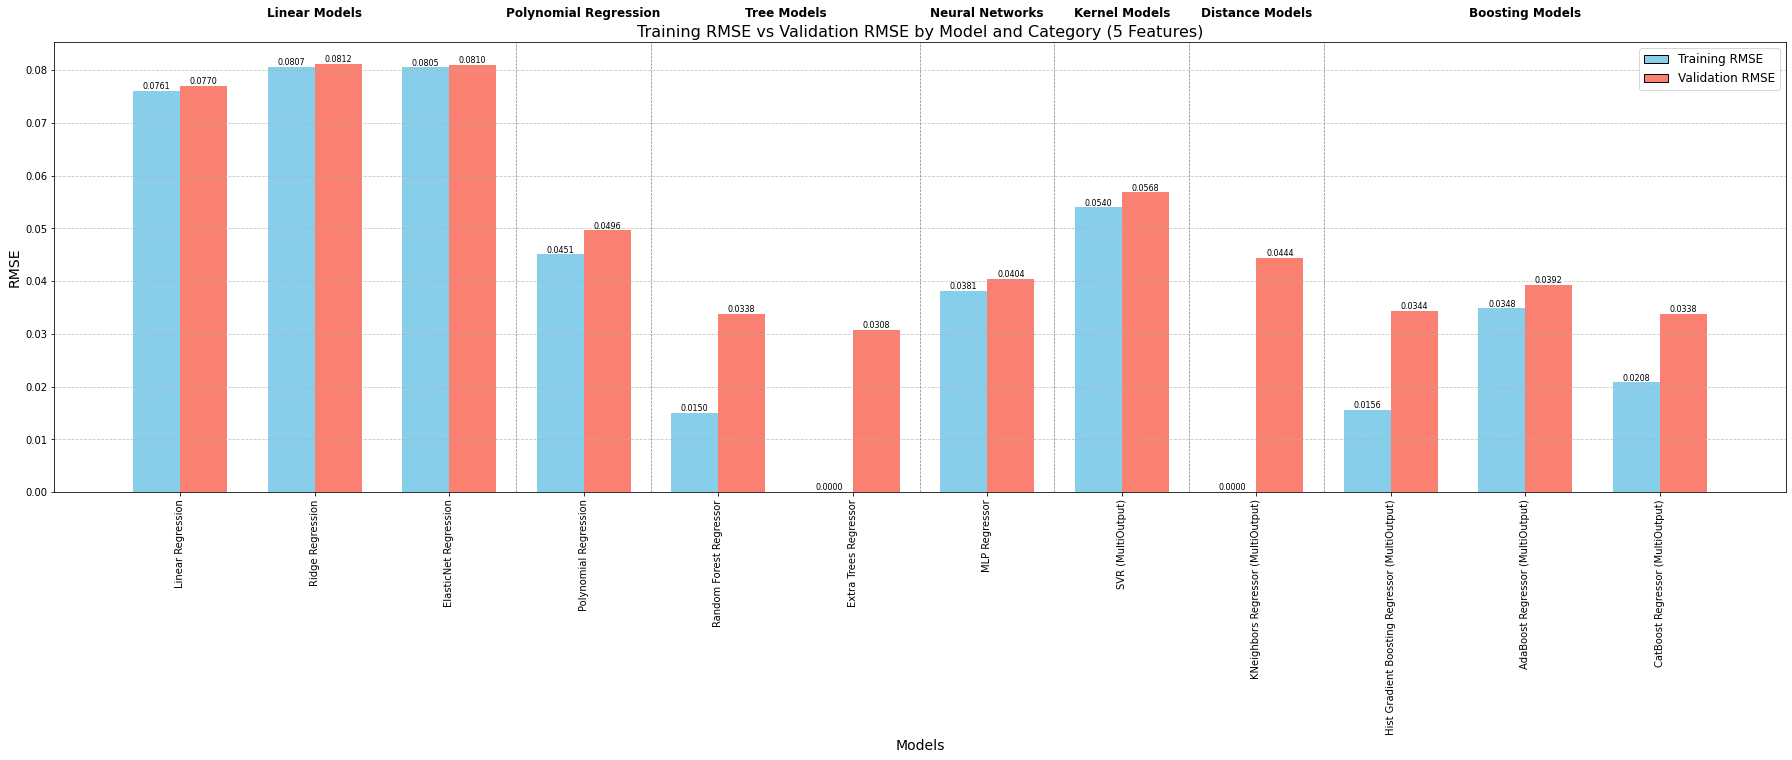

In [216]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Define model categories (consistent with previous plots)
model_categories = {
    'Linear Models': ['Linear Regression', 'Ridge Regression', 'ElasticNet Regression'],
    'Polynomial Regression': ['Polynomial Regression'],
    'Tree Models': ['Random Forest Regressor', 'Extra Trees Regressor'],
    'Neural Networks': ['MLP Regressor'],
    'Kernel Models': ['SVR (MultiOutput)'],
    'Distance Models': ['KNeighbors Regressor (MultiOutput)'],
    'Boosting Models': [
        'Hist Gradient Boosting Regressor (MultiOutput)',
        'AdaBoost Regressor (MultiOutput)',
        'CatBoost Regressor (MultiOutput)'
    ]
}

# Extract categories
categories = list(model_categories.keys())

# Create a list of models ordered by categories
ordered_models = []
model_to_category = {}
for category in categories:
    for model in model_categories[category]:
        ordered_models.append(model)
        model_to_category[model] = category

n_models = len(ordered_models)

# Extract metrics for each model from results_5_features
train_rmse = []
cv_rmse = []
training_time = []
found_models = []

for model in ordered_models:
    # Search for the model in the results_5_features
    found = False
    for top_level_key in results_5_features:
        if model in results_5_features[top_level_key]:
            metrics = results_5_features[top_level_key][model]
            train_rmse.append(metrics['Training RMSE'])
            cv_rmse.append(metrics['Cross-Validation Mean RMSE'])
            training_time.append(metrics.get('Training Time (seconds)', np.nan))
            found_models.append(model)
            found = True
            break
    if not found:
        # If model not found in results_5_features, append NaN or a placeholder
        train_rmse.append(np.nan)
        cv_rmse.append(np.nan)
        training_time.append(np.nan)
        found_models.append(model)
        print(f"Warning: Metrics for model '{model}' not found in results_5_features.")

# Assign x positions to each model
x = np.arange(n_models)

# Plotting parameters
width = 0.35  # Width of the bars
fig, ax = plt.subplots(figsize=(25, 12))  # Adjusted figure size for better readability

# Colors for Training and Validation RMSE
color_train = 'skyblue'
color_cv = 'salmon'

# Plot Training RMSE
bars1 = ax.bar(x - width/2, train_rmse, width, label='Training RMSE', color=color_train)

# Plot Validation RMSE
bars2 = ax.bar(x + width/2, cv_rmse, width, label='Validation RMSE', color=color_cv)

# Add text labels on top of the bars with horizontal orientation
for bar in bars1 + bars2:
    height = bar.get_height()
    if not np.isnan(height):
        ax.text(
            bar.get_x() + bar.get_width()/2,  # X position: center of the bar
            height,                           # Y position: top of the bar
            f'{height:.4f}',                  # Text: RMSE value
            ha='center',                      # Horizontal alignment
            va='bottom',                      # Vertical alignment
            fontsize=8,                       # Font size
            rotation=0                        # Rotation set to 0 for horizontal text
        )

# Set model names as x-axis labels
ax.set_xticks(x)
ax.set_xticklabels(ordered_models, rotation=90, ha='center', fontsize=10)

# Add category labels above the x-axis labels, centered over their respective models
current_index = 0
for category in categories:
    n = len(model_categories[category])
    if n > 0:
        # Calculate the center position for the category label
        if n == 1:
            center = current_index
        else:
            center = current_index + (n - 1) / 2
        # Adjust the y-position to move category labels higher up
        ax.text(
            center, 
            ax.get_ylim()[1] * 1.05,  # Y position: slightly above the top of the bars
            category, 
            ha='center', 
            va='bottom',
            fontsize=12, 
            fontweight='bold', 
            rotation=0
        )
        current_index += n

# Draw vertical lines to separate categories
current_index = 0
for category in categories:
    n = len(model_categories[category])
    current_index += n
    if current_index < n_models:
        ax.axvline(current_index - 0.5, color='grey', linestyle='--', linewidth=0.7)

# Set labels and title
ax.set_xlabel('Models', fontsize=14)
ax.set_ylabel('RMSE', fontsize=14)
ax.set_title('Training RMSE vs Validation RMSE by Model and Category (5 Features)', fontsize=16)

# Create custom legend
legend_elements = [
    Patch(facecolor=color_train, edgecolor='k', label='Training RMSE'),
    Patch(facecolor=color_cv, edgecolor='k', label='Validation RMSE')
]
ax.legend(handles=legend_elements, fontsize=12)

# Add grid
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout to make room for category labels
plt.tight_layout(rect=[0, 0.05, 1, 0.95])

plt.savefig('training_vs_validation_rmse_5_features.png', format='png', dpi=300, bbox_inches='tight')
plt.show()


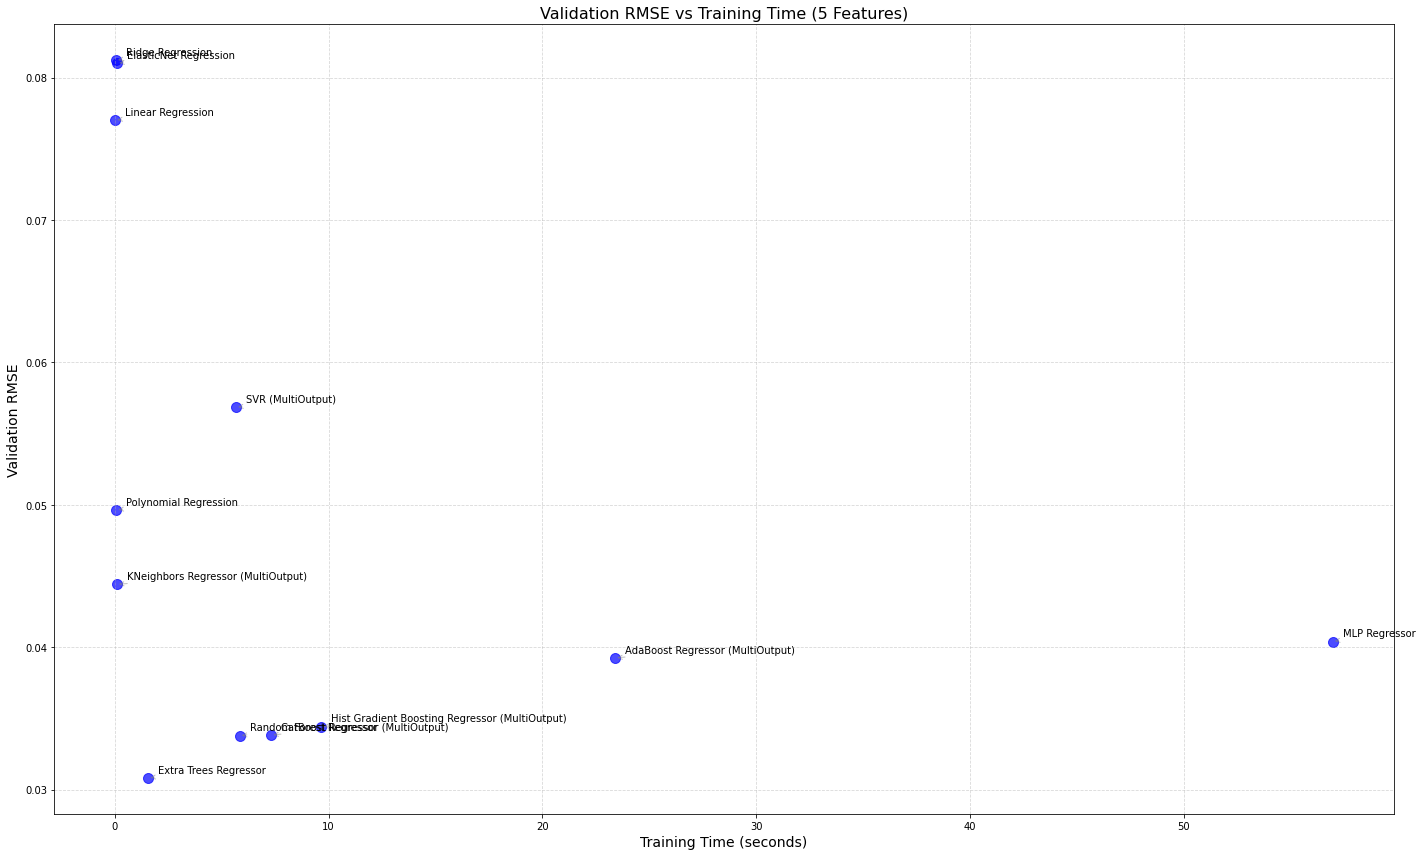

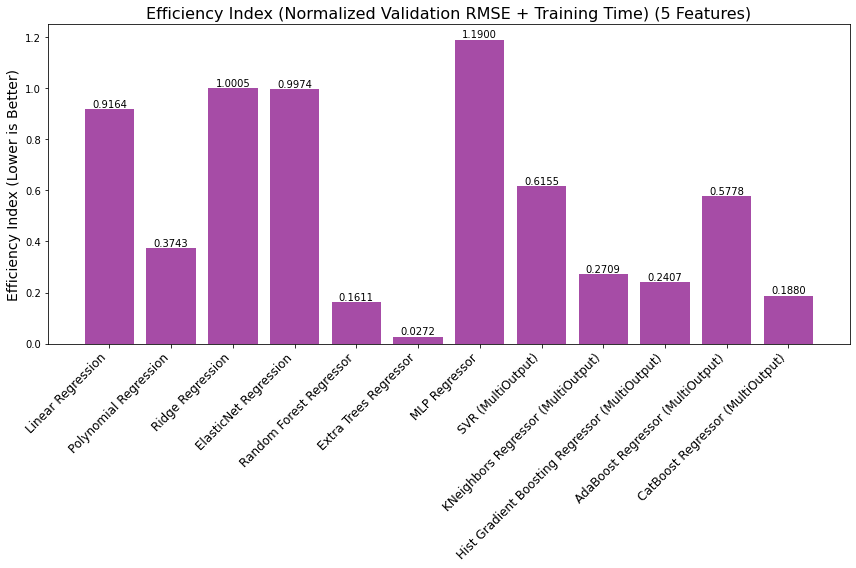

In [131]:
plt.figure(figsize=(20, 12))
plt.scatter(train_time, cv_rmse, color='blue', s=100, alpha=0.7)

for i, model in enumerate(models):
    plt.annotate(
        model,
        (train_time[i], cv_rmse[i]),
        textcoords="offset points",  # Text offset
        xytext=(10, 5),  # Offset distance (x, y)
        ha='left',
        arrowprops=dict(arrowstyle="->", color='gray', alpha=0.5)  # Optional arrow
    )

plt.title('Validation RMSE vs Training Time (5 Features)', fontsize=16)
plt.xlabel('Training Time (seconds)', fontsize=14)
plt.ylabel('Validation RMSE', fontsize=14)
plt.grid(alpha=0.5, linestyle='--')
plt.tight_layout()
plt.show()

# 2. Calculate and plot Efficiency Index for 5 features
# Normalize Validation RMSE and Training Time with range check
min_rmse, max_rmse = min(cv_rmse), max(cv_rmse)
min_time, max_time = min(train_time), max(train_time)

normalized_rmse = [
    (rmse - min_rmse) / (max_rmse - min_rmse) if max_rmse > min_rmse else 0
    for rmse in cv_rmse
]
normalized_time = [
    (time - min_time) / (max_time - min_time) if max_time > min_time else 0
    for time in train_time
]

# Calculate Efficiency Index
efficiency_index = [rmse + time for rmse, time in zip(normalized_rmse, normalized_time)]

# Plot Efficiency Index for 5 features
plt.figure(figsize=(12, 8))
bars = plt.bar(models, efficiency_index, color='purple', alpha=0.7)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.ylabel('Efficiency Index (Lower is Better)', fontsize=14)
plt.title('Efficiency Index (Normalized Validation RMSE + Training Time) (5 Features)', fontsize=16)

# Annotate bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.4f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

In [96]:

# Function to get the most common features
def get_most_voted_features(selected_features_dict, num_features):
    most_voted_dict = {}
    for key, model_features in selected_features_dict.items():
        if key.startswith(f'{num_features} features'):
            all_features = [feature for features in model_features.values() for feature in features]
            feature_counts = Counter(all_features)
            most_common_features = [feature for feature, _ in feature_counts.most_common(num_features)]
            most_voted_dict[key] = most_common_features
    return most_voted_dict

most_voted_5 = get_most_voted_features(selected_features_dict, 5)
most_voted_10 = get_most_voted_features(selected_features_dict, 10)
most_voted_15 = get_most_voted_features(selected_features_dict, 15)

selected_features_dict['5 features']["Most voted"] = most_voted_5['5 features']
selected_features_dict['10 features']["Most voted"] = most_voted_10['10 features']
selected_features_dict['15 features']["Most voted"] = most_voted_15['15 features']



<Axes: >

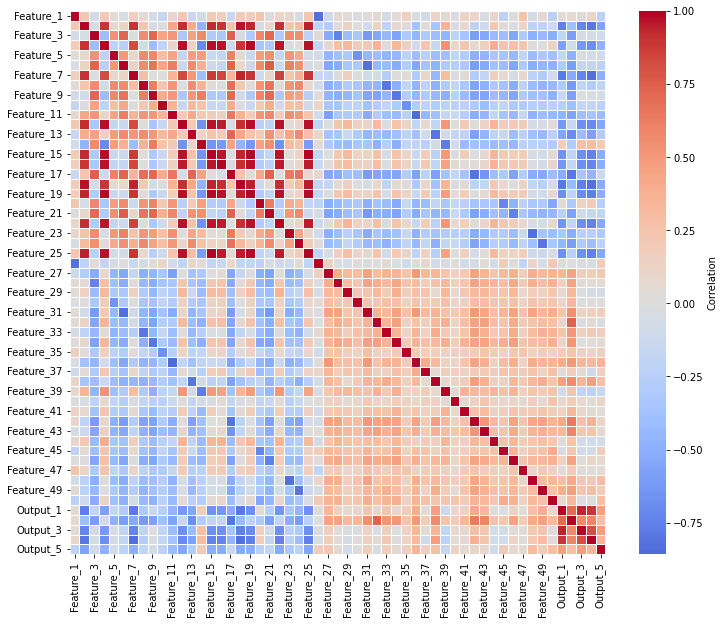

In [37]:

X_y_train_val = pd.concat([X_train_val, y_train_val], axis=1)

# Generate and display a correlation heatmap
correlation_matrix = X_y_train_val.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, 
            annot=False,         # Set True to display the correlation values
            cmap='coolwarm',     # Color map for correlations
            center=0,            # Center the color bar at zero
            linewidths=0.5,      # Add gridlines for clarity
            cbar_kws={'label': 'Correlation'})

In [241]:
# Combine training and validation sets
scaler = StandardScaler()
X_train_val = pd.concat([X_train, X_val])
y_train_val = pd.concat([y_train, y_val])
X_train_val_scaled = pd.DataFrame(scaler.fit_transform(X_train_val), columns=X_train_val.columns)
y_train_val_np = y_train_val.values if isinstance(y_train_val, pd.DataFrame) else y_train_val

# Filter for Average MI
model_name = "Avg MI"
mi_scores_per_output = np.zeros((y_train_val_np.shape[1], X_train_val_scaled.shape[1]))

for i in range(y_train_val_np.shape[1]):
    mi_scores_per_output[i, :] = mutual_info_regression(X_train_val_scaled, y_train_val_np[:, i])

mi_scores_avg = np.mean(mi_scores_per_output, axis=0)
sorted_indices = np.argsort(mi_scores_avg)[::-1]

selected_features_dict['5 features'][model_name] = [f'Feature_{i+1}' for i in sorted_indices[:5]]
selected_features_dict['10 features'][model_name] = [f'Feature_{i+1}' for i in sorted_indices[:10]]
selected_features_dict['15 features'][model_name] = [f'Feature_{i+1}' for i in sorted_indices[:15]]

# Filter for Average MIC
model_name = "Avg MIC"
mic_scores_per_output = np.zeros((y_train_val_np.shape[1], X_train_val_scaled.shape[1]))
mine = MINE()

for i in range(y_train_val_np.shape[1]):
    for j in range(X_train_val_scaled.shape[1]):
        mine.compute_score(X_train_val_scaled.iloc[:, j], y_train_val_np[:, i])
        mic_scores_per_output[i, j] = mine.mic()

mic_scores_avg = np.mean(mic_scores_per_output, axis=0)
sorted_indices = np.argsort(mic_scores_avg)[::-1]

selected_features_dict['5 features'][model_name] = [f'Feature_{i+1}' for i in sorted_indices[:5]]
selected_features_dict['10 features'][model_name] = [f'Feature_{i+1}' for i in sorted_indices[:10]]
selected_features_dict['15 features'][model_name] = [f'Feature_{i+1}' for i in sorted_indices[:15]]

# Filter for Average Correlation
model_name = "Avg Correlation"
correlation_scores_per_output = np.zeros((y_train_val_np.shape[1], X_train_val_scaled.shape[1]))

for output in range(y_train_val_np.shape[1]):
    corr_scores = [
        np.corrcoef(X_train_val_scaled.iloc[:, i], y_train_val_np[:, output])[0, 1]
        for i in range(X_train_val_scaled.shape[1])
    ]
    correlation_scores_per_output[output, :] = np.nan_to_num(corr_scores)

correlation_scores_avg = np.mean(np.abs(correlation_scores_per_output), axis=0)
sorted_indices = np.argsort(correlation_scores_avg)[::-1]

selected_features_dict['5 features'][model_name] = [f'Feature_{i+1}' for i in sorted_indices[:5]]
selected_features_dict['10 features'][model_name] = [f'Feature_{i+1}' for i in sorted_indices[:10]]
selected_features_dict['15 features'][model_name] = [f'Feature_{i+1}' for i in sorted_indices[:15]]

# Filter for Average ANOVA F-value
model_name = "Avg ANOVA F-value"
f_scores_per_output = np.zeros((y_train_val_np.shape[1], X_train_val_scaled.shape[1]))

for output in range(y_train_val_np.shape[1]):
    f_stat, _ = f_regression(X_train_val_scaled, y_train_val_np[:, output])
    f_scores_per_output[output, :] = f_stat

f_scores_avg = np.mean(f_scores_per_output, axis=0)
sorted_indices = np.argsort(f_scores_avg)[::-1]

selected_features_dict['5 features'][model_name] = [f'Feature_{i+1}' for i in sorted_indices[:5]]
selected_features_dict['10 features'][model_name] = [f'Feature_{i+1}' for i in sorted_indices[:10]]
selected_features_dict['15 features'][model_name] = [f'Feature_{i+1}' for i in sorted_indices[:15]]

# Filter for Average Distance Correlation
model_name = "Avg Distance Correlation"
dcor_scores_per_output = np.zeros((y_train_val_np.shape[1], X_train_val_scaled.shape[1]))

for output in range(y_train_val_np.shape[1]):
    dcor_scores = [
        dcor.distance_correlation(X_train_val_scaled.iloc[:, i], y_train_val_np[:, output])
        for i in range(X_train_val_scaled.shape[1])
    ]
    dcor_scores_per_output[output, :] = dcor_scores

dcor_scores_avg = np.mean(dcor_scores_per_output, axis=0)
sorted_indices = np.argsort(dcor_scores_avg)[::-1]

# Select top features
selected_features_dict['5 features'][model_name] = [f'Feature_{i+1}' for i in sorted_indices[:5]]
selected_features_dict['10 features'][model_name] = [f'Feature_{i+1}' for i in sorted_indices[:10]]
selected_features_dict['15 features'][model_name] = [f'Feature_{i+1}' for i in sorted_indices[:15]]

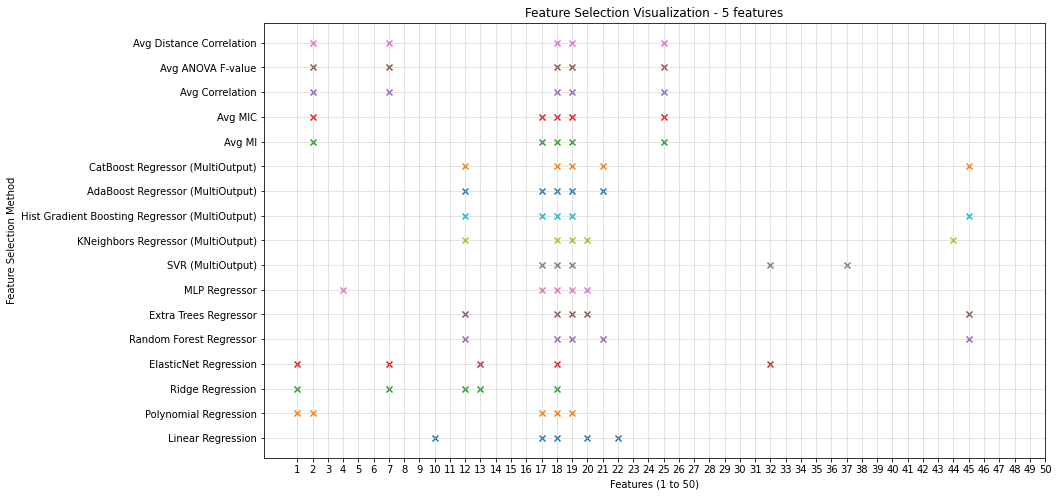

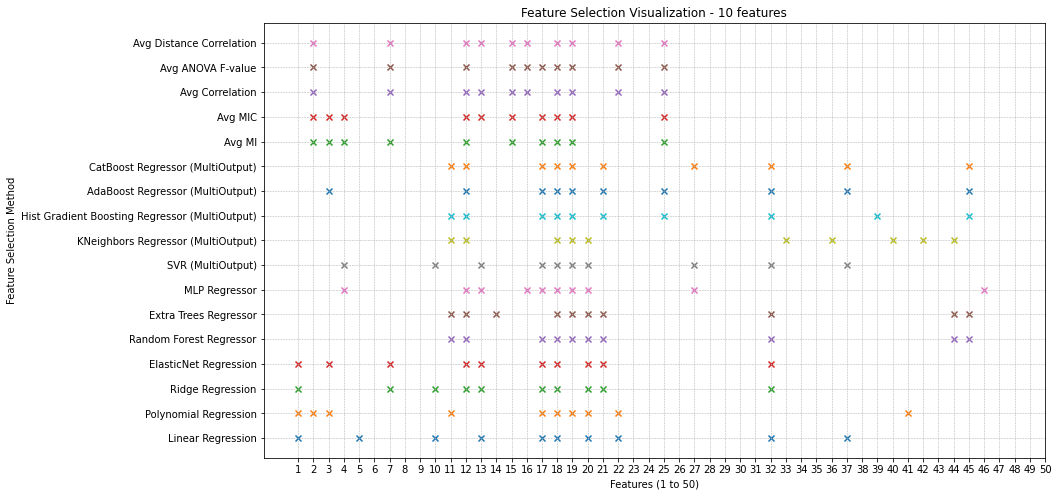

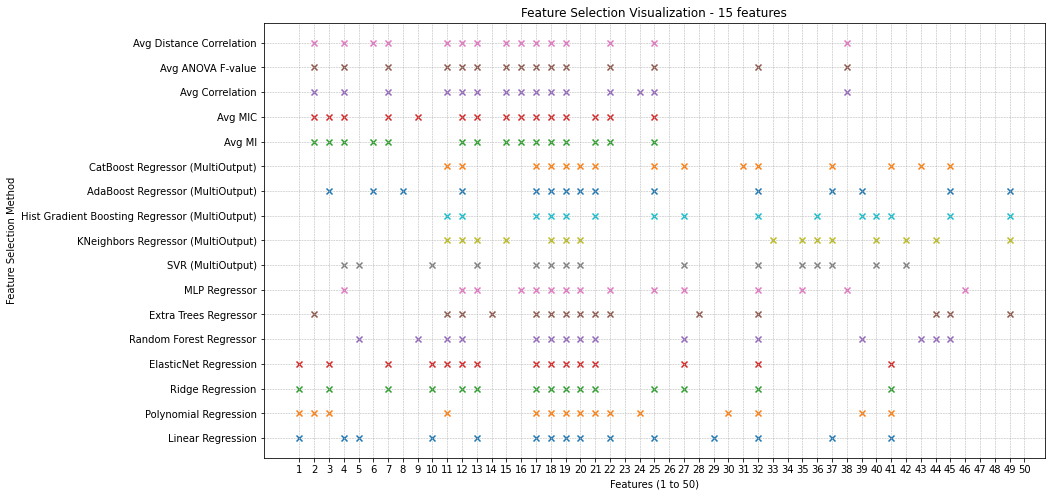

In [242]:
feature_to_index = {f'Feature_{i+1}': i+1 for i in range(50)}

# Function to plot selected features for a given section
def plot_selected_features(section, selected_features):
    plt.figure(figsize=(14, 8))
    x_axis = np.arange(1, 51)  # x-axis for 50 features
    y_offset = 0  # Used to differentiate models vertically on the y-axis

    for model_name, features in selected_features.items():
        # Convert feature names to their numeric indices for plotting
        numeric_features = [feature_to_index[feature] for feature in features if feature in feature_to_index]
        y = np.full(len(numeric_features), y_offset)
        plt.scatter(numeric_features, y, marker='x', label=model_name)
        y_offset += 1

    plt.yticks(range(y_offset), list(selected_features.keys()))
    plt.xticks(x_axis)
    plt.xlabel('Features (1 to 50)')
    plt.ylabel('Feature Selection Method')
    plt.title(f'Feature Selection Visualization - {section}')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()

# Plot each section separately
for section, features in selected_features_dict.items():
    plot_selected_features(section, features)


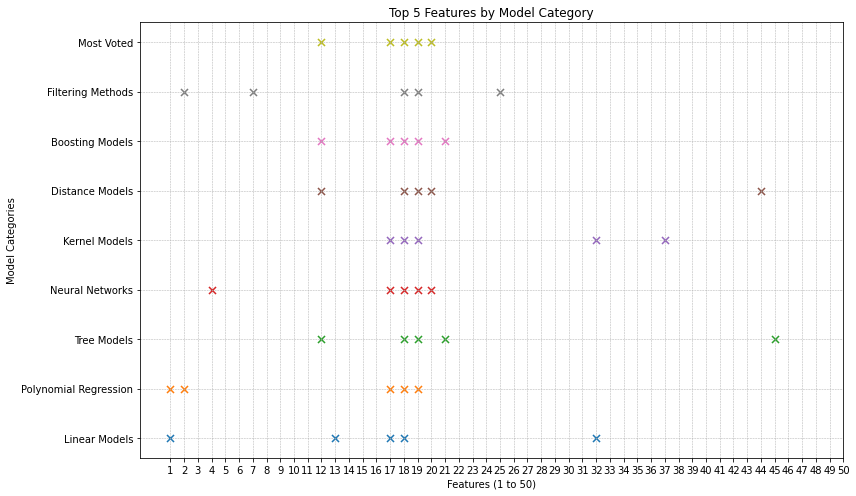

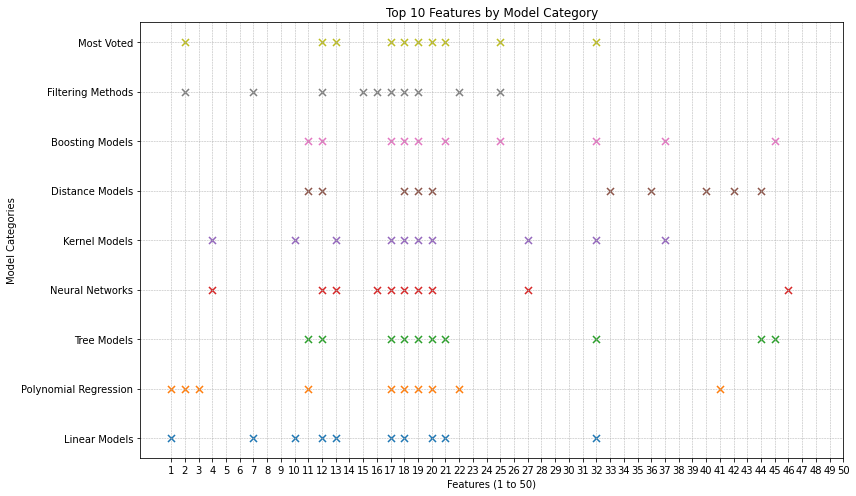

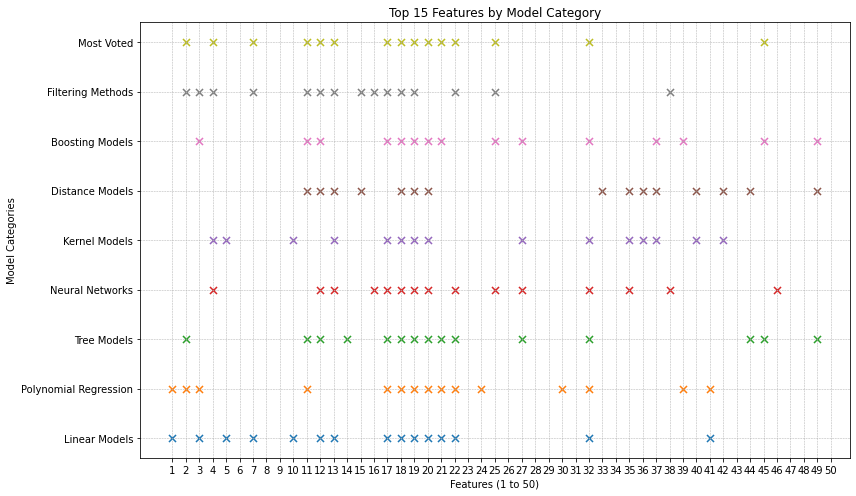

In [254]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Map features to their indices (1 to 50)
feature_to_index = {f'Feature_{i+1}': i+1 for i in range(50)}

# Define the model categories
model_categories = {
    'Linear Models': ['Linear Regression', 'Ridge Regression', 'ElasticNet Regression'],
    'Polynomial Regression': ['Polynomial Regression'],
    'Tree Models': ['Random Forest Regressor', 'Extra Trees Regressor'],
    'Neural Networks': ['MLP Regressor'],
    'Kernel Models': ['SVR (MultiOutput)'],
    'Distance Models': ['KNeighbors Regressor (MultiOutput)'],
    'Boosting Models': [
        'Hist Gradient Boosting Regressor (MultiOutput)',
        'AdaBoost Regressor (MultiOutput)',
        'CatBoost Regressor (MultiOutput)'
    ],
    'Filtering Methods': ['Avg MI', 'Avg MIC', 'Avg Correlation', 'Avg Distance Correlation', 'Avg ANOVA F-value']
}

# Function to calculate votes for features for a specific model category
def calculate_aggregate_votes_for_category(selected_features, models_in_category):
    """ Counts how many times each feature is selected by models in the same category. """
    feature_votes = np.zeros(50)  # 50 features indexed from 0 to 49
    for model_name in models_in_category:
        for feature_set_name, feature_set in selected_features.items():
            if model_name in feature_set:
                for feature in feature_set[model_name]:
                    if feature in feature_to_index:
                        feature_index = feature_to_index[feature] - 1  # Convert 1-based index to 0-based
                        feature_votes[feature_index] += 1
    return feature_votes

# Calculate votes for each model category
votes_by_category = {}
for category, models in model_categories.items():
    votes_by_category[category] = calculate_aggregate_votes_for_category(selected_features_dict, models)

# Calculate total votes for the "Most Voted" section
most_voted_aggregate = np.sum(list(votes_by_category.values()), axis=0)

# Determine the top 5, 10, or 15 features for each category
top_features_by_category = {}
for category, votes in votes_by_category.items():
    top_5_features = np.argsort(votes)[-5:][::-1] + 1  # Top 5 features (1-based index)
    top_10_features = np.argsort(votes)[-10:][::-1] + 1  # Top 10 features (1-based index)
    top_15_features = np.argsort(votes)[-15:][::-1] + 1  # Top 15 features (1-based index)
    top_features_by_category[category] = {
        'top_5': top_5_features,
        'top_10': top_10_features,
        'top_15': top_15_features
    }

# Calculate top features for the "Most Voted" section
top_features_by_category['Most Voted'] = {
    'top_5': np.argsort(most_voted_aggregate)[-5:][::-1] + 1,
    'top_10': np.argsort(most_voted_aggregate)[-10:][::-1] + 1,
    'top_15': np.argsort(most_voted_aggregate)[-15:][::-1] + 1
}

# Function to plot the selected features for each model category
def plot_selected_features_for_category(top_features_by_category, feature_count='top_10'):
    """ Plots the top selected features for each model category. """
    plt.figure(figsize=(12, 7))
    x_axis = np.arange(1, 51)  # x-axis for 50 features
    y_offset = 0  # Used to differentiate model categories vertically on the y-axis

    # Use distinct markers for each category
    markers = ['x']
    
    for i, (category, top_features) in enumerate(top_features_by_category.items()):
        selected_features = top_features[feature_count]  # Select top 5, 10, or 15 features
        y = np.full(len(selected_features), y_offset)  # Y-axis position for this category
        plt.scatter(
            selected_features, 
            y, 
            marker=markers[i % len(markers)], 
            s=50, 
            label=category if y_offset == 0 else ""
        )
        y_offset += 1  # Move to the next row

    plt.yticks(range(y_offset), list(top_features_by_category.keys()))
    plt.xticks(x_axis)
    plt.xlabel('Features (1 to 50)')
    plt.ylabel('Model Categories')
    plt.title(f'Top {feature_count.split("_")[1]} Features by Model Category')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

# Plot the top features for each model category (can be 'top_5', 'top_10', or 'top_15')
plot_selected_features_for_category(top_features_by_category, feature_count='top_5')
plot_selected_features_for_category(top_features_by_category, feature_count='top_10')
plot_selected_features_for_category(top_features_by_category, feature_count='top_15')

In [132]:
selected_features_dict

{'5 features': {'Linear Regression': ['Feature_10',
   'Feature_17',
   'Feature_18',
   'Feature_20',
   'Feature_22'],
  'Polynomial Regression': ['Feature_1',
   'Feature_2',
   'Feature_17',
   'Feature_18',
   'Feature_19'],
  'Ridge Regression': ['Feature_1',
   'Feature_7',
   'Feature_12',
   'Feature_13',
   'Feature_18'],
  'ElasticNet Regression': ['Feature_1',
   'Feature_7',
   'Feature_13',
   'Feature_18',
   'Feature_32'],
  'Random Forest Regressor': ['Feature_12',
   'Feature_18',
   'Feature_19',
   'Feature_21',
   'Feature_45'],
  'Extra Trees Regressor': ['Feature_12',
   'Feature_18',
   'Feature_19',
   'Feature_20',
   'Feature_45'],
  'MLP Regressor': ['Feature_4',
   'Feature_17',
   'Feature_18',
   'Feature_19',
   'Feature_20'],
  'SVR (MultiOutput)': ['Feature_17',
   'Feature_18',
   'Feature_19',
   'Feature_32',
   'Feature_37'],
  'KNeighbors Regressor (MultiOutput)': ['Feature_12',
   'Feature_18',
   'Feature_19',
   'Feature_20',
   'Feature_44'],


In [26]:
# Mapping 
model_mapping = {
    'Avg MI': [MultiOutputRegressor(estimator=HistGradientBoostingRegressor(max_iter=200, random_state=42))],
    'Avg MIC': [MultiOutputRegressor(estimator=HistGradientBoostingRegressor(max_iter=200, random_state=42))],
    'Avg Correlation': [MultiOutputRegressor(estimator=HistGradientBoostingRegressor(max_iter=200, random_state=42))],
    'Avg ANOVA F-value': [MultiOutputRegressor(estimator=HistGradientBoostingRegressor(max_iter=200, random_state=42))],
    'Polynomial Regression': [Pipeline(steps=[('poly', PolynomialFeatures(degree=3)),('linear', LinearRegression())])],
    'Linear Regression': [LinearRegression()],
    'Ridge Regression': [Ridge(alpha=1)],
    'Lasso Regression': [Lasso(alpha=0.01, max_iter=10000)],
    'ElasticNet Regression': ElasticNet(alpha=0.01, l1_ratio=0.1, max_iter=10000),
    'Decision Tree Regressor': [DecisionTreeRegressor(max_depth=10, min_samples_split=10, random_state=42)],
    'Random Forest Regressor': [RandomForestRegressor(max_depth=10, n_estimators=200, random_state=42)],
    'Extra Trees Regressor': [ExtraTreesRegressor(n_estimators=200, random_state=42)],
    'MLP Regressor': [MLPRegressor(activation='relu', alpha=0.1, hidden_layer_sizes=(50, 50), learning_rate='constant', learning_rate_init=0.01, solver='adam', early_stopping=True, max_iter=10000, random_state=42)],
    'SVR (MultiOutput)': [MultiOutputRegressor(estimator=SVR(C=1))],
    'KNeighbors Regressor (MultiOutput)': [MultiOutputRegressor(estimator=KNeighborsRegressor(n_neighbors=3, weights='distance'))],
    'Gradient Boosting Regressor (MultiOutput)': [MultiOutputRegressor(estimator=GradientBoostingRegressor(n_estimators=200))],
    'AdaBoost Regressor (MultiOutput)': [MultiOutputRegressor(estimator=AdaBoostRegressor(learning_rate=0.1, n_estimators=200))],
    'XGBoost Regressor (MultiOutput)': [MultiOutputRegressor(estimator=XGBRegressor(learning_rate=0.1, max_depth=3, n_estimators=200, random_state=42))],
    'Hist Gradient Boosting Regressor (MultiOutput)': [MultiOutputRegressor(estimator=HistGradientBoostingRegressor(max_iter=200, random_state=42))],
    'Most voted': [MultiOutputRegressor(estimator=HistGradientBoostingRegressor(max_iter=200, random_state=42))]
}

results_selected_features = {}

# Iterate through each section ('5 features', '10 features', '15 features')
for section, models_features in selected_features_dict.items():
    results_selected_features[section] = {}
    
    # Iterate through each model and its selected features
    for model_name, selected_features in models_features.items():
        if model_name in model_mapping:  # Check if the model is in the mapping
            for model in model_mapping[model_name]:  # Iterate over all models for this name
                
                # Get the model's type as a string for the results
                model_type = type(model).__name__
                
                # Extract the subset of X_train and X_val based on the selected features
                X_train_selected = X_train[selected_features]
                X_val_selected = X_val[selected_features]
                
                # Train and evaluate the model
                model.fit(X_train_selected, y_train)
                train_pred = model.predict(X_train_selected)
                val_pred = model.predict(X_val_selected)
                
                # Calculate metrics
                train_r2 = r2_score(y_train, train_pred)
                val_r2 = r2_score(y_val, val_pred)
                train_rmse = mean_squared_error(y_train, train_pred, squared=False)
                val_rmse = mean_squared_error(y_val, val_pred, squared=False)
                
                # Store the results
                results_selected_features[section][f"{model_name} ({model_type})"] = {
                    'Training R^2': train_r2,
                    'Validation R^2': val_r2,
                    'Training RMSE': train_rmse,
                    'Validation RMSE': val_rmse
                }


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000100 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1003
[LightGBM] [Info] Number of data points in the train set: 600, number of used features: 5
[LightGBM] [Info] Start training from score 0.023873
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

In [27]:
print(results_selected_features)

{'5 features': {'Avg MI (RandomForestRegressor)': {'Training R^2': 0.9836112422284439, 'Validation R^2': 0.8819625898627459, 'Training RMSE': 0.013867792058820586, 'Validation RMSE': 0.03617772766106579}, 'Avg MI (MultiOutputRegressor)': {'Training R^2': 0.9667876337402552, 'Validation R^2': 0.871866986327241, 'Training RMSE': 0.019126155361927147, 'Validation RMSE': 0.03708187796717697}, 'Avg MIC (RandomForestRegressor)': {'Training R^2': 0.9820656114155479, 'Validation R^2': 0.8848375687598345, 'Training RMSE': 0.014740915400316856, 'Validation RMSE': 0.03597122906407644}, 'Avg MIC (MultiOutputRegressor)': {'Training R^2': 0.9652946655007254, 'Validation R^2': 0.8731578636668009, 'Training RMSE': 0.020012674318419004, 'Validation RMSE': 0.03695830196635419}, 'Avg Correlation (RandomForestRegressor)': {'Training R^2': 0.9824804166232916, 'Validation R^2': 0.8785864256250427, 'Training RMSE': 0.014461107059329814, 'Validation RMSE': 0.03704917567894593}, 'Avg Correlation (MultiOutputRe

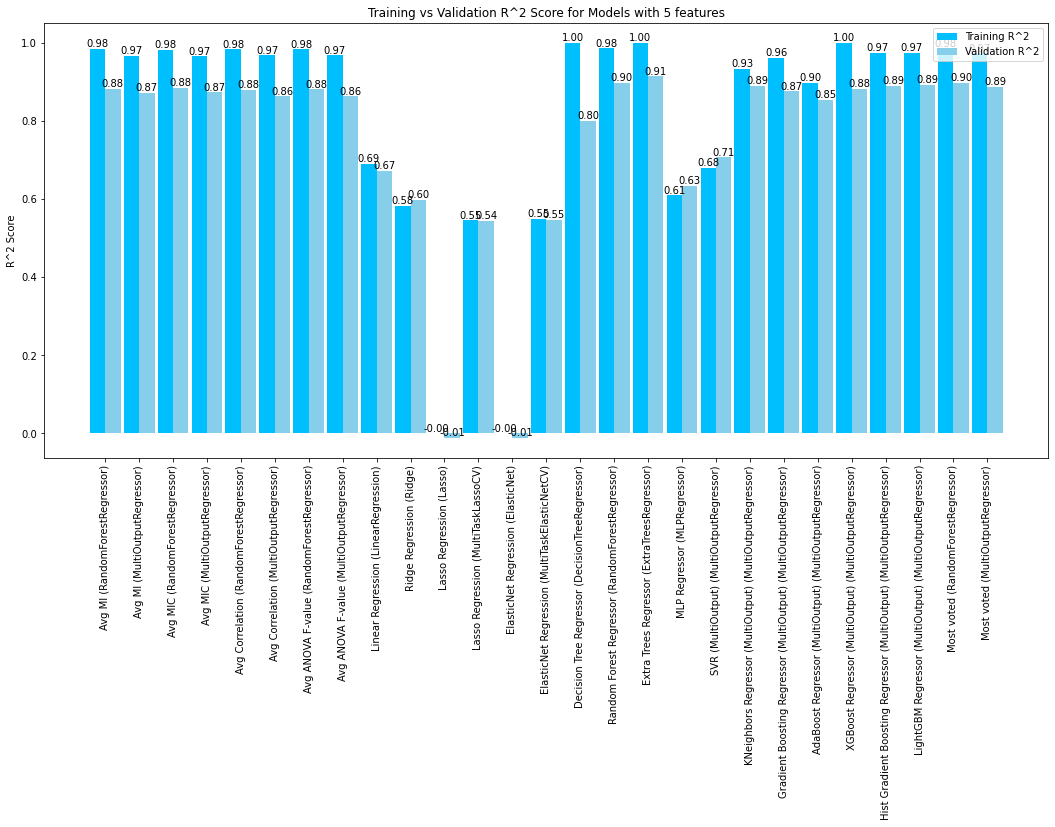

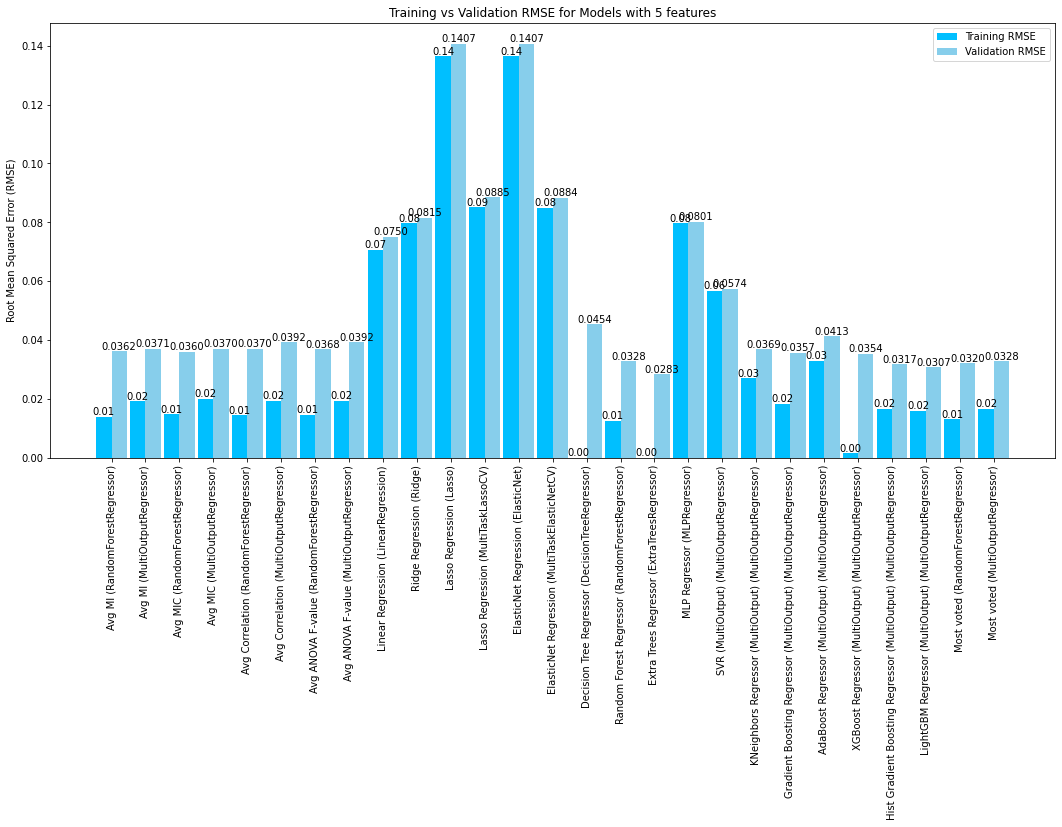

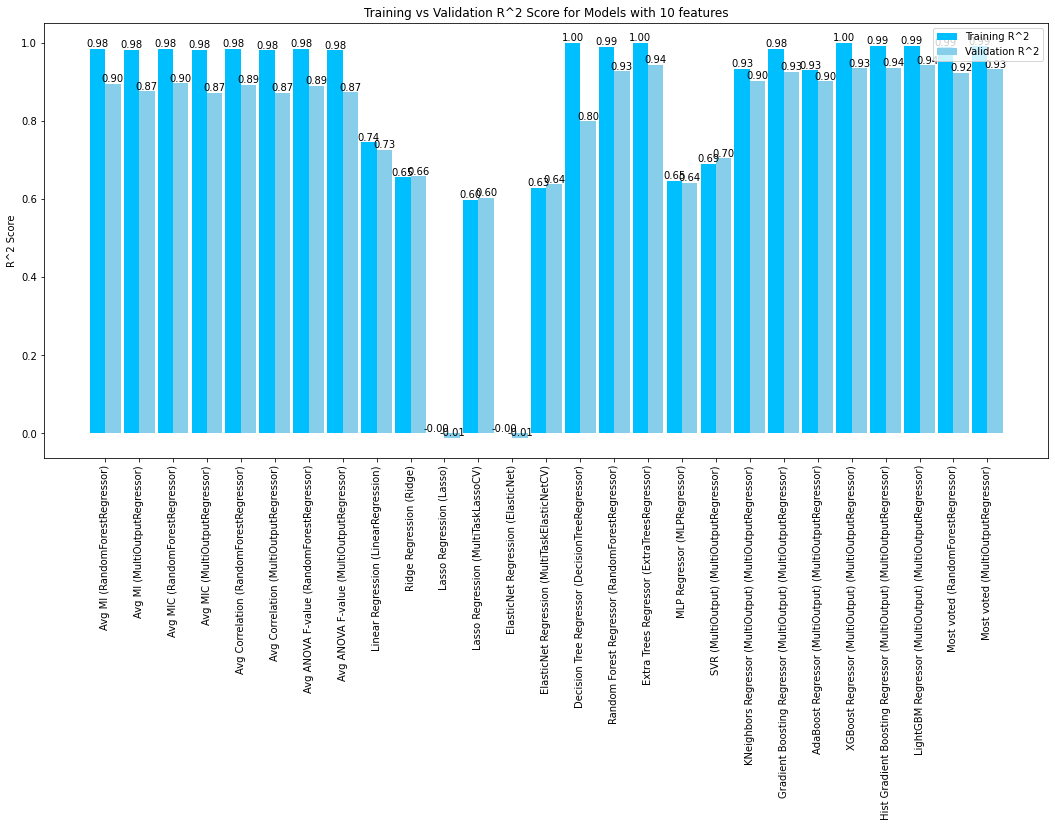

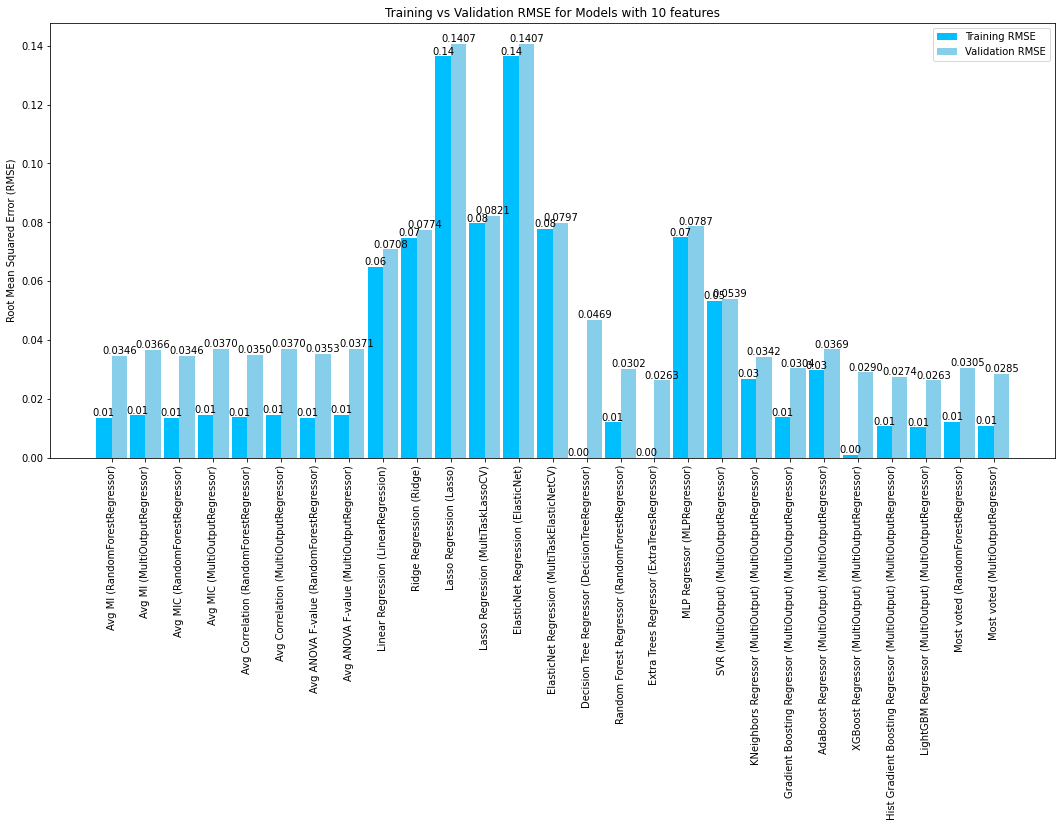

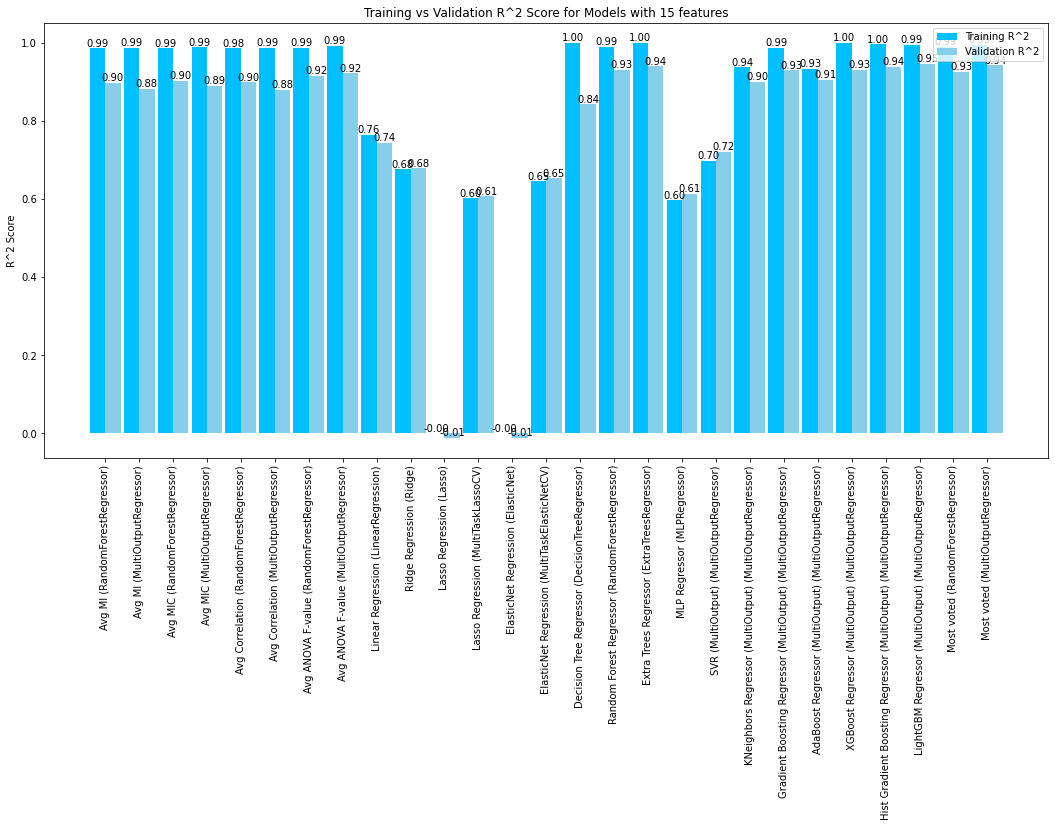

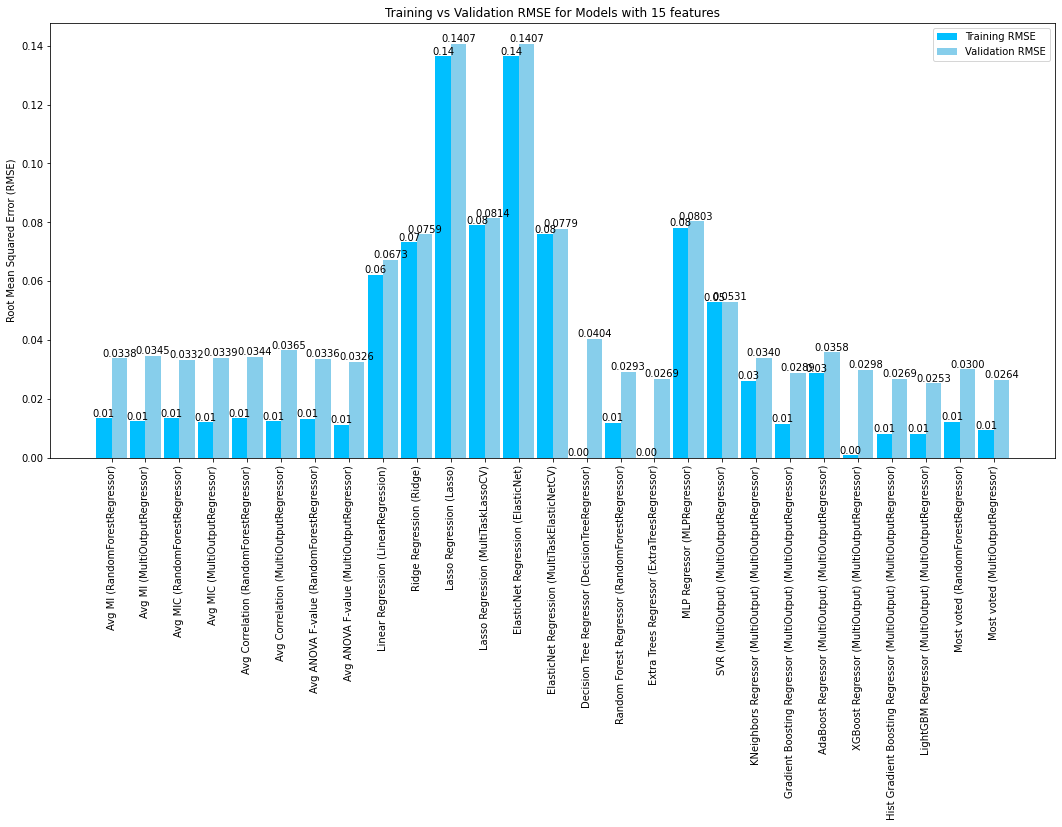

In [40]:
# Iterate over each feature set (5, 10, 15) for plotting R^2 and RMSE
for feature_set in ['5 features', '10 features', '15 features']:
    # Extract model names and data for the current feature set
    models = list(results_selected_features[feature_set].keys())
    data = results_selected_features[feature_set]

    # Plot R^2 scores
    plt.figure(figsize=(18, 8))
    bar_width = 0.25
    spacing = 0.55  # Increase this value for more space between bars
    x = np.arange(0, len(models) * spacing, spacing)  # Adjust x positions

    training_r2 = [data[model].get('Training R^2', 0) for model in models]
    validation_r2 = [data[model].get('Validation R^2', 0) for model in models]

    plt.bar(x, training_r2, width=bar_width, label='Training R^2', color='deepskyblue')
    plt.bar(x + bar_width, validation_r2, width=bar_width, label='Validation R^2', color='skyblue')

    # Add text labels for R^2 scores
    for i, (train, valid) in enumerate(zip(training_r2, validation_r2)):
        plt.text(x[i], train, f'{train:.2f}', ha='center', va='bottom', fontsize=10)
        plt.text(x[i] + bar_width, valid, f'{valid:.2f}', ha='center', va='bottom', fontsize=10)

    # Formatting the R^2 plot
    plt.xticks(x + bar_width / 2, models, rotation=90, ha='center')  # Set rotation to 90 degrees
    plt.ylabel('R^2 Score')
    plt.title(f'Training vs Validation R^2 Score for Models with {feature_set}')
    plt.legend()

    # Show the R^2 plot
    plt.show()

    # Plot RMSE scores
    plt.figure(figsize=(18, 8))
    training_rmse = [data[model].get('Training RMSE', 0) for model in models]
    validation_rmse = [data[model].get('Validation RMSE', 0) for model in models]

    plt.bar(x, training_rmse, width=bar_width, label='Training RMSE', color='deepskyblue')
    plt.bar(x + bar_width, validation_rmse, width=bar_width, label='Validation RMSE', color='skyblue')

    # Add text labels for RMSE scores
    for i, (train, valid) in enumerate(zip(training_rmse, validation_rmse)):
        plt.text(x[i], train, f'{train:.2f}', ha='center', va='bottom', fontsize=10)
        plt.text(x[i] + bar_width, valid, f'{valid:.4f}', ha='center', va='bottom', fontsize=10)

    # Formatting the RMSE plot
    plt.xticks(x + bar_width / 2, models, rotation=90, ha='center')  # Set rotation to 90 degrees
    plt.ylabel('Root Mean Squared Error (RMSE)')
    plt.title(f'Training vs Validation RMSE for Models with {feature_set}')
    plt.legend()

    # Show the RMSE plot
    plt.show()


In [143]:
# Combine training and validation sets
scaler = StandardScaler()
X_train_val = pd.concat([X_train, X_val])
y_train_val = pd.concat([y_train, y_val])
X_train_val_scaled = pd.DataFrame(scaler.fit_transform(X_train_val), columns=X_train_val.columns)

In [144]:
def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data['Feature'] = X.columns
    vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif_data = vif_data.sort_values(by="VIF", ascending=False).reset_index(drop=True)
    return vif_data

vif_data = calculate_vif(X_train_val)
print("\nVIF for all features:")
print(vif_data)


# Split VIF data into Feature 1-25 and Feature 26-50 using explicit range matching
vif_below_25 = vif_data[vif_data['Feature'].apply(lambda x: int(x.split('_')[1]) <= 25)]
vif_above_25 = vif_data[vif_data['Feature'].apply(lambda x: int(x.split('_')[1]) > 25)]

# Count features with VIF > 10 in each group
count_below_25 = vif_below_25[vif_below_25['VIF'] > 10].shape[0]
count_above_25 = vif_above_25[vif_above_25['VIF'] > 10].shape[0]

print(f"Number of features with VIF > 10 in Feature 1-25: {count_below_25}")
print(f"Number of features with VIF > 10 in Feature 26-50: {count_above_25}")


VIF for all features:
       Feature         VIF
0    Feature_4  531.903751
1   Feature_15  433.581446
2   Feature_25  369.333030
3   Feature_19  355.595193
4   Feature_12  200.944620
5   Feature_16  121.625513
6   Feature_22  100.934075
7   Feature_18  100.405558
8    Feature_2   84.925959
9    Feature_3   32.458433
10  Feature_17   31.643804
11  Feature_21   29.439326
12  Feature_20   27.160039
13  Feature_14   26.455310
14   Feature_6   24.121991
15   Feature_5   23.491801
16   Feature_9   21.501870
17  Feature_13   21.352112
18   Feature_7   20.886566
19   Feature_8   20.323863
20  Feature_10   19.484278
21  Feature_24   16.436210
22   Feature_1   14.019076
23  Feature_11   13.821099
24  Feature_23   12.789587
25  Feature_31   10.088391
26  Feature_49    9.146453
27  Feature_26    9.063038
28  Feature_38    8.911633
29  Feature_33    8.885456
30  Feature_39    8.596486
31  Feature_28    8.476532
32  Feature_32    8.277811
33  Feature_46    8.244332
34  Feature_47    8.179121
35  F

In [173]:
filter_selected_features = {'5 features': {}, '10 features': {}, '15 features': {}}
y_train_val_np = y_train_val.values if isinstance(y_train_val, pd.DataFrame) else y_train_val

# Filter for Average MI
model_name = "Avg MI"
mi_scores_per_output = np.zeros((y_train_val_np.shape[1], X_train_val_scaled.shape[1]))

for i in range(y_train_val_np.shape[1]):
    mi_scores_per_output[i, :] = mutual_info_regression(X_train_val_scaled, y_train_val_np[:, i])

mi_scores_avg = np.mean(mi_scores_per_output, axis=0)
sorted_indices = np.argsort(mi_scores_avg)[::-1]

filter_selected_features['5 features'][model_name] = [f'Feature_{i+1}' for i in sorted_indices[:5]]
filter_selected_features['10 features'][model_name] = [f'Feature_{i+1}' for i in sorted_indices[:10]]
filter_selected_features['15 features'][model_name] = [f'Feature_{i+1}' for i in sorted_indices[:15]]

# Filter for Average MIC
model_name = "Avg MIC"
mic_scores_per_output = np.zeros((y_train_val_np.shape[1], X_train_val_scaled.shape[1]))
mine = MINE()

for i in range(y_train_val_np.shape[1]):
    for j in range(X_train_val_scaled.shape[1]):
        mine.compute_score(X_train_val_scaled.iloc[:, j], y_train_val_np[:, i])
        mic_scores_per_output[i, j] = mine.mic()

mic_scores_avg = np.mean(mic_scores_per_output, axis=0)
sorted_indices = np.argsort(mic_scores_avg)[::-1]

filter_selected_features['5 features'][model_name] = [f'Feature_{i+1}' for i in sorted_indices[:5]]
filter_selected_features['10 features'][model_name] = [f'Feature_{i+1}' for i in sorted_indices[:10]]
filter_selected_features['15 features'][model_name] = [f'Feature_{i+1}' for i in sorted_indices[:15]]

# Filter for Average Correlation
model_name = "Avg Correlation"
correlation_scores_per_output = np.zeros((y_train_val_np.shape[1], X_train_val_scaled.shape[1]))

for output in range(y_train_val_np.shape[1]):
    corr_scores = [
        np.corrcoef(X_train_val_scaled.iloc[:, i], y_train_val_np[:, output])[0, 1]
        for i in range(X_train_val_scaled.shape[1])
    ]
    correlation_scores_per_output[output, :] = np.nan_to_num(corr_scores)

correlation_scores_avg = np.mean(np.abs(correlation_scores_per_output), axis=0)
sorted_indices = np.argsort(correlation_scores_avg)[::-1]

filter_selected_features['5 features'][model_name] = [f'Feature_{i+1}' for i in sorted_indices[:5]]
filter_selected_features['10 features'][model_name] = [f'Feature_{i+1}' for i in sorted_indices[:10]]
filter_selected_features['15 features'][model_name] = [f'Feature_{i+1}' for i in sorted_indices[:15]]

# Filter for Average ANOVA F-value
model_name = "Avg ANOVA F-value"
f_scores_per_output = np.zeros((y_train_val_np.shape[1], X_train_val_scaled.shape[1]))

for output in range(y_train_val_np.shape[1]):
    f_stat, _ = f_regression(X_train_val_scaled, y_train_val_np[:, output])
    f_scores_per_output[output, :] = f_stat

f_scores_avg = np.mean(f_scores_per_output, axis=0)
sorted_indices = np.argsort(f_scores_avg)[::-1]

filter_selected_features['5 features'][model_name] = [f'Feature_{i+1}' for i in sorted_indices[:5]]
filter_selected_features['10 features'][model_name] = [f'Feature_{i+1}' for i in sorted_indices[:10]]
filter_selected_features['15 features'][model_name] = [f'Feature_{i+1}' for i in sorted_indices[:15]]

# Filter for Average Distance Correlation
model_name = "Avg Distance Correlation"
dcor_scores_per_output = np.zeros((y_train_val_np.shape[1], X_train_val_scaled.shape[1]))

for output in range(y_train_val_np.shape[1]):
    dcor_scores = [
        dcor.distance_correlation(X_train_val_scaled.iloc[:, i], y_train_val_np[:, output])
        for i in range(X_train_val_scaled.shape[1])
    ]
    dcor_scores_per_output[output, :] = dcor_scores

dcor_scores_avg = np.mean(dcor_scores_per_output, axis=0)
sorted_indices = np.argsort(dcor_scores_avg)[::-1]

# Select top features
filter_selected_features['5 features'][model_name] = [f'Feature_{i+1}' for i in sorted_indices[:5]]
filter_selected_features['10 features'][model_name] = [f'Feature_{i+1}' for i in sorted_indices[:10]]
filter_selected_features['15 features'][model_name] = [f'Feature_{i+1}' for i in sorted_indices[:15]]

In [174]:
# Function to calculate VIF for all features
def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data['Feature'] = X.columns
    vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data

# Function to recursively remove features based on VIF
def remove_high_vif_features(X, threshold=10, max_features_to_remove=None):
    X_copy = X.copy()
    removed_features = []
    
    while True:
        vif_data = calculate_vif(X_copy)
        max_vif = vif_data['VIF'].max()
        if max_vif < threshold or (max_features_to_remove and len(removed_features) >= max_features_to_remove):
            break
        
        # Get the feature with the highest VIF
        feature_to_remove = vif_data.loc[vif_data['VIF'].idxmax(), 'Feature']
        removed_features.append(feature_to_remove)
        X_copy = X_copy.drop(columns=[feature_to_remove])
        
        print(f"Removed {feature_to_remove} with VIF = {max_vif:.4f}")
        
    return X_copy, removed_features

# Function to run filter-based feature selection
def run_filter_based_selection(X, y, filter_selected_features, suffix=""):
    y_np = y.values if isinstance(y, pd.DataFrame) else y
    feature_names = X.columns

    for model_name, method in [(f'Avg MI {suffix}', mutual_info_regression), 
                               (f'Avg MIC {suffix}', None), 
                               (f'Avg Correlation {suffix}', None), 
                               (f'Avg ANOVA F-value {suffix}', f_regression), 
                               (f'Avg Distance Correlation {suffix}', None)]:
        
        if model_name == f'Avg MIC {suffix}':
            scores_per_output = np.zeros((y_np.shape[1], X.shape[1]))
            mine = MINE()
            for i in range(y_np.shape[1]):
                for j in range(X.shape[1]):
                    mine.compute_score(X.iloc[:, j], y_np[:, i])
                    scores_per_output[i, j] = mine.mic()
        
        elif model_name == f'Avg Correlation {suffix}':
            scores_per_output = np.zeros((y_np.shape[1], X.shape[1]))
            for i in range(y_np.shape[1]):
                scores = [np.corrcoef(X.iloc[:, j], y_np[:, i])[0, 1] for j in range(X.shape[1])]
                scores_per_output[i, :] = np.nan_to_num(scores)
        
        elif model_name == f'Avg Distance Correlation {suffix}':
            scores_per_output = np.zeros((y_np.shape[1], X.shape[1]))
            for i in range(y_np.shape[1]):
                scores = [dcor.distance_correlation(X.iloc[:, j], y_np[:, i]) for j in range(X.shape[1])]
                scores_per_output[i, :] = scores
        
        else:  # Avg MI T or ANOVA F-value T
            scores_per_output = np.zeros((y_np.shape[1], X.shape[1]))
            for i in range(y_np.shape[1]):
                try:
                    score_values = method(X, y_np[:, i])
                    if isinstance(score_values, tuple):
                        score_values = score_values[0]  # Take only the first element (F-statistic)
                    score_values = np.array(score_values).flatten()
                    if score_values.shape[0] != X.shape[1]:
                        raise ValueError(f"Shape mismatch: Expected {X.shape[1]} features, but got {score_values.shape[0]}.")
                    scores_per_output[i, :] = score_values
                except Exception as e:
                    print(f"Error processing {model_name} for output {i}: {str(e)}")
                    raise e  # Re-raise the exception
        
        scores_avg = np.mean(scores_per_output, axis=0)
        sorted_indices = np.argsort(scores_avg)[::-1]
        
        for n in [5, 10, 15]:
            filter_selected_features[f'{n} features'][model_name] = [feature_names[i] for i in sorted_indices[:n]]

    return filter_selected_features

vif_thresholds = [10, 5, 3]

for threshold in vif_thresholds:
    print(f"\nRunning VIF reduction with threshold {threshold}\n")
    
    # Step 1: Remove Features Based on VIF
    X_reduced, removed_features = remove_high_vif_features(X_train_val_scaled, threshold=threshold, max_features_to_remove=25)
    print(f"Total Removed Features for VIF {threshold}: {len(removed_features)}")
    print(f"Remaining Features for VIF {threshold}: {X_reduced.columns.tolist()}")
    
    # Step 2: Re-run Filter-based Feature Selection on Reduced Features
    suffix = f'(VIF Threshold: {threshold})'
    filter_selected_features = run_filter_based_selection(X_reduced, y_train_val, filter_selected_features, suffix=suffix)
    
    # Display the selected features
    print(f"Selected Features after VIF {threshold} Reduction:")
    print(filter_selected_features)


Running VIF reduction with threshold 10

Removed Feature_4 with VIF = 167.6539
Removed Feature_15 with VIF = 156.6188
Removed Feature_19 with VIF = 101.8815
Removed Feature_12 with VIF = 72.7876
Removed Feature_18 with VIF = 48.7775
Removed Feature_25 with VIF = 43.2460
Removed Feature_22 with VIF = 33.9575
Removed Feature_2 with VIF = 24.0710
Removed Feature_7 with VIF = 11.2559
Total Removed Features for VIF 10: 9
Remaining Features for VIF 10: ['Feature_1', 'Feature_3', 'Feature_5', 'Feature_6', 'Feature_8', 'Feature_9', 'Feature_10', 'Feature_11', 'Feature_13', 'Feature_14', 'Feature_16', 'Feature_17', 'Feature_20', 'Feature_21', 'Feature_23', 'Feature_24', 'Feature_26', 'Feature_27', 'Feature_28', 'Feature_29', 'Feature_30', 'Feature_31', 'Feature_32', 'Feature_33', 'Feature_34', 'Feature_35', 'Feature_36', 'Feature_37', 'Feature_38', 'Feature_39', 'Feature_40', 'Feature_41', 'Feature_42', 'Feature_43', 'Feature_44', 'Feature_45', 'Feature_46', 'Feature_47', 'Feature_48', 'Featur

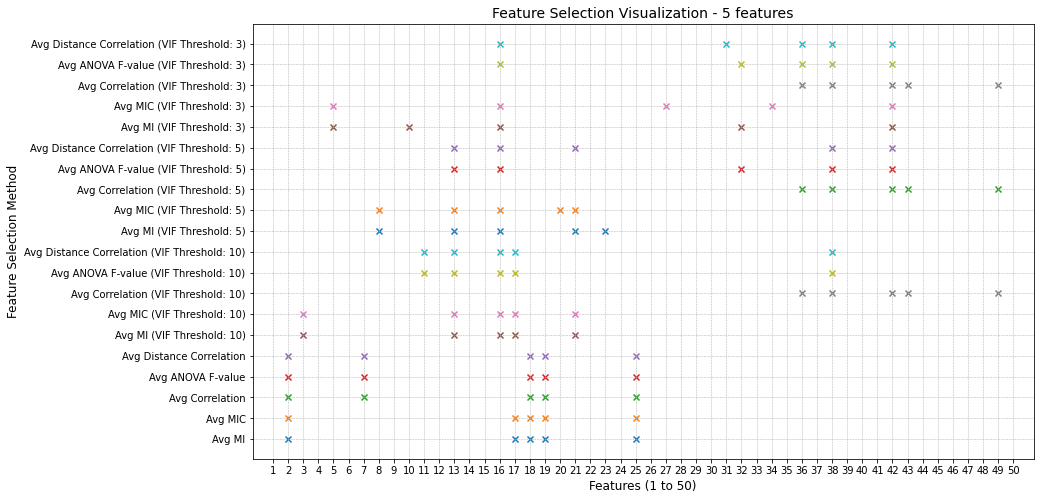

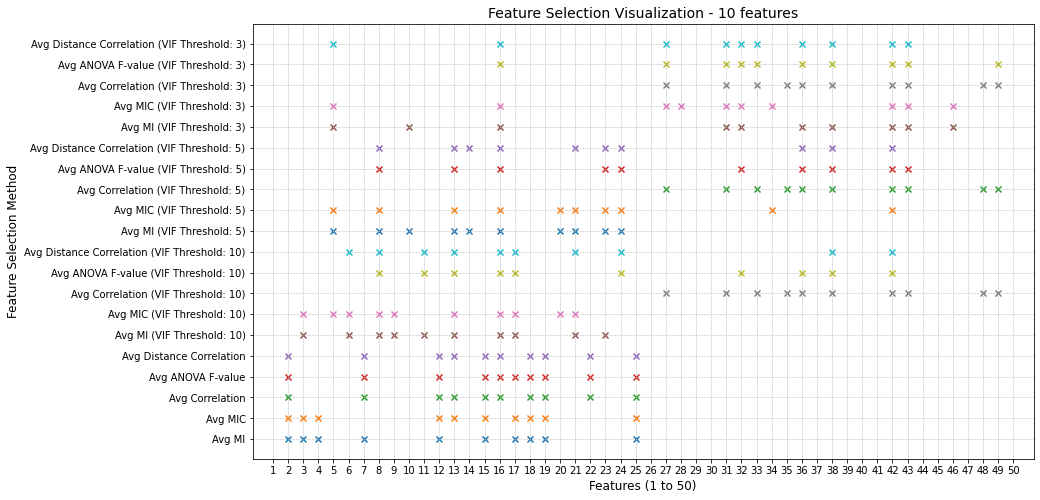

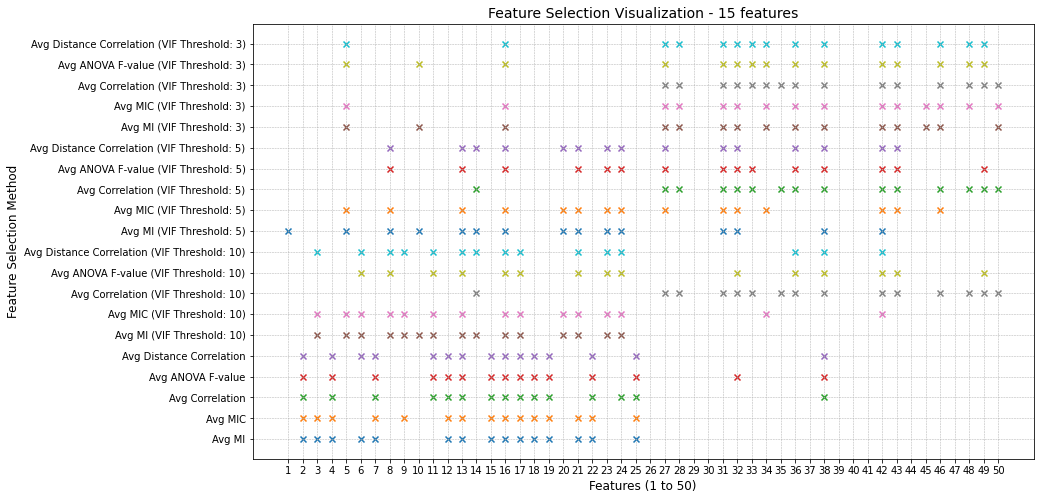

In [175]:

# Create a feature-to-index mapping
feature_to_index = {f'Feature_{i+1}': i+1 for i in range(50)}

# Function to plot selected features for a given section (5, 10, or 15 features)
def plot_selected_features(section, selected_features):
    plt.figure(figsize=(14, 8))
    x_axis = np.arange(1, 51)  # x-axis for 50 features
    y_offset = 0  # Used to differentiate models vertically on the y-axis

    for model_name, features in selected_features.items():
        # Convert feature names to their numeric indices for plotting
        numeric_features = [feature_to_index[feature] for feature in features if feature in feature_to_index]
        y = np.full(len(numeric_features), y_offset)
        plt.scatter(numeric_features, y, marker='x', label=model_name)
        y_offset += 1

    plt.yticks(range(y_offset), list(selected_features.keys()))
    plt.xticks(x_axis)
    plt.xlabel('Features (1 to 50)', fontsize=12)
    plt.ylabel('Feature Selection Method', fontsize=12)
    plt.title(f'Feature Selection Visualization - {section}', fontsize=14)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()

# Plot each section separately for 5, 10, and 15 features
for section, features in filter_selected_features.items():
    plot_selected_features(section, features)


In [176]:
filter_selected_features

{'5 features': {'Avg MI': ['Feature_18',
   'Feature_2',
   'Feature_25',
   'Feature_19',
   'Feature_17'],
  'Avg MIC': ['Feature_18',
   'Feature_2',
   'Feature_19',
   'Feature_25',
   'Feature_17'],
  'Avg Correlation': ['Feature_7',
   'Feature_18',
   'Feature_2',
   'Feature_25',
   'Feature_19'],
  'Avg ANOVA F-value': ['Feature_18',
   'Feature_7',
   'Feature_2',
   'Feature_19',
   'Feature_25'],
  'Avg Distance Correlation': ['Feature_7',
   'Feature_18',
   'Feature_2',
   'Feature_19',
   'Feature_25'],
  'Avg MI (VIF Threshold: 10)': ['Feature_17',
   'Feature_3',
   'Feature_16',
   'Feature_21',
   'Feature_13'],
  'Avg MIC (VIF Threshold: 10)': ['Feature_17',
   'Feature_3',
   'Feature_13',
   'Feature_16',
   'Feature_21'],
  'Avg Correlation (VIF Threshold: 10)': ['Feature_38',
   'Feature_36',
   'Feature_42',
   'Feature_49',
   'Feature_43'],
  'Avg ANOVA F-value (VIF Threshold: 10)': ['Feature_16',
   'Feature_17',
   'Feature_13',
   'Feature_38',
   'Featur

In [221]:
# Define models and their parameter grids
filter_model_param_grid = {
    'Extra Trees Regressor': {
        'model': [ExtraTreesRegressor(random_state=42)],
        'model__n_estimators': [50, 100, 200],
        'model__max_depth': [5, 10, None]
    }
    # 'ElasticNet Regression': {
    #     'model': [ElasticNet(max_iter=10000)],
    #     'model__alpha': np.logspace(-3, 2, 5),
    #     'model__l1_ratio': [0.1, 0.5, 0.9]
    # }
    # 'Linear Regression': {
    #     'model': [LinearRegression()]
    # }
}

# Results dictionary to store results for each feature set (5, 10, 15) and each VIF threshold
filter_results = {'5 features': {}, '10 features': {}, '15 features': {}}

# Loop through feature sets (5, 10, 15)
for feature_set in ['5 features', '10 features', '15 features']:
    print(f"\nHyperparameter tuning for feature set: {feature_set}\n")
    
    # Loop through VIF thresholds and feature selection methods
    for feature_selection_method, selected_features in filter_selected_features[feature_set].items():
        print(f"Tuning and evaluating for: {feature_selection_method} with {len(selected_features)} features")
        
        # Select only the features for this particular method
        X_train_val_selected = X_train_val[selected_features]
        X_train_val_scaled = pd.DataFrame(scaler.fit_transform(X_train_val_selected), columns=X_train_val_selected.columns)
        
        param_grid = filter_model_param_grid['Extra Trees Regressor']
        pipeline = Pipeline([('model', param_grid['model'][0])])  # Start with the model from the grid
        
        grid = GridSearchCV(pipeline, param_grid, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)
        
        start_time = time.time()
        grid.fit(X_train_val_scaled, y_train_val)
        end_time = time.time()
        training_time = end_time - start_time
        
        best_params = clean_params_with_model(grid)
        
        # Cross-validation results
        best_neg_mse = grid.best_score_
        best_mse = -best_neg_mse  # Convert to positive
        best_rmse = np.sqrt(best_mse)
        
        train_predictions = grid.best_estimator_.predict(X_train_val_scaled)
        train_mse = mean_squared_error(y_train_val, train_predictions)
        train_rmse = np.sqrt(train_mse)
        
        # Save standardized results
        filter_results[feature_set][feature_selection_method] = {
            'Best Parameters': best_params,
            'Cross-Validation Mean MSE': best_mse,
            'Cross-Validation Mean RMSE': best_rmse,
            'Training RMSE': train_rmse,
            'Training Time (seconds)': training_time
        }


Hyperparameter tuning for feature set: 5 features

Tuning and evaluating for: Avg MI with 5 features
Tuning and evaluating for: Avg MIC with 5 features
Tuning and evaluating for: Avg Correlation with 5 features
Tuning and evaluating for: Avg ANOVA F-value with 5 features
Tuning and evaluating for: Avg Distance Correlation with 5 features
Tuning and evaluating for: Avg MI (VIF Threshold: 10) with 5 features
Tuning and evaluating for: Avg MIC (VIF Threshold: 10) with 5 features
Tuning and evaluating for: Avg Correlation (VIF Threshold: 10) with 5 features
Tuning and evaluating for: Avg ANOVA F-value (VIF Threshold: 10) with 5 features
Tuning and evaluating for: Avg Distance Correlation (VIF Threshold: 10) with 5 features
Tuning and evaluating for: Avg MI (VIF Threshold: 5) with 5 features
Tuning and evaluating for: Avg MIC (VIF Threshold: 5) with 5 features
Tuning and evaluating for: Avg Correlation (VIF Threshold: 5) with 5 features
Tuning and evaluating for: Avg ANOVA F-value (VIF Thr

Creating plot for 5 features...


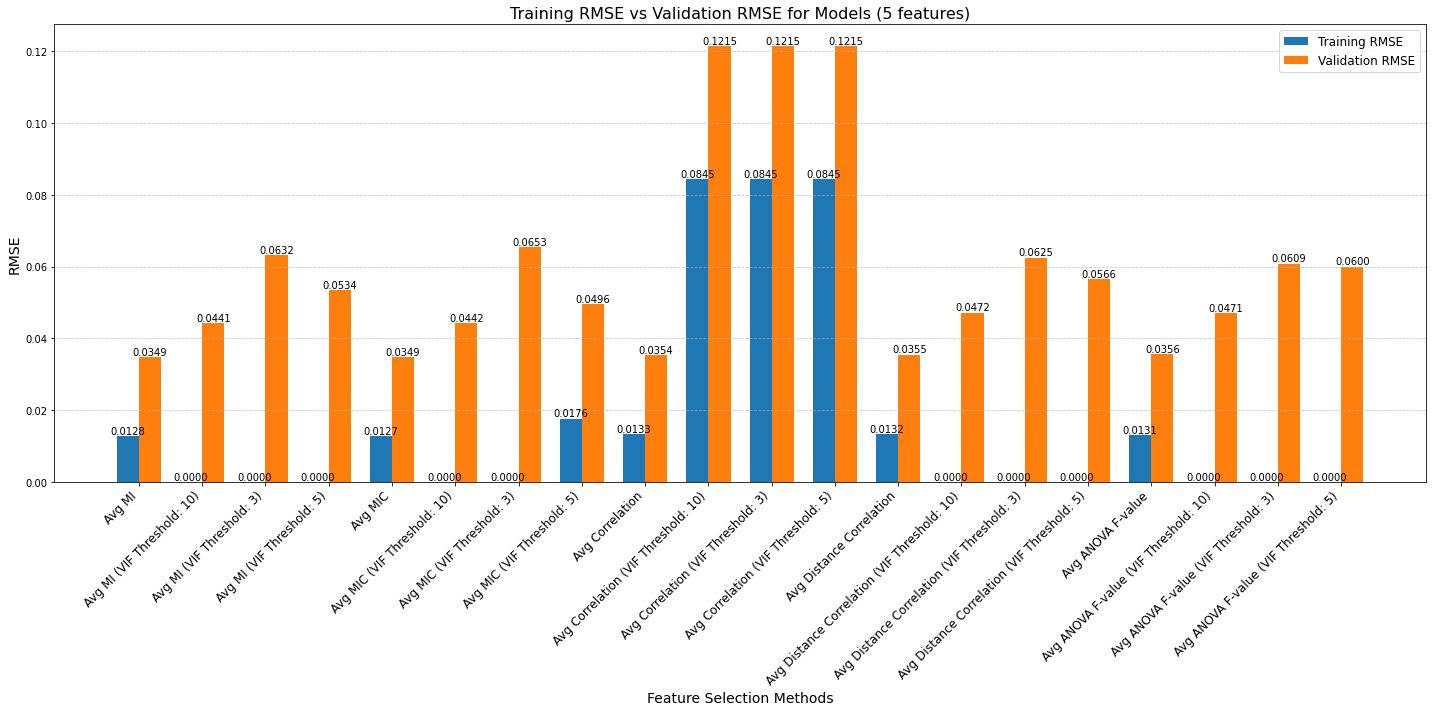

Creating plot for 10 features...


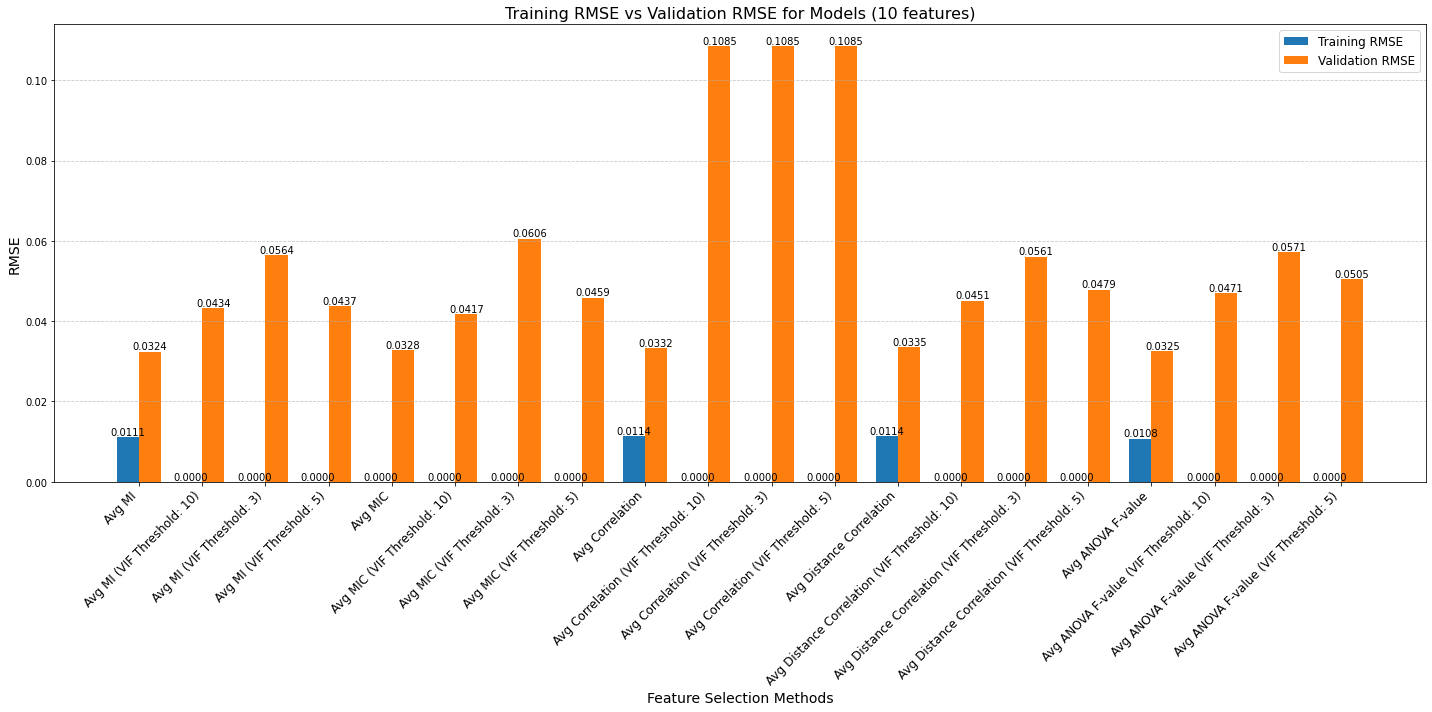

Creating plot for 15 features...


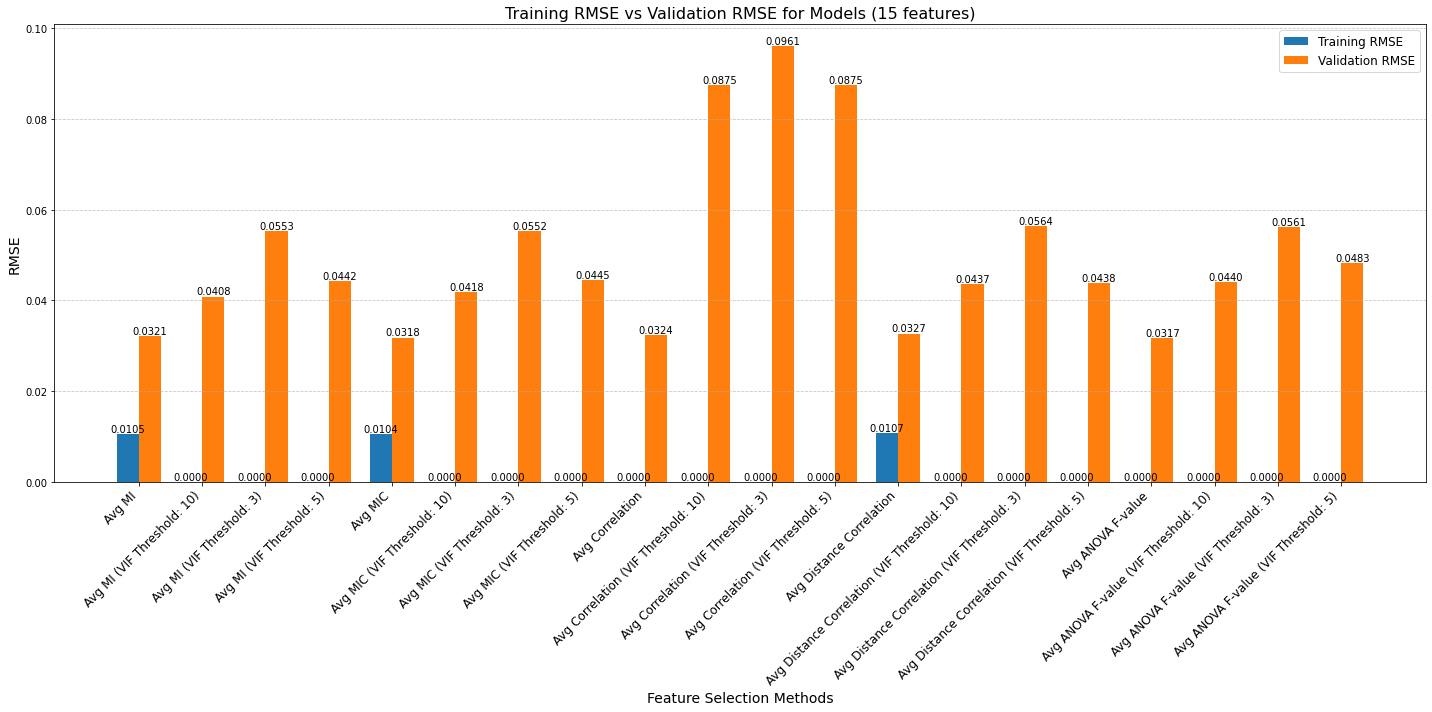

In [222]:
def sort_key(model_name):
    priority = {'MI': 0, 'MIC': 1, 'Correlation': 2, 'ANOVA': 3, 'Distance': 4}
    for key in priority:
        if key in model_name:
            return (priority[key], model_name)
    return (999, model_name)

# Loop over 5, 10, and 15 feature sets to generate plots
for feature_count in ['5 features', '10 features', '15 features']:
    print(f"Creating plot for {feature_count}...")
    
    models = []
    train_rmse = []
    cv_rmse = []
    train_time = []

    for model, metrics in filter_results[feature_count].items():
        models.append(model)
        train_rmse.append(metrics['Training RMSE'])
        cv_rmse.append(metrics['Cross-Validation Mean RMSE'])
        train_time.append(metrics.get('Training Time (seconds)', 0))

    # Sort by method type
    sorted_indices = sorted(range(len(models)), key=lambda i: sort_key(models[i]))
    models = [models[i] for i in sorted_indices]
    train_rmse = [train_rmse[i] for i in sorted_indices]
    cv_rmse = [cv_rmse[i] for i in sorted_indices]
    train_time = [train_time[i] for i in sorted_indices]

    x = np.arange(len(models))  # the label locations

    # Plotting
    width = 0.35  # the width of the bars
    fig, ax = plt.subplots(figsize=(20, 10))  # Increase figure size for better readability
    bars1 = ax.bar(x - width/2, train_rmse, width, label='Training RMSE')
    bars2 = ax.bar(x + width/2, cv_rmse, width, label='Validation RMSE')

    # Add text for labels, title, and custom x-axis tick labels
    ax.set_xlabel('Feature Selection Methods', fontsize=14)
    ax.set_ylabel('RMSE', fontsize=14)
    ax.set_title(f'Training RMSE vs Validation RMSE for Models ({feature_count})', fontsize=16)
    ax.set_xticks(x)
    ax.set_xticklabels(models, rotation=45, ha='right', fontsize=12)
    ax.legend(fontsize=12)

    ax.grid(axis='y', linestyle='--', alpha=0.7)

    # Add values on top of the bars
    for bar in bars1:
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(), 
                f'{bar.get_height():.4f}', ha='center', va='bottom', fontsize=10)
    for bar in bars2:
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(), 
                f'{bar.get_height():.4f}', ha='center', va='bottom', fontsize=10)

    plt.tight_layout()
    plt.show()


In [ ]:
# Define models and their parameter grids
filter_model_param_grid = {
    # 'Extra Trees Regressor': {
    #     'model': [ExtraTreesRegressor(random_state=42)],
    #     'model__n_estimators': [50, 100, 200],
    #     'model__max_depth': [5, 10, None]
    # }
    'ElasticNet Regression': {
        'model': [ElasticNet(max_iter=10000)],
        'model__alpha': np.logspace(-3, 2, 5),
        'model__l1_ratio': [0.1, 0.5, 0.9]
    }
}

# Results dictionary to store results for each feature set (5, 10, 15) and each VIF threshold
filter_results = {'5 features': {}, '10 features': {}, '15 features': {}}

# Loop through feature sets (5, 10, 15)
for feature_set in ['5 features', '10 features', '15 features']:
    print(f"\nHyperparameter tuning for feature set: {feature_set}\n")
    
    # Loop through VIF thresholds and feature selection methods
    for feature_selection_method, selected_features in filter_selected_features[feature_set].items():
        print(f"Tuning and evaluating for: {feature_selection_method} with {len(selected_features)} features")
        
        # Select only the features for this particular method
        X_train_val_selected = X_train_val[selected_features]
        X_train_val_scaled = pd.DataFrame(scaler.fit_transform(X_train_val_selected), columns=X_train_val_selected.columns)
        
        param_grid = filter_model_param_grid['ElasticNet Regression']
        pipeline = Pipeline([('model', param_grid['model'][0])])  # Start with the model from the grid
        
        grid = GridSearchCV(pipeline, param_grid, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)
        
        start_time = time.time()
        grid.fit(X_train_val_scaled, y_train_val)
        end_time = time.time()
        training_time = end_time - start_time
        
        best_params = clean_params_with_model(grid)
        
        # Cross-validation results
        best_neg_mse = grid.best_score_
        best_mse = -best_neg_mse  # Convert to positive
        best_rmse = np.sqrt(best_mse)
        
        train_predictions = grid.best_estimator_.predict(X_train_val_scaled)
        train_mse = mean_squared_error(y_train_val, train_predictions)
        train_rmse = np.sqrt(train_mse)
        
        # Save standardized results
        filter_results[feature_set][feature_selection_method] = {
            'Best Parameters': best_params,
            'Cross-Validation Mean MSE': best_mse,
            'Cross-Validation Mean RMSE': best_rmse,
            'Training RMSE': train_rmse,
            'Training Time (seconds)': training_time
        }

Summary of Extra Trees Regressor across different feature sets:
         source  Training RMSE  Validation RMSE  Training Time
0  All Features   4.113211e-16         0.029683       5.587733
1   15 Features   4.113211e-16         0.028107       2.243138
2   10 Features   4.113211e-16         0.028475       1.829597
3    5 Features   4.113211e-16         0.030820       1.568739


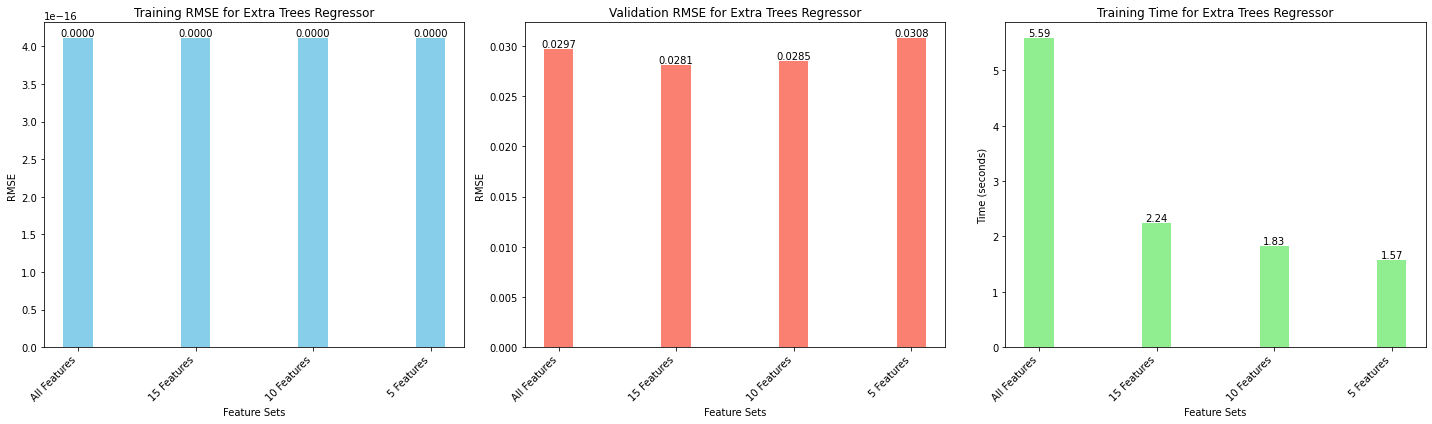


Statistical Analysis for Extra Trees Regressor across different feature sets:
       Training RMSE  Validation RMSE  Training Time
count   4.000000e+00         4.000000       4.000000
mean    4.113211e-16         0.029271       2.807302
std     0.000000e+00         0.001233       1.874302
min     4.113211e-16         0.028107       1.568739
25%     4.113211e-16         0.028383       1.764382
50%     4.113211e-16         0.029079       2.036367
75%     4.113211e-16         0.029967       3.079287
max     4.113211e-16         0.030820       5.587733


In [217]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Feature sets to compare
feature_sets = ['All Features', '15 Features', '10 Features', '5 Features']

# Models to compare
target_model = 'Extra Trees Regressor'

# Collect results for the model from each feature set
results_all = {
    'source': 'All Features',
    'Training RMSE': np.nan,
    'Validation RMSE': np.nan,
    'Training Time': np.nan
}
results_15 = {
    'source': '15 Features',
    'Training RMSE': np.nan,
    'Validation RMSE': np.nan,
    'Training Time': np.nan
}
results_10 = {
    'source': '10 Features',
    'Training RMSE': np.nan,
    'Validation RMSE': np.nan,
    'Training Time': np.nan
}
results_5 = {
    'source': '5 Features',
    'Training RMSE': np.nan,
    'Validation RMSE': np.nan,
    'Training Time': np.nan
}

# Extract data from the four result sets
for results_dict, results_source in zip([results, results_15_features, results_10_features, results_5_features], 
                                        [results_all, results_15, results_10, results_5]):
    for top_level_key in results_dict:
        if target_model in results_dict[top_level_key]:
            metrics = results_dict[top_level_key][target_model]
            results_source['Training RMSE'] = metrics.get('Training RMSE', np.nan)
            results_source['Validation RMSE'] = metrics.get('Cross-Validation Mean RMSE', np.nan)
            results_source['Training Time'] = metrics.get('Training Time (seconds)', np.nan)

# Create a DataFrame for easy handling and visualization
df = pd.DataFrame([results_all, results_15, results_10, results_5])
print("Summary of Extra Trees Regressor across different feature sets:")
print(df)

# Plot the comparative bar charts
x = np.arange(len(feature_sets))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots(1, 3, figsize=(20, 6))

# Plot Training RMSE
ax[0].bar(x, df['Training RMSE'], width, color='skyblue', label='Training RMSE')
ax[0].set_title('Training RMSE for Extra Trees Regressor')
ax[0].set_xlabel('Feature Sets')
ax[0].set_ylabel('RMSE')
ax[0].set_xticks(x)
ax[0].set_xticklabels(feature_sets, rotation=45, ha='right')
for i, val in enumerate(df['Training RMSE']):
    ax[0].text(i, val, f'{val:.4f}', ha='center', va='bottom', fontsize=10)

# Plot Validation RMSE
ax[1].bar(x, df['Validation RMSE'], width, color='salmon', label='Validation RMSE')
ax[1].set_title('Validation RMSE for Extra Trees Regressor')
ax[1].set_xlabel('Feature Sets')
ax[1].set_ylabel('RMSE')
ax[1].set_xticks(x)
ax[1].set_xticklabels(feature_sets, rotation=45, ha='right')
for i, val in enumerate(df['Validation RMSE']):
    ax[1].text(i, val, f'{val:.4f}', ha='center', va='bottom', fontsize=10)

# Plot Training Time
ax[2].bar(x, df['Training Time'], width, color='lightgreen', label='Training Time')
ax[2].set_title('Training Time for Extra Trees Regressor')
ax[2].set_xlabel('Feature Sets')
ax[2].set_ylabel('Time (seconds)')
ax[2].set_xticks(x)
ax[2].set_xticklabels(feature_sets, rotation=45, ha='right')
for i, val in enumerate(df['Training Time']):
    ax[2].text(i, val, f'{val:.2f}', ha='center', va='bottom', fontsize=10)

# Final layout adjustments
plt.tight_layout()
plt.show()

# Provide statistical analysis
statistics = df.describe()
print("\nStatistical Analysis for Extra Trees Regressor across different feature sets:")
print(statistics)



Model Comparison Across Feature Sets
                                             Model   Feature Set  \
0                          Random Forest Regressor  All Features   
1                          Random Forest Regressor   15 Features   
2                          Random Forest Regressor   10 Features   
3                          Random Forest Regressor    5 Features   
4                            Extra Trees Regressor  All Features   
5                            Extra Trees Regressor   15 Features   
6                            Extra Trees Regressor   10 Features   
7                            Extra Trees Regressor    5 Features   
8                 CatBoost Regressor (MultiOutput)  All Features   
9                 CatBoost Regressor (MultiOutput)   15 Features   
10                CatBoost Regressor (MultiOutput)   10 Features   
11                CatBoost Regressor (MultiOutput)    5 Features   
12              KNeighbors Regressor (MultiOutput)  All Features   
13        

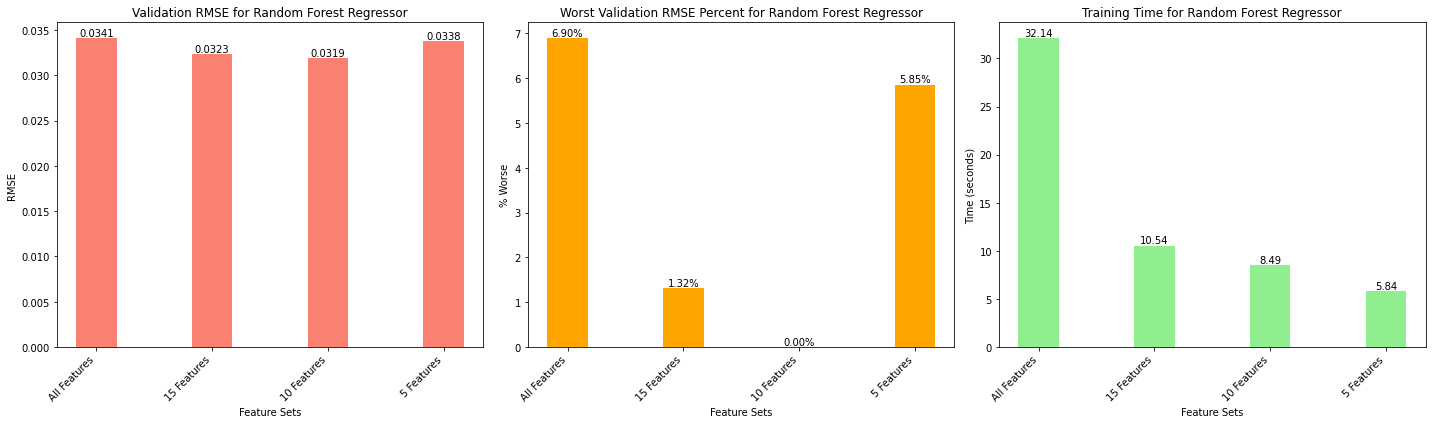

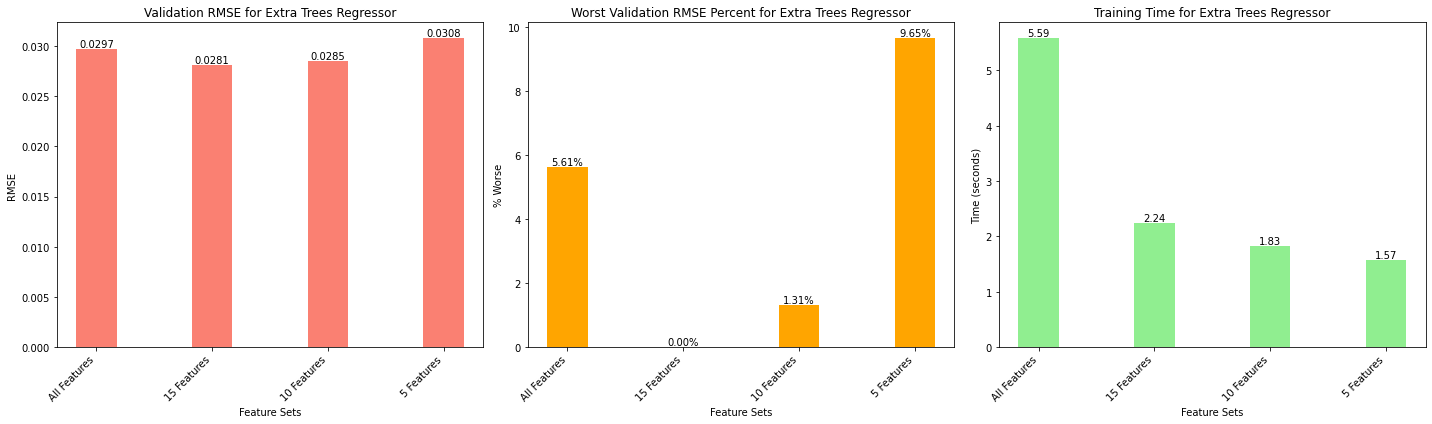

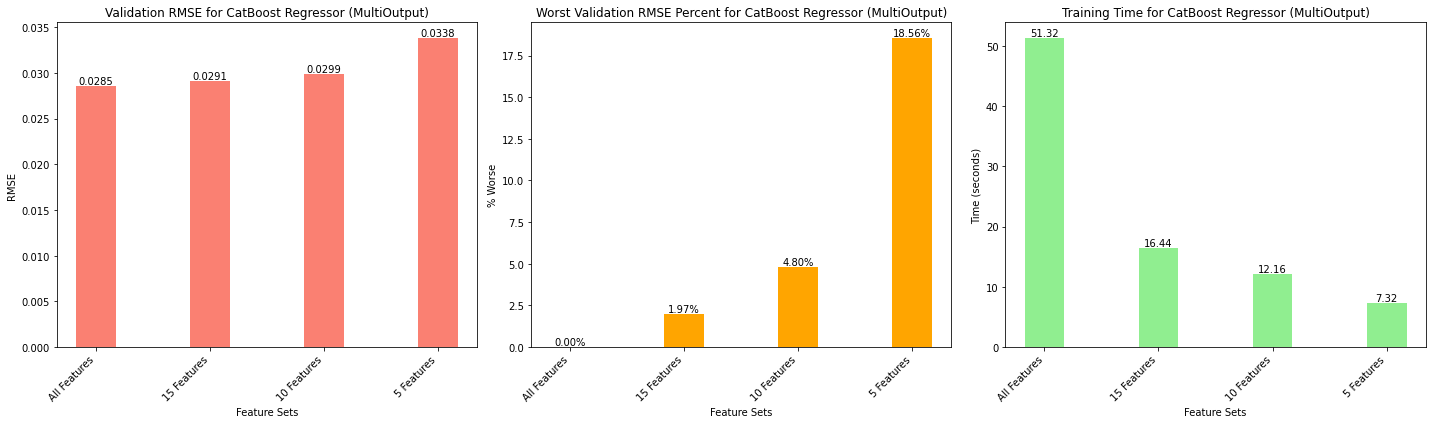

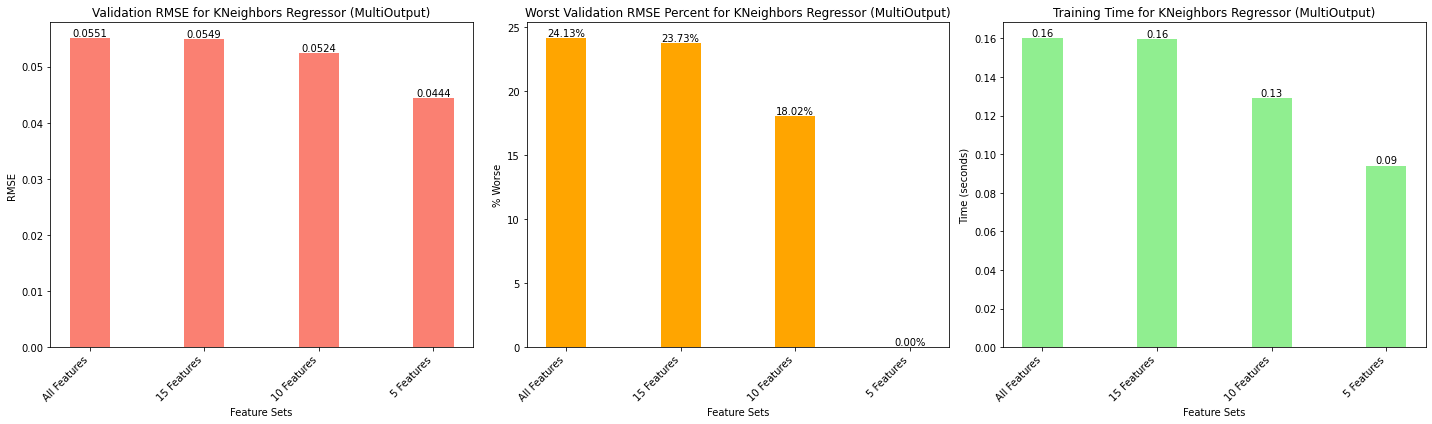

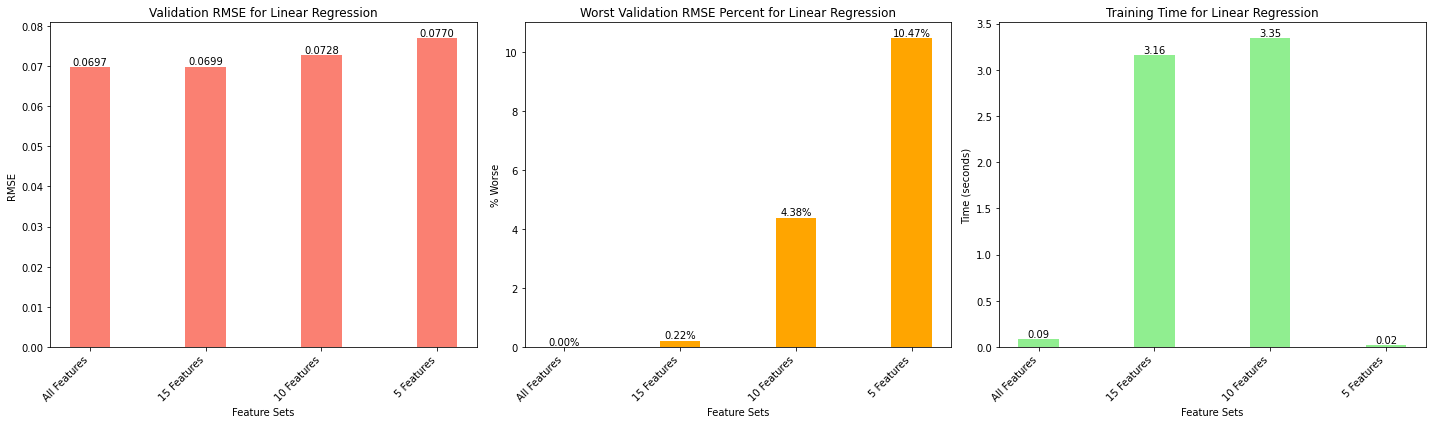

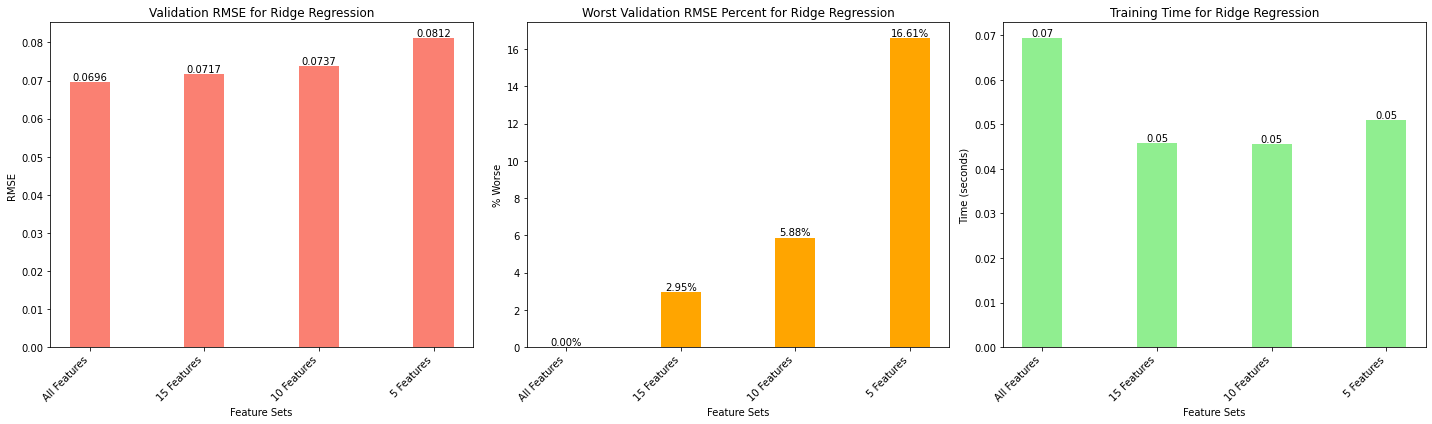

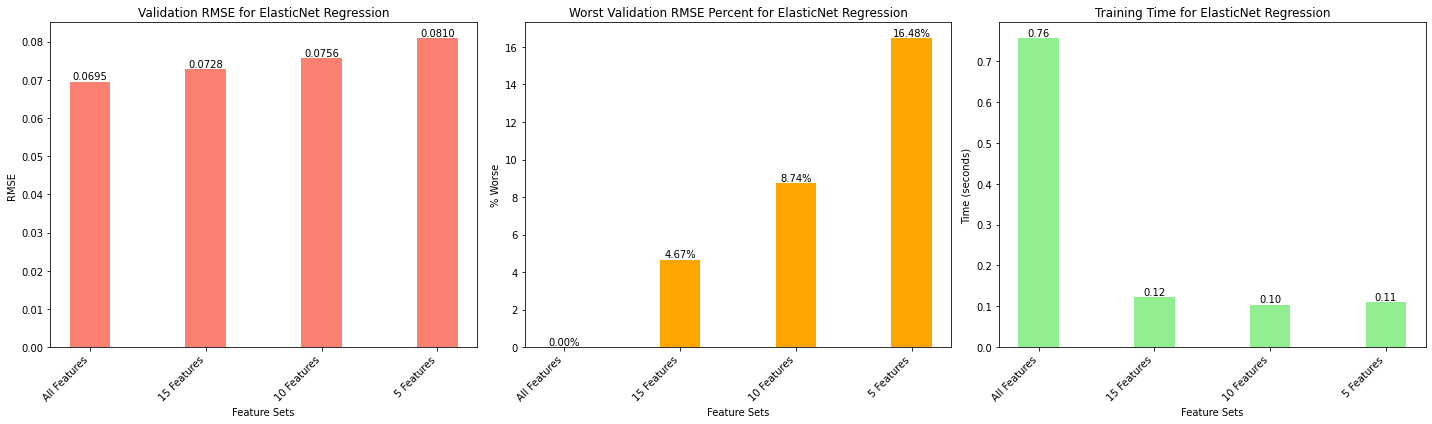

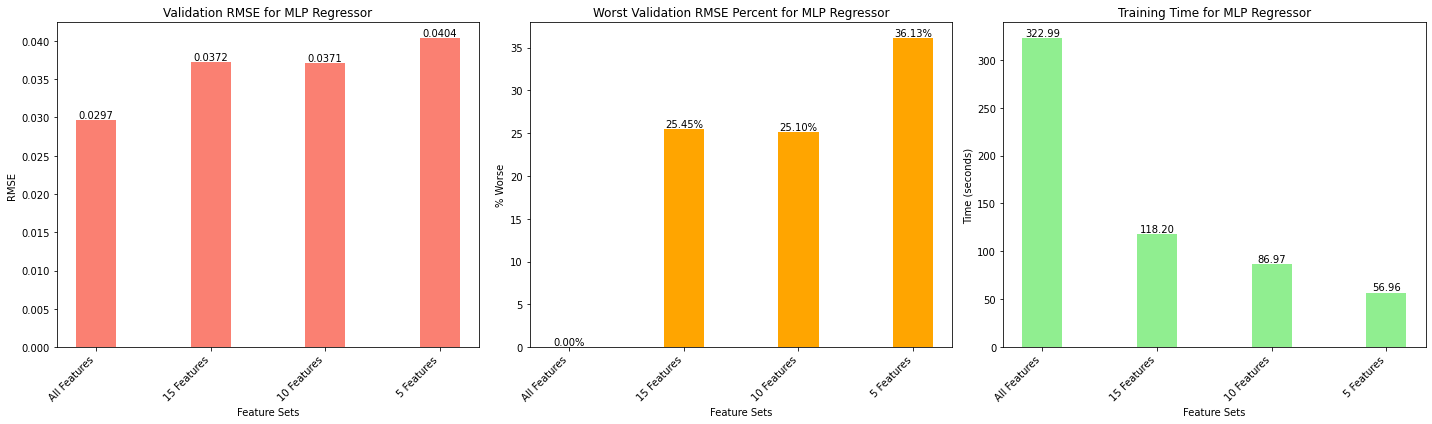

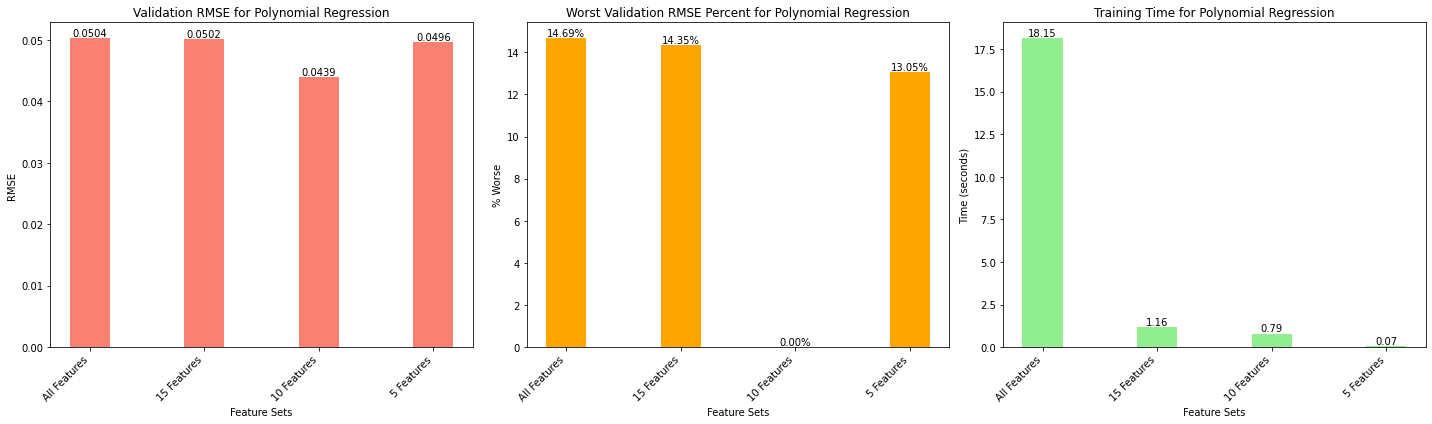

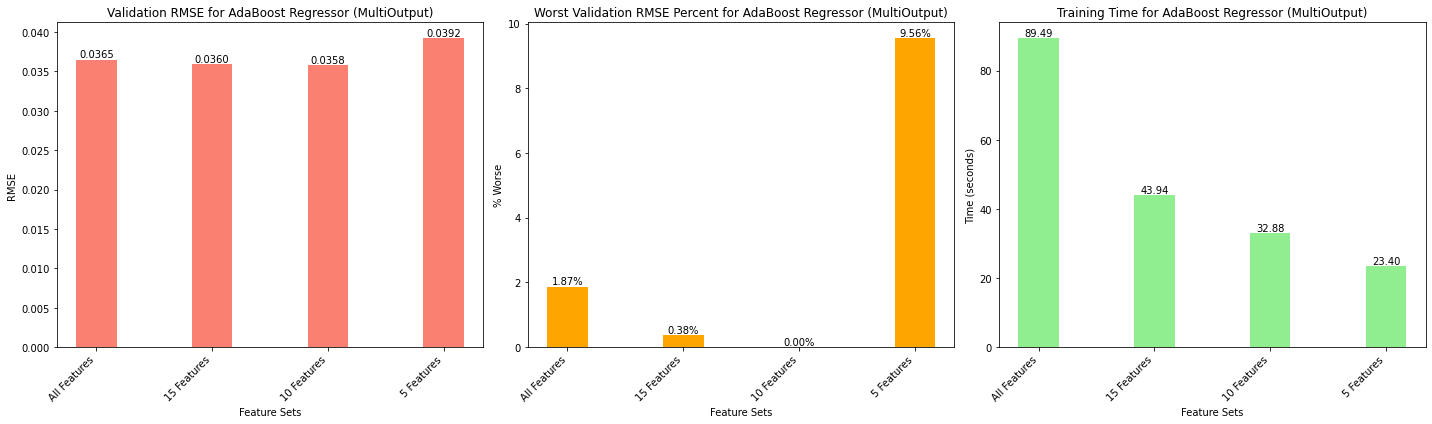

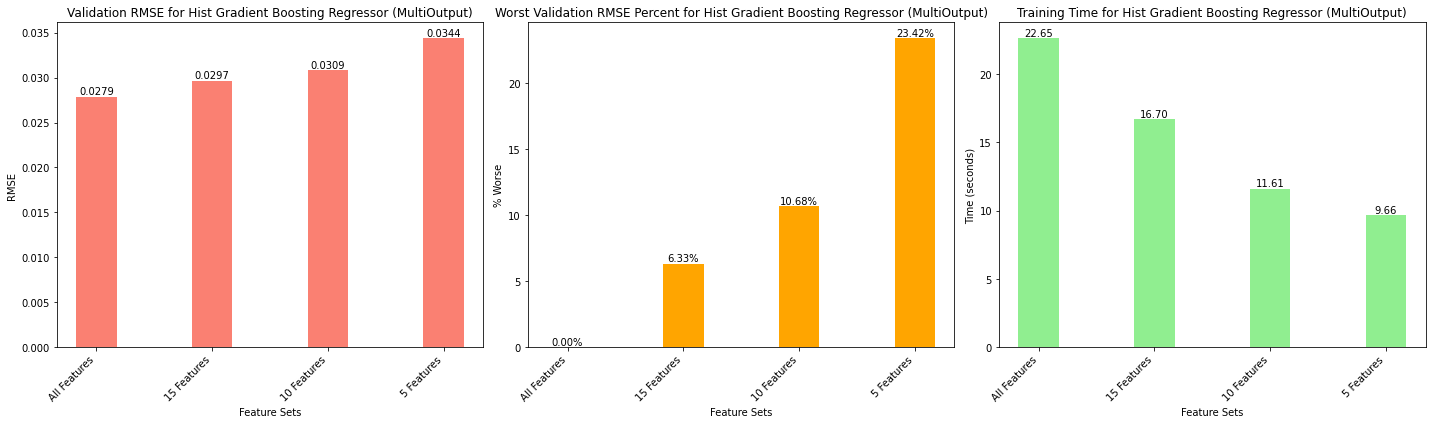

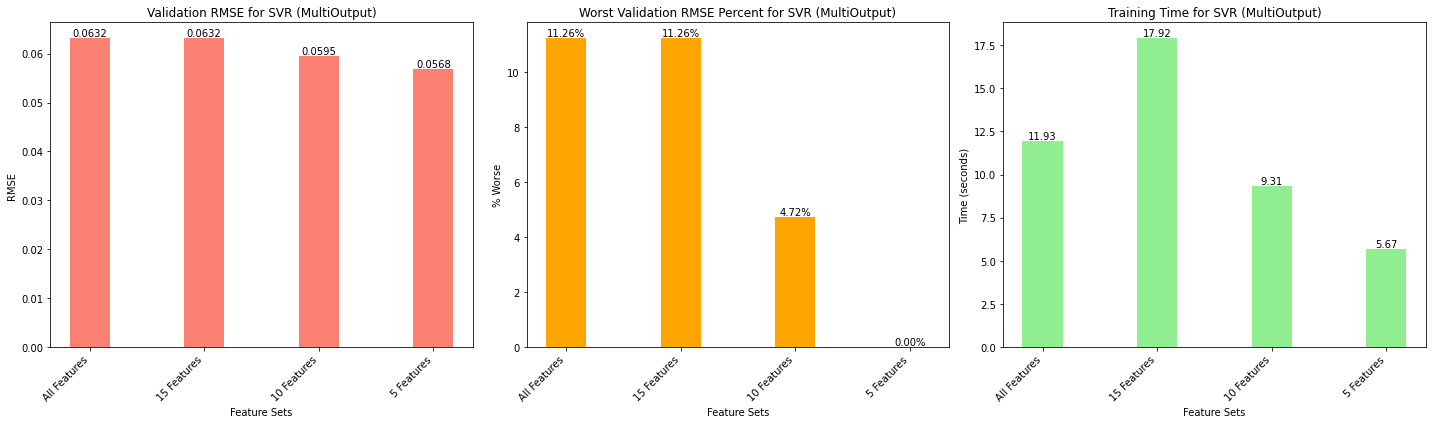


Statistical Analysis of Models Across Feature Sets
                                             Model   Feature Set  \
0                 AdaBoost Regressor (MultiOutput)   10 Features   
1                 AdaBoost Regressor (MultiOutput)   15 Features   
2                 AdaBoost Regressor (MultiOutput)    5 Features   
3                 AdaBoost Regressor (MultiOutput)  All Features   
4                 CatBoost Regressor (MultiOutput)   10 Features   
5                 CatBoost Regressor (MultiOutput)   15 Features   
6                 CatBoost Regressor (MultiOutput)    5 Features   
7                 CatBoost Regressor (MultiOutput)  All Features   
8                            ElasticNet Regression   10 Features   
9                            ElasticNet Regression   15 Features   
10                           ElasticNet Regression    5 Features   
11                           ElasticNet Regression  All Features   
12                           Extra Trees Regressor   10 Features

In [218]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Feature sets to compare
feature_sets = ['All Features', '15 Features', '10 Features', '5 Features']

# Models to compare (based on the models present in the results dictionaries)
all_models = set()
for res_dict in [results, results_15_features, results_10_features, results_5_features]:
    for category in res_dict:
        all_models.update(res_dict[category].keys())

# Prepare a container to store results for all models
all_models_results = []

# Extract data for each model across all feature sets
for target_model in all_models:
    model_results = {'Model': target_model}
    
    for results_dict, feature_set in zip(
        [results, results_15_features, results_10_features, results_5_features], 
        feature_sets
    ):
        if target_model not in model_results:
            model_results[feature_set] = {'Validation RMSE': np.nan, 'Training Time': np.nan}
        
        for top_level_key in results_dict:
            if target_model in results_dict[top_level_key]:
                metrics = results_dict[top_level_key][target_model]
                model_results[feature_set] = {
                    'Validation RMSE': metrics.get('Cross-Validation Mean RMSE', np.nan),
                    'Training Time': metrics.get('Training Time (seconds)', np.nan)
                }
    
    all_models_results.append(model_results)

# Convert the results into a structured DataFrame for better visualization
all_models_data = []
for model_result in all_models_results:
    model_name = model_result['Model']
    for feature_set in feature_sets:
        if feature_set in model_result:
            row = {
                'Model': model_name,
                'Feature Set': feature_set,
                'Validation RMSE': model_result[feature_set]['Validation RMSE'],
                'Training Time': model_result[feature_set]['Training Time']
            }
            all_models_data.append(row)

df = pd.DataFrame(all_models_data)

# Calculate %Worst for Validation RMSE for each model
df['Worst Validation RMSE Percent'] = df.groupby('Model')['Validation RMSE'].transform(lambda x: ((x / x.min()) - 1) * 100)

# Display the DataFrame
print("\nModel Comparison Across Feature Sets")
print(df)

# Plot comparative bar charts for each model
for model_name in df['Model'].unique():
    model_df = df[df['Model'] == model_name]
    x = np.arange(len(feature_sets))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots(1, 3, figsize=(20, 6))
    
    # Plot Validation RMSE
    ax[0].bar(x, model_df['Validation RMSE'], width, color='salmon', label='Validation RMSE')
    ax[0].set_title(f'Validation RMSE for {model_name}')
    ax[0].set_xlabel('Feature Sets')
    ax[0].set_ylabel('RMSE')
    ax[0].set_xticks(x)
    ax[0].set_xticklabels(feature_sets, rotation=45, ha='right')
    for i, val in enumerate(model_df['Validation RMSE']):
        if not np.isnan(val):
            ax[0].text(i, val, f'{val:.4f}', ha='center', va='bottom', fontsize=10)
    
    # Plot %Worst Validation RMSE
    ax[1].bar(x, model_df['Worst Validation RMSE Percent'], width, color='orange', label='Worst Validation RMSE Percent')
    ax[1].set_title(f'Worst Validation RMSE Percent for {model_name}')
    ax[1].set_xlabel('Feature Sets')
    ax[1].set_ylabel('% Worse')
    ax[1].set_xticks(x)
    ax[1].set_xticklabels(feature_sets, rotation=45, ha='right')
    for i, val in enumerate(model_df['Worst Validation RMSE Percent']):
        if not np.isnan(val):
            ax[1].text(i, val, f'{val:.2f}%', ha='center', va='bottom', fontsize=10)
    
    # Plot Training Time
    ax[2].bar(x, model_df['Training Time'], width, color='lightgreen', label='Training Time')
    ax[2].set_title(f'Training Time for {model_name}')
    ax[2].set_xlabel('Feature Sets')
    ax[2].set_ylabel('Time (seconds)')
    ax[2].set_xticks(x)
    ax[2].set_xticklabels(feature_sets, rotation=45, ha='right')
    for i, val in enumerate(model_df['Training Time']):
        if not np.isnan(val):
            ax[2].text(i, val, f'{val:.2f}', ha='center', va='bottom', fontsize=10)
    
    plt.tight_layout()
    plt.show()

# Provide statistical analysis for each model
stats_df = df.groupby(['Model', 'Feature Set']).agg(
    Validation_RMSE_Mean=('Validation RMSE', 'mean'),
    Training_Time_Mean=('Training Time', 'mean'),
    Worst_Validation_RMSE_Percent_Mean=('Worst Validation RMSE Percent', 'mean'),
    Validation_RMSE_Std=('Validation RMSE', 'std'),
    Training_Time_Std=('Training Time', 'std'),
    Worst_Validation_RMSE_Percent_Std=('Worst Validation RMSE Percent', 'std')
).reset_index()

print("\nStatistical Analysis of Models Across Feature Sets")
print(stats_df)



Model Comparison Across Feature Sets
                                             Model   Feature Set  \
0                          Random Forest Regressor  All Features   
1                          Random Forest Regressor   15 Features   
2                          Random Forest Regressor   10 Features   
3                          Random Forest Regressor    5 Features   
4                            Extra Trees Regressor  All Features   
5                            Extra Trees Regressor   15 Features   
6                            Extra Trees Regressor   10 Features   
7                            Extra Trees Regressor    5 Features   
8                 CatBoost Regressor (MultiOutput)  All Features   
9                 CatBoost Regressor (MultiOutput)   15 Features   
10                CatBoost Regressor (MultiOutput)   10 Features   
11                CatBoost Regressor (MultiOutput)    5 Features   
12              KNeighbors Regressor (MultiOutput)  All Features   
13        

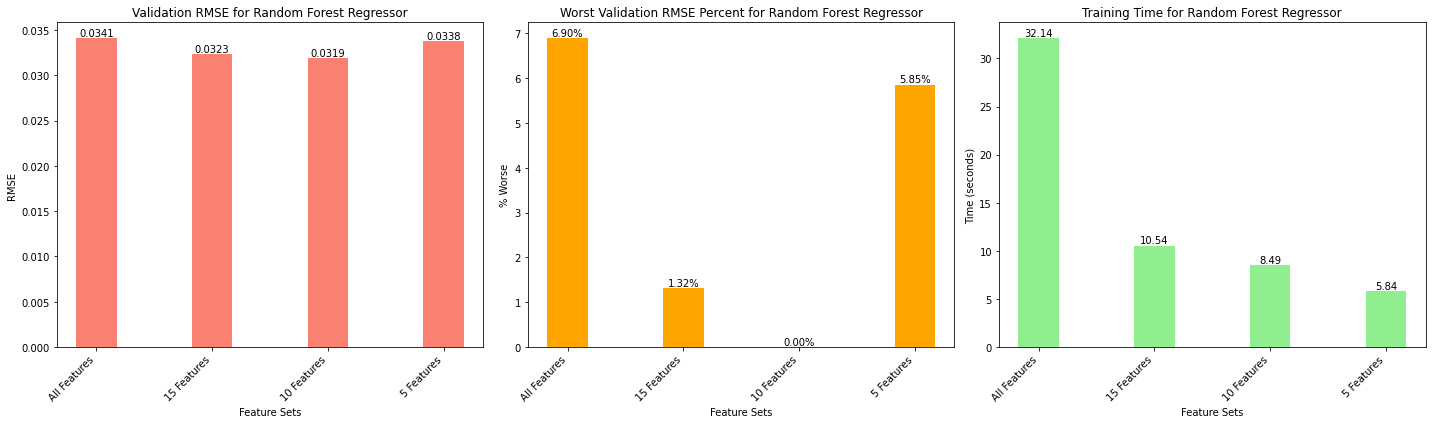

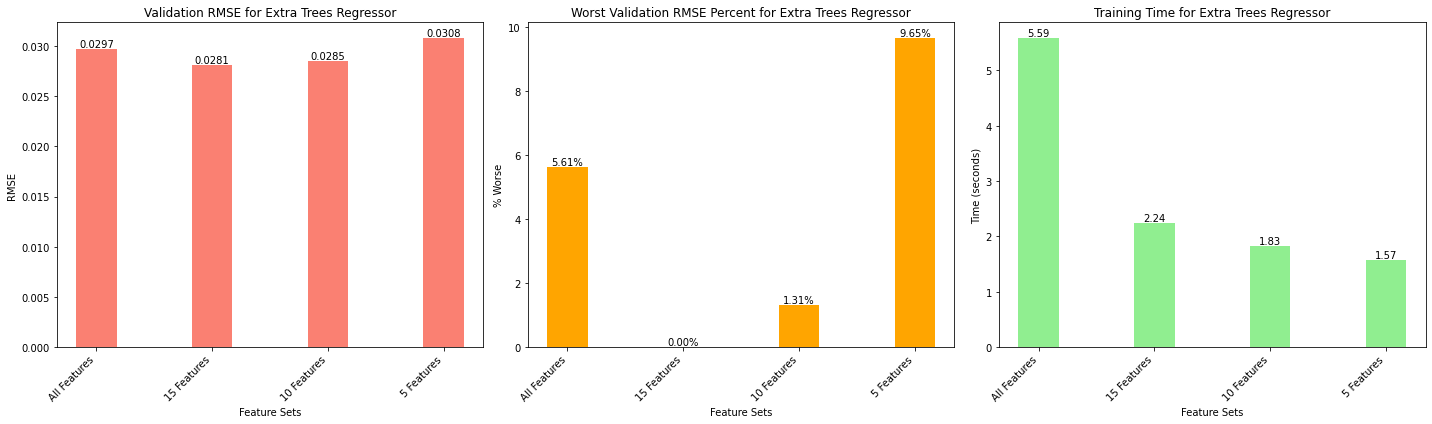

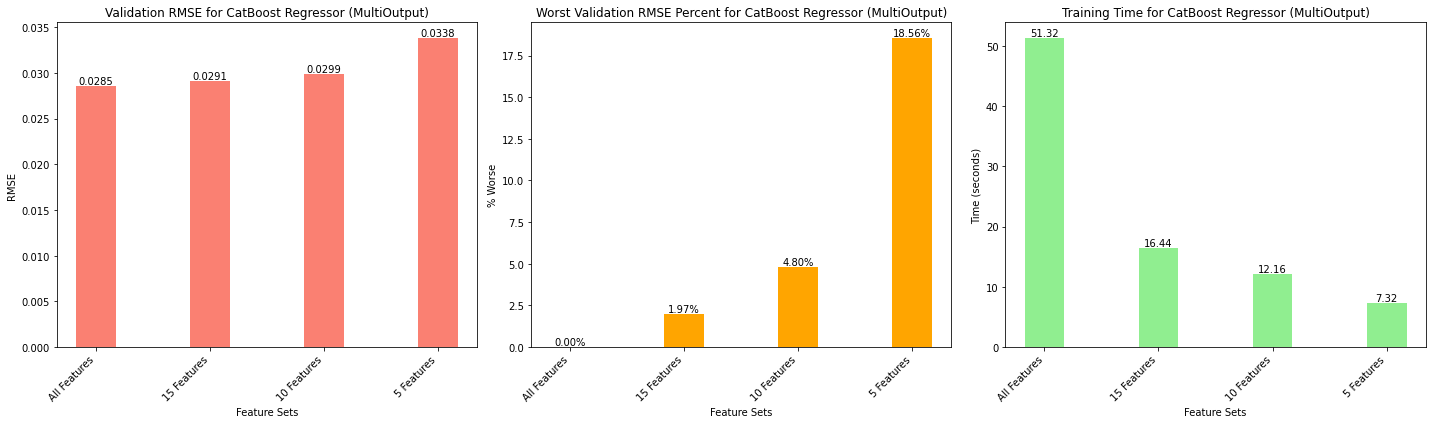

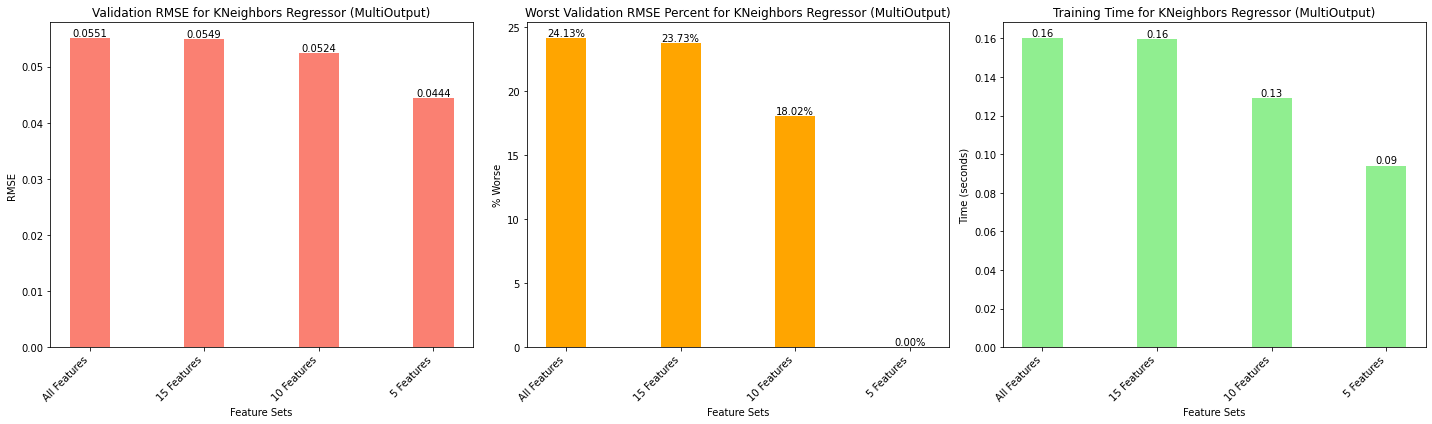

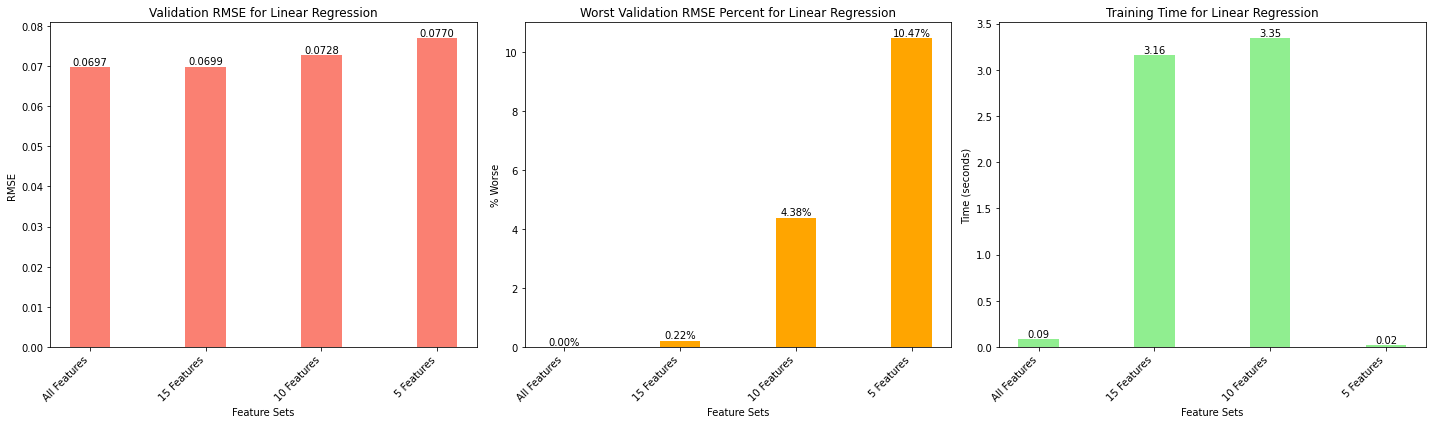

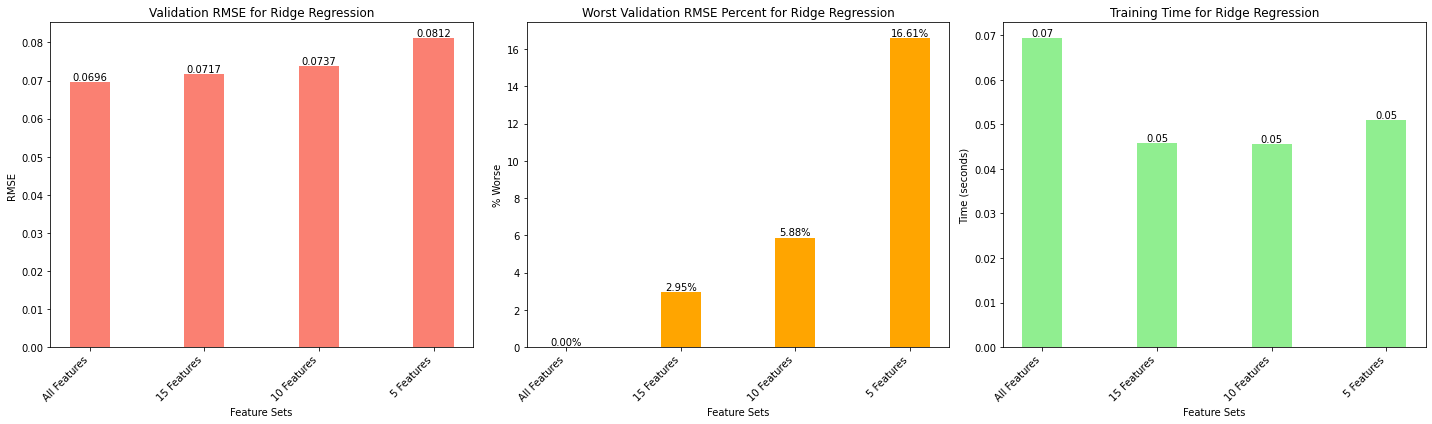

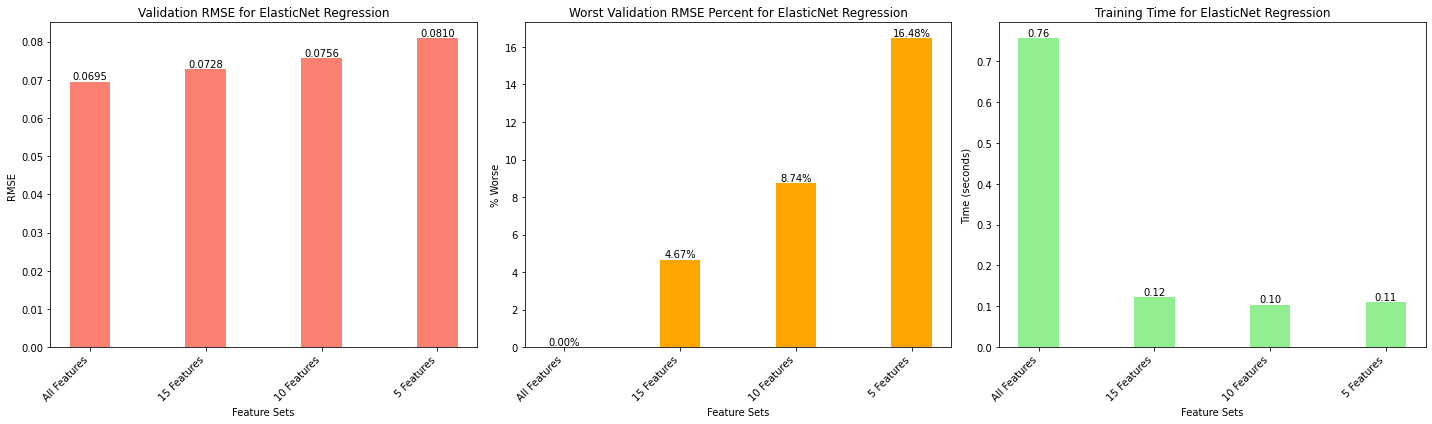

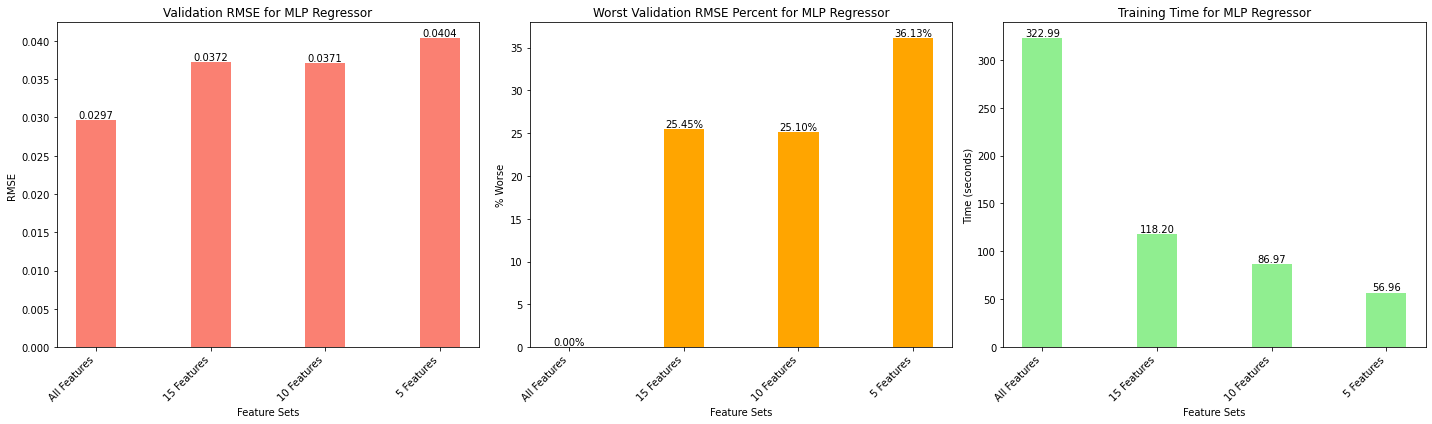

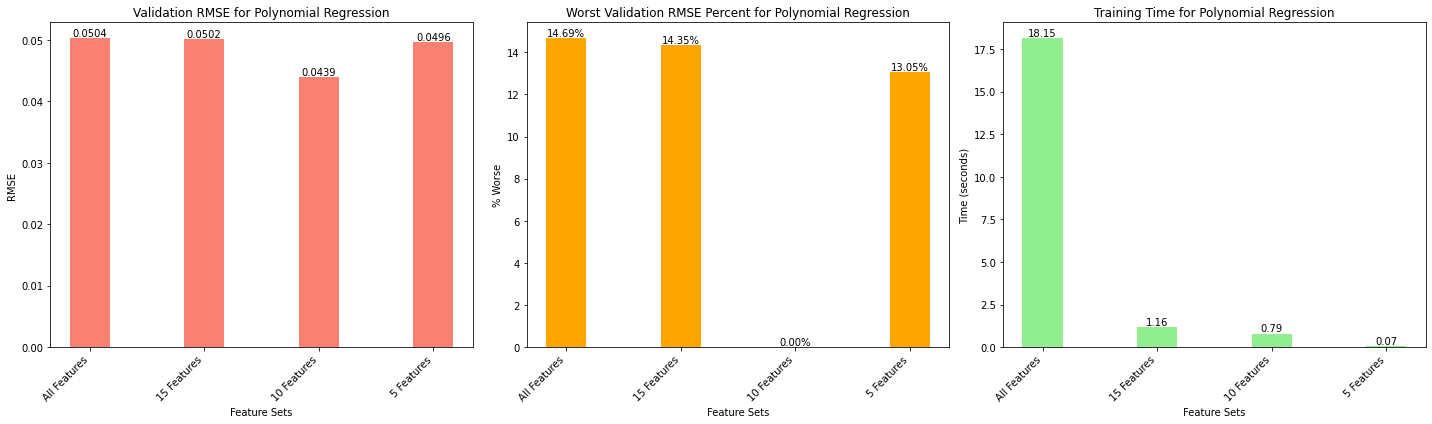

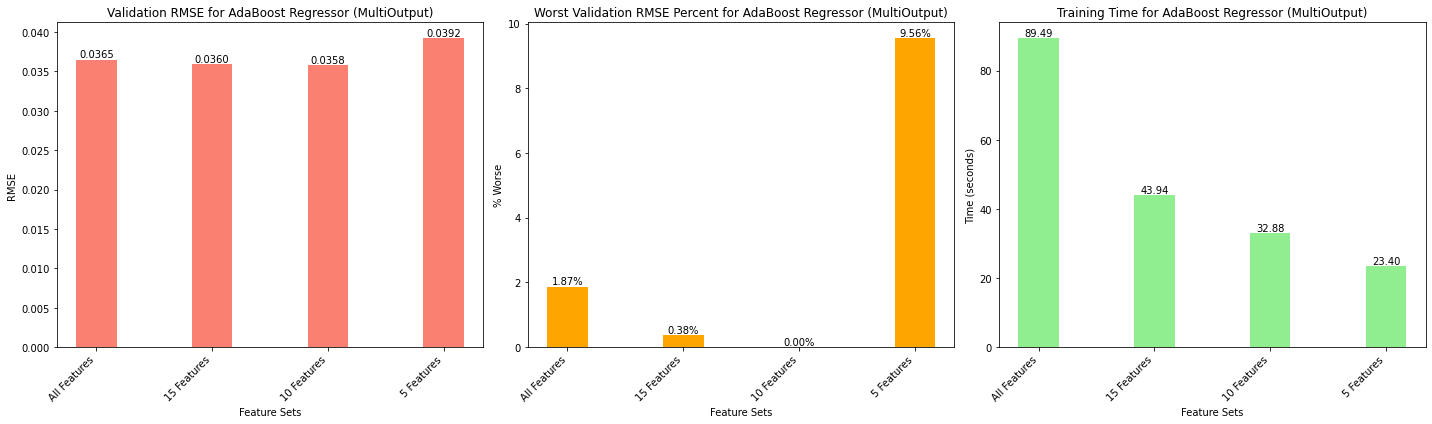

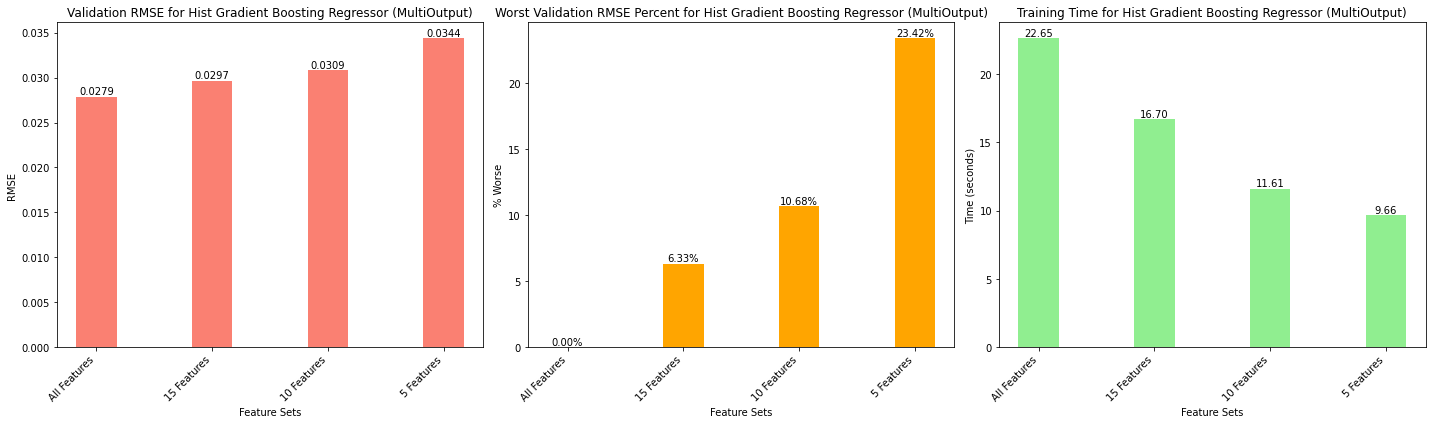

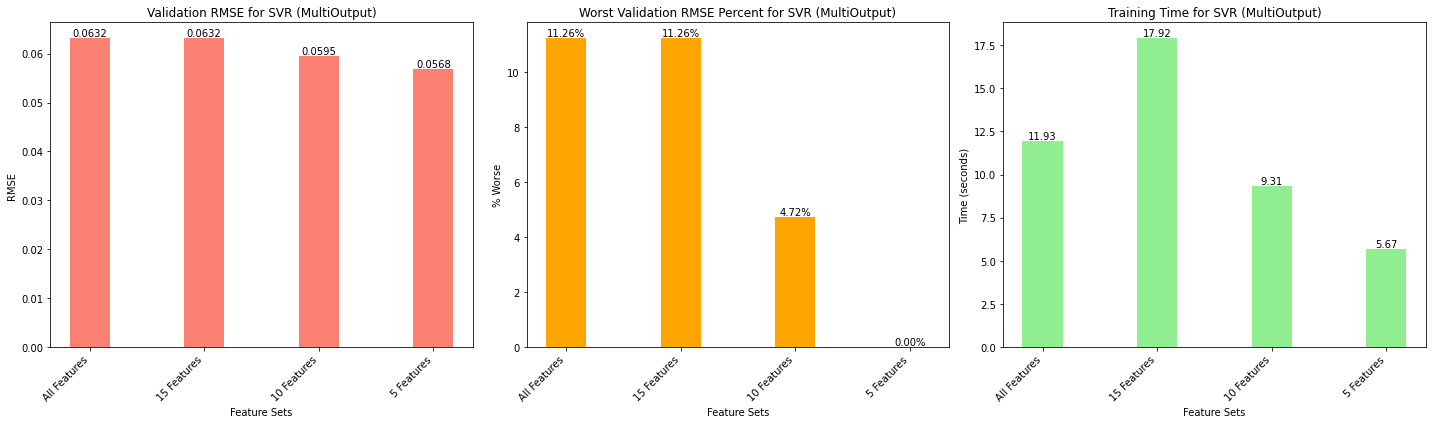


Statistical Analysis with Overall Comparison
                                             Model   Feature Set  \
0                 AdaBoost Regressor (MultiOutput)   10 Features   
1                 AdaBoost Regressor (MultiOutput)   15 Features   
2                 AdaBoost Regressor (MultiOutput)    5 Features   
3                 AdaBoost Regressor (MultiOutput)  All Features   
4                 CatBoost Regressor (MultiOutput)   10 Features   
5                 CatBoost Regressor (MultiOutput)   15 Features   
6                 CatBoost Regressor (MultiOutput)    5 Features   
7                 CatBoost Regressor (MultiOutput)  All Features   
8                            ElasticNet Regression   10 Features   
9                            ElasticNet Regression   15 Features   
10                           ElasticNet Regression    5 Features   
11                           ElasticNet Regression  All Features   
12                           Extra Trees Regressor   10 Features   
13

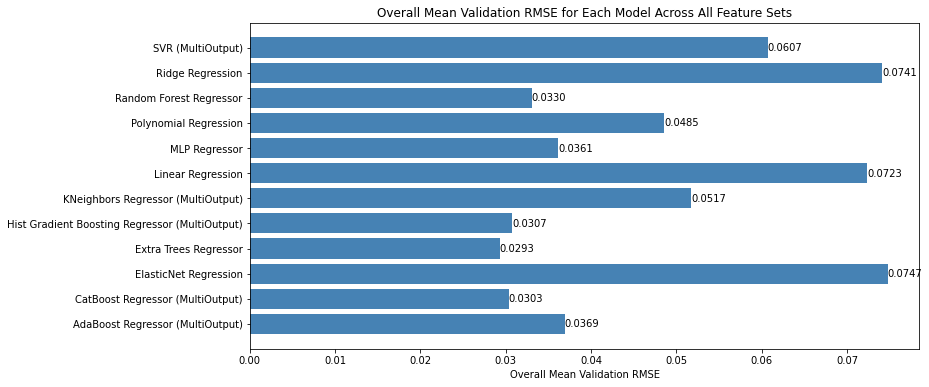

In [227]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Feature sets to compare
feature_sets = ['All Features', '15 Features', '10 Features', '5 Features']

# Models to compare (based on the models present in the results dictionaries)
all_models = set()
for res_dict in [results, results_15_features, results_10_features, results_5_features]:
    for category in res_dict:
        all_models.update(res_dict[category].keys())

# Prepare a container to store results for all models
all_models_results = []

# Extract data for each model across all feature sets
for target_model in all_models:
    model_results = {'Model': target_model}
    
    for results_dict, feature_set in zip(
        [results, results_15_features, results_10_features, results_5_features], 
        feature_sets
    ):
        if target_model not in model_results:
            model_results[feature_set] = {'Validation RMSE': np.nan, 'Training Time': np.nan}
        
        for top_level_key in results_dict:
            if target_model in results_dict[top_level_key]:
                metrics = results_dict[top_level_key][target_model]
                model_results[feature_set] = {
                    'Validation RMSE': metrics.get('Cross-Validation Mean RMSE', np.nan),
                    'Training Time': metrics.get('Training Time (seconds)', np.nan)
                }
    
    all_models_results.append(model_results)

# Convert the results into a structured DataFrame for better visualization
all_models_data = []
for model_result in all_models_results:
    model_name = model_result['Model']
    for feature_set in feature_sets:
        if feature_set in model_result:
            row = {
                'Model': model_name,
                'Feature Set': feature_set,
                'Validation RMSE': model_result[feature_set]['Validation RMSE'],
                'Training Time': model_result[feature_set]['Training Time']
            }
            all_models_data.append(row)

df = pd.DataFrame(all_models_data)

# Calculate %Worst for Validation RMSE for each model
df['Worst Validation RMSE Percent'] = df.groupby('Model')['Validation RMSE'].transform(lambda x: ((x / x.min()) - 1) * 100)

# Display the DataFrame
print("\nModel Comparison Across Feature Sets")
print(df)

# Plot comparative bar charts for each model
for model_name in df['Model'].unique():
    model_df = df[df['Model'] == model_name]
    x = np.arange(len(feature_sets))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots(1, 3, figsize=(20, 6))
    
    # Plot Validation RMSE
    ax[0].bar(x, model_df['Validation RMSE'], width, color='salmon', label='Validation RMSE')
    ax[0].set_title(f'Validation RMSE for {model_name}')
    ax[0].set_xlabel('Feature Sets')
    ax[0].set_ylabel('RMSE')
    ax[0].set_xticks(x)
    ax[0].set_xticklabels(feature_sets, rotation=45, ha='right')
    for i, val in enumerate(model_df['Validation RMSE']):
        if not np.isnan(val):
            ax[0].text(i, val, f'{val:.4f}', ha='center', va='bottom', fontsize=10)
    
    # Plot %Worst Validation RMSE
    ax[1].bar(x, model_df['Worst Validation RMSE Percent'], width, color='orange', label='Worst Validation RMSE Percent')
    ax[1].set_title(f'Worst Validation RMSE Percent for {model_name}')
    ax[1].set_xlabel('Feature Sets')
    ax[1].set_ylabel('% Worse')
    ax[1].set_xticks(x)
    ax[1].set_xticklabels(feature_sets, rotation=45, ha='right')
    for i, val in enumerate(model_df['Worst Validation RMSE Percent']):
        if not np.isnan(val):
            ax[1].text(i, val, f'{val:.2f}%', ha='center', va='bottom', fontsize=10)
    
    # Plot Training Time
    ax[2].bar(x, model_df['Training Time'], width, color='lightgreen', label='Training Time')
    ax[2].set_title(f'Training Time for {model_name}')
    ax[2].set_xlabel('Feature Sets')
    ax[2].set_ylabel('Time (seconds)')
    ax[2].set_xticks(x)
    ax[2].set_xticklabels(feature_sets, rotation=45, ha='right')
    for i, val in enumerate(model_df['Training Time']):
        if not np.isnan(val):
            ax[2].text(i, val, f'{val:.2f}', ha='center', va='bottom', fontsize=10)
    
    plt.tight_layout()
    plt.show()

# Provide statistical analysis for each model
stats_df = df.groupby(['Model', 'Feature Set']).agg(
    Validation_RMSE_Mean=('Validation RMSE', 'mean'),
    Training_Time_Mean=('Training Time', 'mean'),
    Worst_Validation_RMSE_Percent_Mean=('Worst Validation RMSE Percent', 'mean'),
    Validation_RMSE_Std=('Validation RMSE', 'std'),
    Training_Time_Std=('Training Time', 'std'),
    Worst_Validation_RMSE_Percent_Std=('Worst Validation RMSE Percent', 'std')
).reset_index()

# Calculate overall mean of Validation RMSE for each model across all feature sets
overall_validation_rmse = df.groupby('Model')['Validation RMSE'].mean().reset_index()
overall_validation_rmse.rename(columns={'Validation RMSE': 'Overall Mean Validation RMSE'}, inplace=True)

# Merge this with the statistical analysis DataFrame
final_stats_df = pd.merge(stats_df, overall_validation_rmse, on='Model')

# Rank models based on Overall Mean Validation RMSE
final_stats_df['Rank'] = final_stats_df.groupby('Feature Set')['Overall Mean Validation RMSE'].rank()

# Display the updated statistical analysis
print("\nStatistical Analysis with Overall Comparison")
print(final_stats_df)

# Plot Overall Mean Validation RMSE for each model
plt.figure(figsize=(12, 6))
plt.barh(overall_validation_rmse['Model'], overall_validation_rmse['Overall Mean Validation RMSE'], color='steelblue')
plt.xlabel('Overall Mean Validation RMSE')
plt.title('Overall Mean Validation RMSE for Each Model Across All Feature Sets')
for i, val in enumerate(overall_validation_rmse['Overall Mean Validation RMSE']):
    plt.text(val, i, f'{val:.4f}', ha='left', va='center', fontsize=10)
plt.show()



Model Comparison Across Feature Sets
                                             Model   Feature Set  \
0                                Linear Regression  All Features   
1                                Linear Regression   15 Features   
2                                Linear Regression   10 Features   
3                                Linear Regression    5 Features   
4                                 Ridge Regression  All Features   
5                                 Ridge Regression   15 Features   
6                                 Ridge Regression   10 Features   
7                                 Ridge Regression    5 Features   
8                            ElasticNet Regression  All Features   
9                            ElasticNet Regression   15 Features   
10                           ElasticNet Regression   10 Features   
11                           ElasticNet Regression    5 Features   
12                           Polynomial Regression  All Features   
13        

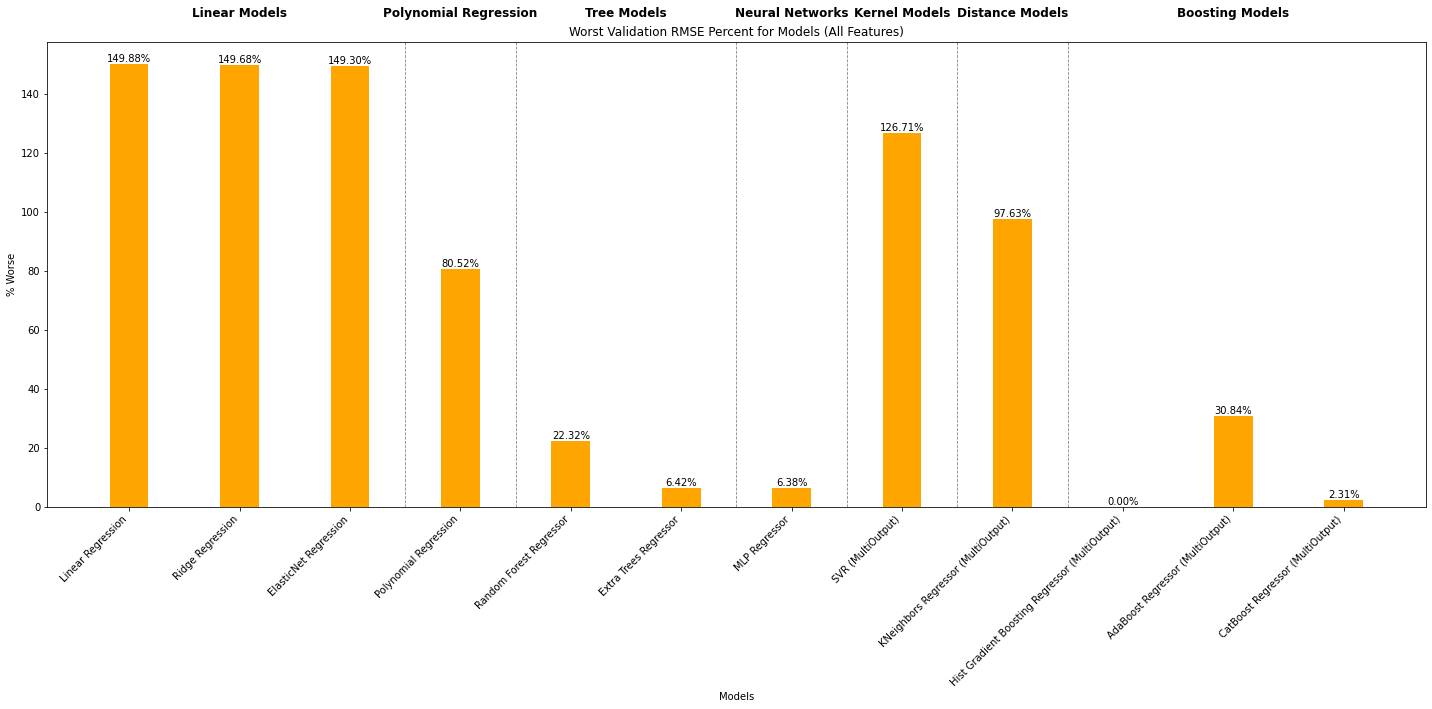

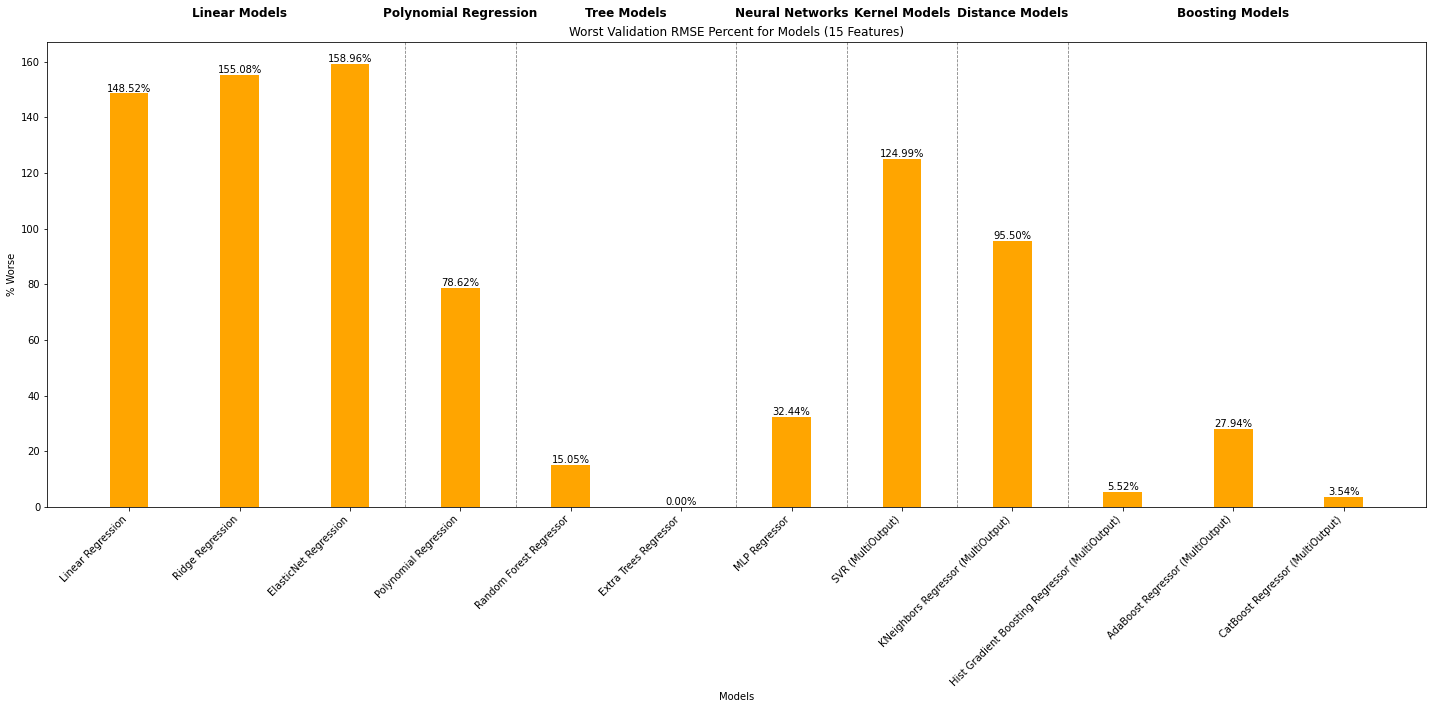

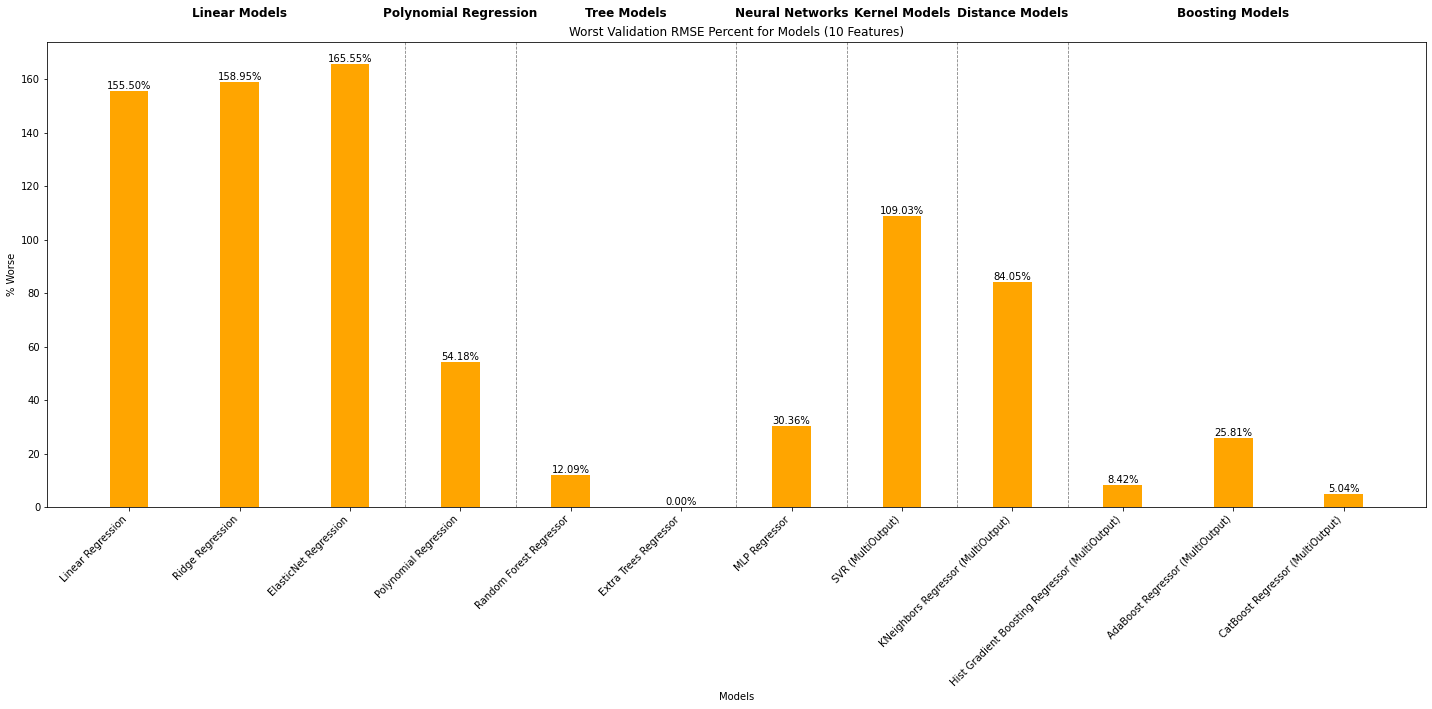

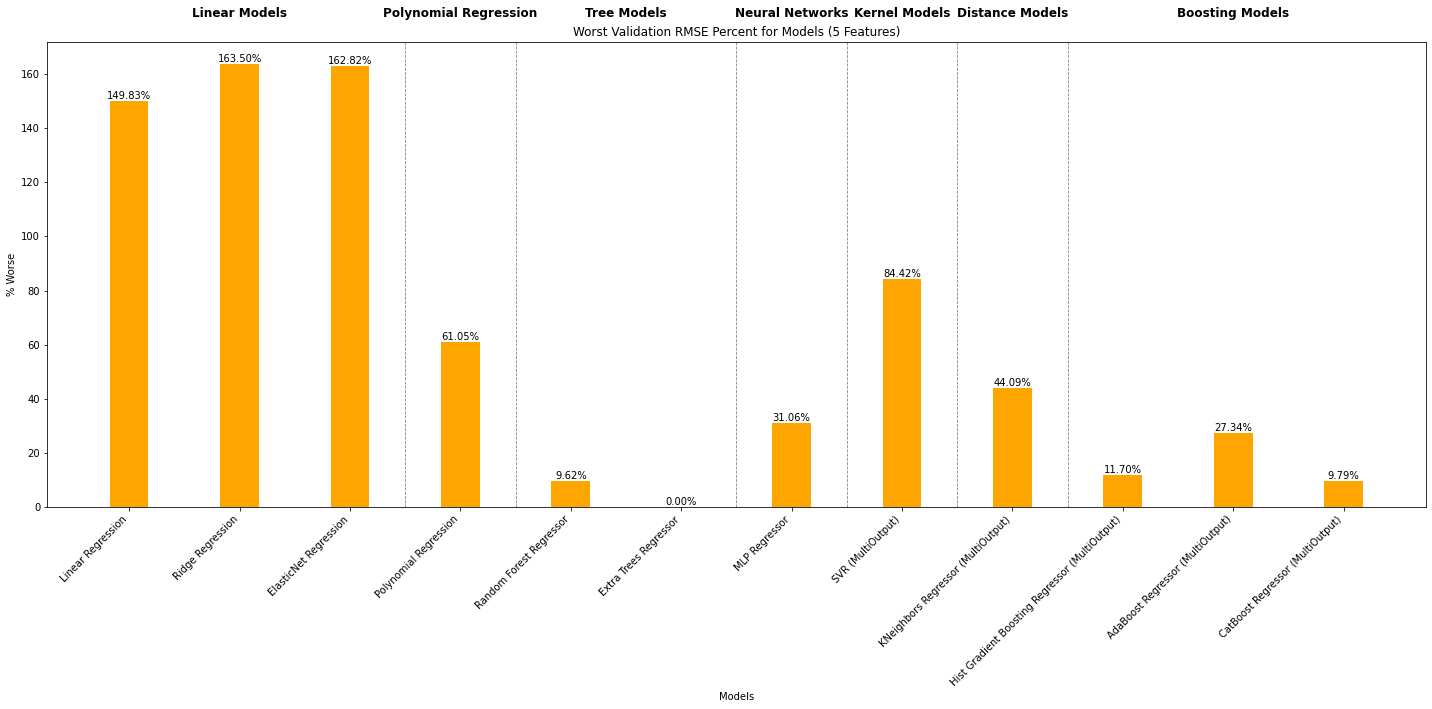


Statistical Analysis with Overall Comparison
                                             Model   Feature Set  \
0                 AdaBoost Regressor (MultiOutput)   10 Features   
1                 AdaBoost Regressor (MultiOutput)   15 Features   
2                 AdaBoost Regressor (MultiOutput)    5 Features   
3                 AdaBoost Regressor (MultiOutput)  All Features   
4                 CatBoost Regressor (MultiOutput)   10 Features   
5                 CatBoost Regressor (MultiOutput)   15 Features   
6                 CatBoost Regressor (MultiOutput)    5 Features   
7                 CatBoost Regressor (MultiOutput)  All Features   
8                            ElasticNet Regression   10 Features   
9                            ElasticNet Regression   15 Features   
10                           ElasticNet Regression    5 Features   
11                           ElasticNet Regression  All Features   
12                           Extra Trees Regressor   10 Features   
13

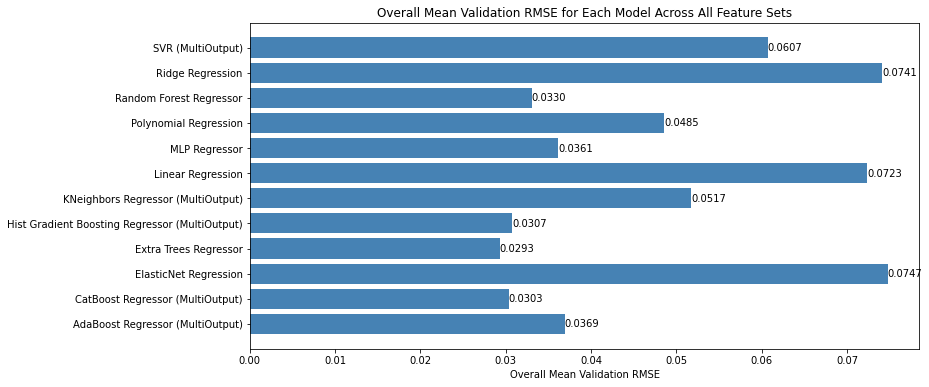

In [240]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Feature sets to compare
feature_sets = ['All Features', '15 Features', '10 Features', '5 Features']

# Group models by category
model_categories = {
    'Linear Models': ['Linear Regression', 'Ridge Regression', 'ElasticNet Regression'],
    'Polynomial Regression': ['Polynomial Regression'],
    'Tree Models': ['Random Forest Regressor', 'Extra Trees Regressor'],
    'Neural Networks': ['MLP Regressor'],
    'Kernel Models': ['SVR (MultiOutput)'],
    'Distance Models': ['KNeighbors Regressor (MultiOutput)'],
    'Boosting Models': [
        'Hist Gradient Boosting Regressor (MultiOutput)',
        'AdaBoost Regressor (MultiOutput)',
        'CatBoost Regressor (MultiOutput)'
    ]
}

# Create a list of models ordered by categories
ordered_models = []
for category in model_categories:
    ordered_models.extend(model_categories[category])

# Extract data for each model across all feature sets
all_models_results = []

for target_model in ordered_models:
    model_results = {'Model': target_model}
    
    for results_dict, feature_set in zip(
        [results, results_15_features, results_10_features, results_5_features], 
        feature_sets
    ):
        if target_model not in model_results:
            model_results[feature_set] = {'Validation RMSE': np.nan, 'Training Time': np.nan}
        
        for top_level_key in results_dict:
            if target_model in results_dict[top_level_key]:
                metrics = results_dict[top_level_key][target_model]
                model_results[feature_set] = {
                    'Validation RMSE': metrics.get('Cross-Validation Mean RMSE', np.nan),
                    'Training Time': metrics.get('Training Time (seconds)', np.nan)
                }
    
    all_models_results.append(model_results)

# Convert the results into a structured DataFrame for better visualization
all_models_data = []
for model_result in all_models_results:
    model_name = model_result['Model']
    for feature_set in feature_sets:
        if feature_set in model_result:
            row = {
                'Model': model_name,
                'Feature Set': feature_set,
                'Validation RMSE': model_result[feature_set]['Validation RMSE'],
                'Training Time': model_result[feature_set]['Training Time']
            }
            all_models_data.append(row)

df = pd.DataFrame(all_models_data)

# Calculate %Worst for Validation RMSE for each feature set separately
df['Worst Validation RMSE Percent'] = df.groupby('Feature Set')['Validation RMSE'].transform(lambda x: ((x / x.min()) - 1) * 100)

# Display the DataFrame
print("\nModel Comparison Across Feature Sets")
print(df)

# Plot comparative bar charts for %Worst Validation RMSE for each feature set
for feature_set in feature_sets:
    feature_df = df[df['Feature Set'] == feature_set]
    x = np.arange(len(ordered_models))  # the label locations
    width = 0.35  # the width of the bars

    plt.figure(figsize=(20, 10))
    bars = plt.bar(x, feature_df['Worst Validation RMSE Percent'], width, color='orange', label='Worst Validation RMSE Percent')
    plt.title(f'Worst Validation RMSE Percent for Models ({feature_set})')
    plt.xlabel('Models')
    plt.ylabel('% Worse')
    plt.xticks(x, ordered_models, rotation=45, ha='right')
    
    # Calculate maximum y-axis value for placing category labels higher up
    max_y = feature_df['Worst Validation RMSE Percent'].max()
    label_y_position = max_y * 1.10  # Place labels 15% higher than the max value

    # Add category labels
    current_index = 0
    for category, models in model_categories.items():
        n = len(models)
        if n > 0:
            center = current_index + (n - 1) / 2
            plt.text(center, label_y_position, category, 
                     ha='center', va='bottom', fontsize=12, fontweight='bold')
            current_index += n
            
            # Draw vertical line to separate categories
            if current_index < len(ordered_models):
                plt.axvline(current_index - 0.5, color='grey', linestyle='--', linewidth=0.8)
    
    # Add values on top of each bar
    for bar in bars:
        height = bar.get_height()
        if not np.isnan(height):
            plt.text(bar.get_x() + bar.get_width()/2, height, f'{height:.2f}%', 
                     ha='center', va='bottom', fontsize=10)

    plt.tight_layout()
    plt.show()

# Provide statistical analysis for each model
stats_df = df.groupby(['Model', 'Feature Set']).agg(
    Validation_RMSE_Mean=('Validation RMSE', 'mean'),
    Training_Time_Mean=('Training Time', 'mean'),
    Worst_Validation_RMSE_Percent_Mean=('Worst Validation RMSE Percent', 'mean'),
    Validation_RMSE_Std=('Validation RMSE', 'std'),
    Training_Time_Std=('Training Time', 'std'),
    Worst_Validation_RMSE_Percent_Std=('Worst Validation RMSE Percent', 'std')
).reset_index()

# Calculate overall mean of Validation RMSE for each model across all feature sets
overall_validation_rmse = df.groupby('Model')['Validation RMSE'].mean().reset_index()
overall_validation_rmse.rename(columns={'Validation RMSE': 'Overall Mean Validation RMSE'}, inplace=True)

# Merge this with the statistical analysis DataFrame
final_stats_df = pd.merge(stats_df, overall_validation_rmse, on='Model')

# Rank models based on Overall Mean Validation RMSE
final_stats_df['Rank'] = final_stats_df.groupby('Feature Set')['Overall Mean Validation RMSE'].rank()

# Display the updated statistical analysis
print("\nStatistical Analysis with Overall Comparison")
print(final_stats_df)

# Plot Overall Mean Validation RMSE for each model
plt.figure(figsize=(12, 6))
plt.barh(overall_validation_rmse['Model'], overall_validation_rmse['Overall Mean Validation RMSE'], color='steelblue')
plt.xlabel('Overall Mean Validation RMSE')
plt.title('Overall Mean Validation RMSE for Each Model Across All Feature Sets')
for i, val in enumerate(overall_validation_rmse['Overall Mean Validation RMSE']):
    plt.text(val, i, f'{val:.4f}', ha='left', va='center', fontsize=10)
plt.show()